In [29]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from torch import nn,optim
import torch

import algo

rand_seed=24
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)



In [2]:
raw_data_path = '../datasets/dataset_purchase'
raw_data = pd.read_csv(raw_data_path)
y=raw_data['63']
X_raw =raw_data.drop('63', axis=1)
y_raw =  y.replace(100, 0)
print('Dataset: ', raw_data_path)
print('Classes in classification task: ', y.nunique())
n_classes = y.nunique()

Dataset:  ../datasets/dataset_purchase
Classes in classification task:  100


In [30]:
X_train, x_shadow, y_train, y_shadow = train_test_split(X_raw, y_raw, train_size=0.2, random_state=rand_seed)
print(X_train.shape, x_shadow.shape)

#Target model
X_train_size = 10000
X_test_size = 10000
x_target_train = np.array(X_train[:X_train_size])
y_target_train = np.array(y_train[:X_train_size])
x_target_test = np.array(X_train[X_train_size:X_train_size+X_test_size])
y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])
if y_target_test.shape[0]<X_test_size or y_target_train.shape[0]<X_train_size:
    raise ValueError(
            "Not enough traning or test data for the target model")        


(39464, 600) (157859, 600)


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3339399080.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3339399080.py:10: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


In [18]:
model = algo.LogisticRegression_DPSGD()

model.n_classes      = n_classes
model.alpha          = 0.001
model.max_iter       = 100
model.lambda_        = 1e-5
model.tolerance      = 1e-5
model.DP             = False
model.L              = 10
model.epsilon        = 0

In [310]:
# rand_seed=42
# np.random.seed(rand_seed)
# torch.manual_seed(rand_seed)
# random.seed(rand_seed)

# X,y = model.init_theta(x_target_train, y_target_train)
# model.train(X,y)
# model.evaluate(x_target_train, y_target_train, acc=True)
# model.evaluate(x_target_test, y_target_test, acc=True)
            

In [152]:
class Net_attack(nn.Module):

    def __init__(self, h_neurons, do, input_size):
        super(Net_attack, self).__init__()
        self.input_size = input_size
        self.h_neurons = h_neurons
        self.do = do
        self.fc1 = nn.Linear(input_size, h_neurons)
        self.fc2 = nn.Linear(h_neurons, 2)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(do)
        self.softmax = nn.Softmax(dim=1)   

    def forward(self, x):
        x = x.view(-1, self.input_size)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.drop(x)
        x = self.softmax(x)
        return x


def attack_evaluation(model, x, y, dev="cpu", extended=False):

    model.eval()

    with torch.no_grad():
        output =  model(x)
        out_target = output.argmax(1, keepdim=True)
        correct = out_target.to(dev).eq(y.to(dev).view_as(out_target.to(dev))).sum().item()
        acc = correct/y.shape[0]

        predicted_positive = output.argmax(1, keepdim=True) == 1
        labeled_positive = y == 1
        tp = predicted_positive.to(dev) * labeled_positive.to(dev).view_as(out_target)
        tp_count = tp.to(dev).sum().item()
        
        if predicted_positive.to(dev).sum().item() != 0:
            pre = tp_count / predicted_positive.to(dev).sum().item()
        else:
            pre = 0
        if labeled_positive.to(dev).sum().item() !=0:
            rec = tp_count / labeled_positive.to(dev).sum().item()
        else:
            rec = 0
    if extended:
        predicted_negative = output.argmax(1, keepdim=True) == 0
        labeled_negative = y == 0
        tn = predicted_negative.to(dev) * labeled_negative.to(dev).view_as(out_target)
        tn_count = tn.to(dev).sum().item()

        fp_count = predicted_positive.to(dev).sum().item() - tp.to(dev).sum().item()
        fn_count = labeled_positive.to(dev).sum().item() - tp.to(dev).sum().item()
        
        return acc, pre, rec, tp_count, tn_count, fp_count, fn_count
    else:
        return acc, pre, rec

def mi_attack_test(model, a_model, x_target_train, y_target_train, x_target_test, y_target_test):
    
    train_pred = model.predict(x_target_train, y_target_train)
    test_pred = model.predict(x_target_test, y_target_test)

    _,y_train = model.init_theta(x_target_train, y_target_train)
    _,y_test = model.init_theta(x_target_test, y_target_test)

    # members
    labels = np.ones(x_target_train.shape[0])
    # non-members
    test_labels = np.zeros(x_target_test.shape[0])

    x_1 = np.concatenate((train_pred, test_pred))
    x_2 = np.concatenate((y_train, y_test))#.reshape((-1, 1))
    y_new = np.concatenate((labels, test_labels))

    attack_test_data = np.concatenate((x_1,x_2),axis=1)
    attack_test_target = y_new
    df = pd.DataFrame(attack_test_data)
    df['a_target'] = attack_test_target
    df = df.sample(frac = 1)

    attack_test_data = np.array(df.drop(['a_target'], axis=1))
    attack_test_target= np.array(df['a_target'])

    attack_test_data = torch.tensor(np.array(df.drop(['a_target'], axis=1)), dtype=torch.float, requires_grad=True)   
    attack_test_target = torch.tensor(np.array(df['a_target']), dtype=torch.float)
    
    test_acc, test_pre, test_rec = attack_evaluation(a_model, attack_test_data, attack_test_target)
    return test_acc, test_pre, test_rec

def data_shuffle(rand_seed, X_raw, y_raw):
    X_train, x_shadow, y_train, y_shadow = train_test_split(X_raw, y_raw, train_size=0.2, random_state=rand_seed)
#     print(X_train.shape, x_shadow.shape)

    #Target model
    X_train_size = 10000
    X_test_size = 10000
    x_target_train = np.array(X_train[:X_train_size])
    y_target_train = np.array(y_train[:X_train_size])
    x_target_test = np.array(X_train[X_train_size:X_train_size+X_test_size])
    y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])
    if y_target_test.shape[0]<X_test_size or y_target_train.shape[0]<X_train_size:
        raise ValueError(
                "Not enough traning or test data for the target model")        
    return x_target_train, y_target_train, x_target_test, y_target_test

In [5]:
a_model = Net_attack(h_neurons=64, do=0, input_size=100)
a_model = torch.load('attack_model') 
a_model.input_size = 200

In [311]:
path = 'mia'
ams = {}
for r,d,f in os.walk(path):
    for file in f:
        if "best_mi_model" in file:
            ams[file] = torch.load(r+'/'+file)
            
            

In [312]:
best_ams = []
for am in ams:
#     print(am)
    a_model = Net_attack(h_neurons=64, do=0, input_size=100)
    a_model = ams[am] 
#     print(a_model)
    a_model.input_size = 200
    test_acc, test_pre, test_rec = attack_evaluation(a_model, attack_test_data, attack_test_target)
    if test_acc>0.65:
        best_ams.append(am)
    print(test_acc, test_pre, test_rec)

0.6564 0.5936751317680882 0.9912
0.66145 0.597042736070205 0.9933
0.6531 0.5905917159763313 0.9981
0.65745 0.5962114268255423 0.9757
0.65345 0.5906968496956085 0.9994
0.6711 0.6052404969860992 0.984


In [ ]:
a_model = ams[am]

In [146]:
target_model = np.load('tm/rs24_lr0.001_iter100_reg1e-05_DPFalse_target_model.npy')
# target_model = model

In [147]:
model = algo.LogisticRegression_DPSGD()
model.n_classes      = n_classes
model.theta = target_model
model.train_acc = model.evaluate(x_target_train, y_target_train, acc=True)
model.test_acc = model.evaluate(x_target_test, y_target_test, acc=True)

The accuracy of the model : 57.099999999999994 %
The accuracy of the model : 57.4 %


In [148]:
train_pred = model.predict(x_target_train, y_target_train)
test_pred = model.predict(x_target_test, y_target_test)

In [149]:
_,y_train = model.init_theta(x_target_train, y_target_train)
_,y_test = model.init_theta(x_target_test, y_target_test)


In [34]:
# members
labels = np.ones(x_target_train.shape[0])
# non-members
test_labels = np.zeros(x_target_test.shape[0])

x_1 = np.concatenate((train_pred, test_pred))
x_2 = np.concatenate((y_train, y_test))#.reshape((-1, 1))
y_new = np.concatenate((labels, test_labels))

attack_test_data = np.concatenate((x_1,x_2),axis=1)
attack_test_target = y_new
df = pd.DataFrame(attack_test_data)
df['a_target'] = attack_test_target
df = df.sample(frac = 1)

attack_test_data = np.array(df.drop(['a_target'], axis=1))
attack_test_target= np.array(df['a_target'])


In [35]:
attack_test_data = torch.tensor(np.array(df.drop(['a_target'], axis=1)), dtype=torch.float, requires_grad=True)   
attack_test_target = torch.tensor(np.array(df['a_target']), dtype=torch.float)
# attack_test_args = Train_args(learning_rate=0.001, weight_decay=1e-3, epoch=200)
# attack_model = Net_attack(h_neurons=64, do=0, input_size=attack_train_data.shape[1])


In [36]:
test_acc, test_pre, test_rec = attack_evaluation(a_model, attack_test_data, attack_test_target)
test_acc, test_pre, test_rec

(0.85215, 0.8109492273730684, 0.9184)

In [37]:
# MI on target models

In [38]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import algo
import json

In [45]:
path = 'tm'
tms_params = {}
tms = {}
for r,d,f in os.walk(path):
    for file in f:
        if "target_model_params.json" in file:
            with open(path+'/'+file) as json_file:
                tms_params[file.replace('_params.json', '')] = json.load(json_file)
        if "target_model.npy" in file:
            tms[file.replace('.npy', '')] = np.load(path+'/'+file)
            
            

In [73]:
for key in tms:
    print(key)
    if 'attack_acc' in list(tms_params[key]):
        continue
    rand_seed = int(key[key.find('rs')+2:key.find('_lr')])
    x_target_train, y_target_train, x_target_test, y_target_test = data_shuffle(rand_seed, X_raw, y_raw)
    model = algo.LogisticRegression_DPSGD()
    model.n_classes = n_classes
    model.theta = tms[key]
    model.train_acc = model.evaluate(x_target_train, y_target_train, acc=True)
    model.test_acc = model.evaluate(x_target_test, y_target_test, acc=True)
    
    attack_acc, attack_pre, attack_rec = mi_attack_test(model, x_target_train, y_target_train, x_target_test, y_target_test)
    tms_params[key]['attack_acc'] = attack_acc
    tms_params[key]['attack_pre'] = attack_pre
    tms_params[key]['attack_rec'] = attack_rec
    print(tms_params[key])
    with open('tm/'+key+'_params.json', 'w') as file:
                json.dump(tms_params[key], file)
#     break

rs13_lr0.001_iter100_reg0.005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 82.6 %
The accuracy of the model : 53.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8257, 'test_acc': 0.535, 'attack_acc': 0.5027, 'attack_pre': 0.7410714285714286, 'attack_rec': 0.0083}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps0.1_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 1.7000000000000002 %
The accuracy of the model : 1.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 0.1, 'delta': 1e-05, 'train_acc': 0.0168, 'test_acc': 0.0151, 'attack_acc': 0.501, 'attack_pre': 0.5292397660818714, 'attack_rec': 0.0181}
rs42_lr0.001_iter400_reg1e-06_DPTrue_eps10_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 41.9 %
The accuracy of the model : 28.499999999999996 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 400, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.4189, 'test_acc': 0.2853, 'attack_acc': 0.5088, 'attack_pre': 0.6698841698841699, 'attack_rec': 0.0347}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps5_L100_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.5000000000000004 %
The accuracy of the model : 3.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 100, 'C': 1, 'epsilon': 5, 'delta': 1e-05, 'train_acc': 0.0349, 'test_acc': 0.0301, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter200_reg1e-06_DPTrue_eps500_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 32.1 %
The accuracy of the model : 24.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 500, 'delta': 1e-05, 'train_acc': 0.321, 'test_acc': 0.24, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter300_reg1e-06_DPTrue_eps100_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 42.199999999999996 %
The accuracy of the model : 30.599999999999998 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.4217, 'test_acc': 0.3055, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps0.5_L7_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 6.9 %
The accuracy of the model : 6.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 7, 'C': 1, 'epsilon': 0.5, 'delta': 1e-05, 'train_acc': 0.0689, 'test_acc': 0.0618, 'attack_acc': 0.50005, 'attack_pre': 1.0, 'attack_rec': 0.0001}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps0.1_L100_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.2 %
The accuracy of the model : 3.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 100, 'C': 1, 'epsilon': 0.1, 'delta': 1e-05, 'train_acc': 0.0325, 'test_acc': 0.0319, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.01_iter100_reg1e-05_DPTrue_eps200_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 28.1 %
The accuracy of the model : 16.900000000000002 %
{'n_classes': 100, 'alpha': 0.01, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.2813, 'test_acc': 0.1693, 'attack_acc': 0.5428, 'attack_pre': 0.6315304240934235, 'attack_rec': 0.2055}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps0.9_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 12.4 %
The accuracy of the model : 10.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 0.9, 'delta': 1e-05, 'train_acc': 0.1241, 'test_acc': 0.1039, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter300_reg1e-05_DPTrue_eps1_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 10.0 %
The accuracy of the model : 7.8 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.1005, 'test_acc': 0.078, 'attack_acc': 0.5051, 'attack_pre': 0.5502958579881657, 'attack_rec': 0.0558}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps0.2_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.2 %
The accuracy of the model : 2.9000000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 0.2, 'delta': 1e-05, 'train_acc': 0.0324, 'test_acc': 0.0289, 'attack_acc': 0.50015, 'attack_pre': 0.5714285714285714, 'attack_rec': 0.0012}
rs24_lr0.001_iter100_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 55.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.9999, 'test_acc': 0.5521, 'attack_acc': 0.85215, 'attack_pre': 0.8109492273730684, 'attack_rec': 0.9184}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps0.1_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 1.7999999999999998 %
The accuracy of the model : 1.7000000000000002 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 0.1, 'delta': 1e-05, 'train_acc': 0.0175, 'test_acc': 0.0167, 'attack_acc': 0.50065, 'attack_pre': 0.5176151761517616, 'attack_rec': 0.0191}
rs42_lr0.001_iter500_reg1e-06_DPTrue_eps100_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 52.800000000000004 %
The accuracy of the model : 31.8 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 500, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.5281, 'test_acc': 0.3182, 'attack_acc': 0.54955, 'attack_pre': 0.6976465895492621, 'attack_rec': 0.1749}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps100_L7_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 38.7 %
The accuracy of the model : 28.299999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 7, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.3867, 'test_acc': 0.2834, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter50_reg1e-05_DPTrue_eps100_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 16.8 %
The accuracy of the model : 13.8 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 50, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.1683, 'test_acc': 0.138, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps1000_L6_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 27.200000000000003 %
The accuracy of the model : 20.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 6, 'C': 1, 'epsilon': 1000, 'delta': 1e-05, 'train_acc': 0.2717, 'test_acc': 0.2049, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps500_L4_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 32.9 %
The accuracy of the model : 24.7 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 4, 'C': 1, 'epsilon': 500, 'delta': 1e-05, 'train_acc': 0.3286, 'test_acc': 0.247, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps0.7_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 10.9 %
The accuracy of the model : 9.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 0.7, 'delta': 1e-05, 'train_acc': 0.109, 'test_acc': 0.0924, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps5_L15_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 11.700000000000001 %
The accuracy of the model : 9.700000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 15, 'C': 1, 'epsilon': 5, 'delta': 1e-05, 'train_acc': 0.1174, 'test_acc': 0.0967, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter300_reg1e-06_DPTrue_eps100_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 51.300000000000004 %
The accuracy of the model : 34.599999999999994 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.5131, 'test_acc': 0.3461, 'attack_acc': 0.5021, 'attack_pre': 0.6981132075471698, 'attack_rec': 0.0074}
rs13_lr0.001_iter100_reg0.001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.4 %
The accuracy of the model : 56.00000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8644, 'test_acc': 0.5601, 'attack_acc': 0.50785, 'attack_pre': 0.760797342192691, 'attack_rec': 0.0229}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps0.5_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 8.0 %
The accuracy of the model : 6.6000000000000005 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 0.5, 'delta': 1e-05, 'train_acc': 0.0797, 'test_acc': 0.066, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs13_lr0.001_iter100_reg1e-07_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.2 %
The accuracy of the model : 56.3 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-07, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8725, 'test_acc': 0.5629, 'attack_acc': 0.5107, 'attack_pre': 0.7757731958762887, 'attack_rec': 0.0301}
rs42_lr0.001_iter100_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 54.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.9999, 'test_acc': 0.5402, 'attack_acc': 0.85065, 'attack_pre': 0.8093515659461844, 'attack_rec': 0.9174}
rs42_lr0.001_iter100_reg1e-07_DPTrue_eps10_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 22.8 %
The accuracy of the model : 17.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-07, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.2282, 'test_acc': 0.1748, 'attack_acc': 0.50035, 'attack_pre': 0.8181818181818182, 'attack_rec': 0.0009}
rs42_lr0.001_iter300_reg1e-05_DPTrue_eps10_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 32.2 %
The accuracy of the model : 21.8 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.3217, 'test_acc': 0.2176, 'attack_acc': 0.51615, 'attack_pre': 0.644325290437891, 'attack_rec': 0.0721}
rs42_lr0.001_iter50_reg1e-05_DPTrue_eps150_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 16.7 %
The accuracy of the model : 13.900000000000002 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 50, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 150, 'delta': 1e-05, 'train_acc': 0.1673, 'test_acc': 0.139, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter50_reg1e-05_DPTrue_eps10_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 14.799999999999999 %
The accuracy of the model : 12.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 50, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.1482, 'test_acc': 0.1221, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps200_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 34.300000000000004 %
The accuracy of the model : 25.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.3433, 'test_acc': 0.2543, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps1_L7_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 13.3 %
The accuracy of the model : 10.7 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 7, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.1329, 'test_acc': 0.1073, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps10_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 11.799999999999999 %
The accuracy of the model : 8.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.1182, 'test_acc': 0.0838, 'attack_acc': 0.51245, 'attack_pre': 0.6151711378353376, 'attack_rec': 0.0665}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps5_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 8.7 %
The accuracy of the model : 7.199999999999999 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 5, 'delta': 1e-05, 'train_acc': 0.087, 'test_acc': 0.0721, 'attack_acc': 0.5065, 'attack_pre': 0.5711159737417943, 'attack_rec': 0.0522}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps0.8_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 4.3999999999999995 %
The accuracy of the model : 3.8 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 0.8, 'delta': 1e-05, 'train_acc': 0.044, 'test_acc': 0.0383, 'attack_acc': 0.5023, 'attack_pre': 0.5363924050632911, 'attack_rec': 0.0339}
rs13_lr0.001_iter100_reg0.05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 39.800000000000004 %
The accuracy of the model : 28.499999999999996 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.05, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.3979, 'test_acc': 0.2854, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps0.5_L15_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 7.3 %
The accuracy of the model : 6.6000000000000005 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 15, 'C': 1, 'epsilon': 0.5, 'delta': 1e-05, 'train_acc': 0.0727, 'test_acc': 0.0656, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter200_reg1e-06_DPTrue_eps200_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 32.5 %
The accuracy of the model : 24.3 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.3253, 'test_acc': 0.2426, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps0.5_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 6.4 %
The accuracy of the model : 5.6000000000000005 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 0.5, 'delta': 1e-05, 'train_acc': 0.0637, 'test_acc': 0.0557, 'attack_acc': 0.50115, 'attack_pre': 0.5325779036827195, 'attack_rec': 0.0188}
rs1_lr0.001_iter100_reg1e-08_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.6 %
The accuracy of the model : 55.7 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-08, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8657, 'test_acc': 0.5574, 'attack_acc': 0.50905, 'attack_pre': 0.7129411764705882, 'attack_rec': 0.0303}
rs42_lr0.001_iter300_reg1e-06_DPTrue_eps200_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 50.4 %
The accuracy of the model : 33.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.5044, 'test_acc': 0.3305, 'attack_acc': 0.51795, 'attack_pre': 0.7144563918757467, 'attack_rec': 0.0598}
rs42_lr0.001_iter400_reg1e-06_DPTrue_eps10_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 43.9 %
The accuracy of the model : 31.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 400, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.4388, 'test_acc': 0.3165, 'attack_acc': 0.50005, 'attack_pre': 0.6666666666666666, 'attack_rec': 0.0002}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps1_L100_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 4.0 %
The accuracy of the model : 3.6999999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 100, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.0403, 'test_acc': 0.0373, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps30_L15_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 11.3 %
The accuracy of the model : 9.8 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 15, 'C': 1, 'epsilon': 30, 'delta': 1e-05, 'train_acc': 0.1134, 'test_acc': 0.0984, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps0.5_L100_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.2 %
The accuracy of the model : 3.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 100, 'C': 1, 'epsilon': 0.5, 'delta': 1e-05, 'train_acc': 0.0319, 'test_acc': 0.0302, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps70_L7_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 23.1 %
The accuracy of the model : 18.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 7, 'C': 1, 'epsilon': 70, 'delta': 1e-05, 'train_acc': 0.2314, 'test_acc': 0.1795, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps0.3_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 5.5 %
The accuracy of the model : 5.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 0.3, 'delta': 1e-05, 'train_acc': 0.0551, 'test_acc': 0.0518, 'attack_acc': 0.5001, 'attack_pre': 0.6666666666666666, 'attack_rec': 0.0004}
rs42_lr0.001_iter500_reg1e-06_DPTrue_eps10_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 37.1 %
The accuracy of the model : 23.1 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 500, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.3707, 'test_acc': 0.2308, 'attack_acc': 0.5383, 'attack_pre': 0.6558177379983726, 'attack_rec': 0.1612}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps0.1_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 1.7000000000000002 %
The accuracy of the model : 1.7999999999999998 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 0.1, 'delta': 1e-05, 'train_acc': 0.0173, 'test_acc': 0.0179, 'attack_acc': 0.5003, 'attack_pre': 0.5092592592592593, 'attack_rec': 0.0165}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps0.8_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 12.5 %
The accuracy of the model : 10.8 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 0.8, 'delta': 1e-05, 'train_acc': 0.1248, 'test_acc': 0.1077, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps100_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 29.799999999999997 %
The accuracy of the model : 22.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.2981, 'test_acc': 0.2202, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter200_reg1e-06_DPTrue_eps500_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 48.9 %
The accuracy of the model : 32.7 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 500, 'delta': 1e-05, 'train_acc': 0.4887, 'test_acc': 0.3268, 'attack_acc': 0.50465, 'attack_pre': 0.7246376811594203, 'attack_rec': 0.015}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps0.3_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.9000000000000004 %
The accuracy of the model : 2.1999999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 0.3, 'delta': 1e-05, 'train_acc': 0.0291, 'test_acc': 0.0223, 'attack_acc': 0.5027, 'attack_pre': 0.5579399141630901, 'attack_rec': 0.026}
rs42_lr0.001_iter200_reg1e-06_DPTrue_eps1_L7_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 14.000000000000002 %
The accuracy of the model : 11.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 7, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.1403, 'test_acc': 0.1139, 'attack_acc': 0.50025, 'attack_pre': 0.6190476190476191, 'attack_rec': 0.0013}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps5_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 19.6 %
The accuracy of the model : 15.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 5, 'delta': 1e-05, 'train_acc': 0.1965, 'test_acc': 0.1501, 'attack_acc': 0.50065, 'attack_pre': 0.7096774193548387, 'attack_rec': 0.0022}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps10_L1000_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.0 %
The accuracy of the model : 2.8000000000000003 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1000, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.0297, 'test_acc': 0.0277, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps5_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 28.199999999999996 %
The accuracy of the model : 22.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 5, 'delta': 1e-05, 'train_acc': 0.2816, 'test_acc': 0.2202, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs13_lr0.001_iter100_reg0.01_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 76.6 %
The accuracy of the model : 50.1 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.01, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.7656, 'test_acc': 0.5015, 'attack_acc': 0.50085, 'attack_pre': 0.7073170731707317, 'attack_rec': 0.0029}
rs42_lr0.001_iter400_reg1e-06_DPTrue_eps500_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 61.4 %
The accuracy of the model : 40.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 400, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 500, 'delta': 1e-05, 'train_acc': 0.6137, 'test_acc': 0.4059, 'attack_acc': 0.50805, 'attack_pre': 0.7374631268436578, 'attack_rec': 0.025}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps5_L1000_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.6999999999999997 %
The accuracy of the model : 3.3000000000000003 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1000, 'C': 1, 'epsilon': 5, 'delta': 1e-05, 'train_acc': 0.0368, 'test_acc': 0.0332, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps5000_L2_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 42.5 %
The accuracy of the model : 29.799999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 2, 'C': 1, 'epsilon': 5000, 'delta': 1e-05, 'train_acc': 0.4252, 'test_acc': 0.2981, 'attack_acc': 0.50105, 'attack_pre': 0.6842105263157895, 'attack_rec': 0.0039}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps0.9_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 4.8 %
The accuracy of the model : 4.1000000000000005 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 0.9, 'delta': 1e-05, 'train_acc': 0.0481, 'test_acc': 0.0406, 'attack_acc': 0.50325, 'attack_pre': 0.5481481481481482, 'attack_rec': 0.037}
rs42_lr0.001_iter300_reg1e-05_DPTrue_eps500_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 32.0 %
The accuracy of the model : 18.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 500, 'delta': 1e-05, 'train_acc': 0.3199, 'test_acc': 0.1819, 'attack_acc': 0.55255, 'attack_pre': 0.6579501051998797, 'attack_rec': 0.2189}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps10_L100_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.9000000000000004 %
The accuracy of the model : 2.1999999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 100, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.0293, 'test_acc': 0.0225, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.0001_iter500_reg0.01_DPTrue_eps1000_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 16.8 %
The accuracy of the model : 13.900000000000002 %
{'n_classes': 100, 'alpha': 0.0001, 'max_iter': 500, 'lambda_': 0.01, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 1000, 'delta': 1e-05, 'train_acc': 0.1677, 'test_acc': 0.1386, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps0.2_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.1 %
The accuracy of the model : 2.3 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 0.2, 'delta': 1e-05, 'train_acc': 0.0208, 'test_acc': 0.0229, 'attack_acc': 0.49925, 'attack_pre': 0.4823529411764706, 'attack_rec': 0.0205}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps50_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 17.0 %
The accuracy of the model : 13.600000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 50, 'delta': 1e-05, 'train_acc': 0.1698, 'test_acc': 0.1358, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps50_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 15.8 %
The accuracy of the model : 11.899999999999999 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 50, 'delta': 1e-05, 'train_acc': 0.1581, 'test_acc': 0.1189, 'attack_acc': 0.5106, 'attack_pre': 0.5921739130434782, 'attack_rec': 0.0681}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps200_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 25.4 %
The accuracy of the model : 16.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.254, 'test_acc': 0.1649, 'attack_acc': 0.528, 'attack_pre': 0.6180438448566611, 'attack_rec': 0.1466}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps150_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 29.7 %
The accuracy of the model : 22.8 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 150, 'delta': 1e-05, 'train_acc': 0.2967, 'test_acc': 0.2281, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps10_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 34.5 %
The accuracy of the model : 24.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.3454, 'test_acc': 0.2416, 'attack_acc': 0.5002, 'attack_pre': 0.7, 'attack_rec': 0.0007}
rs42_lr0.001_iter500_reg1e-06_DPTrue_eps200_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 62.4 %
The accuracy of the model : 40.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 500, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.6235, 'test_acc': 0.4002, 'attack_acc': 0.517, 'attack_pre': 0.7401129943502824, 'attack_rec': 0.0524}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps0.6_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 8.5 %
The accuracy of the model : 7.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 0.6, 'delta': 1e-05, 'train_acc': 0.0852, 'test_acc': 0.0752, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps1_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 13.3 %
The accuracy of the model : 11.700000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.1333, 'test_acc': 0.1173, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter500_reg1e-06_DPTrue_eps1000_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 64.9 %
The accuracy of the model : 38.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 500, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 1000, 'delta': 1e-05, 'train_acc': 0.6486, 'test_acc': 0.385, 'attack_acc': 0.55805, 'attack_pre': 0.7334137515078407, 'attack_rec': 0.1824}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps0.5_L100_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.0 %
The accuracy of the model : 2.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 100, 'C': 1, 'epsilon': 0.5, 'delta': 1e-05, 'train_acc': 0.0301, 'test_acc': 0.0237, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter300_reg1e-05_DPTrue_eps500_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 56.3 %
The accuracy of the model : 37.9 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 500, 'delta': 1e-05, 'train_acc': 0.5634, 'test_acc': 0.3793, 'attack_acc': 0.5023, 'attack_pre': 0.7446808510638298, 'attack_rec': 0.007}
rs42_lr0.001_iter200_reg1e-06_DPTrue_eps1_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 15.2 %
The accuracy of the model : 12.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.1518, 'test_acc': 0.1222, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps1_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 13.4 %
The accuracy of the model : 11.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.1344, 'test_acc': 0.1138, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps5000_L6_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 28.299999999999997 %
The accuracy of the model : 22.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 6, 'C': 1, 'epsilon': 5000, 'delta': 1e-05, 'train_acc': 0.2833, 'test_acc': 0.2203, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps1_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 5.4 %
The accuracy of the model : 5.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.0535, 'test_acc': 0.0518, 'attack_acc': 0.5011, 'attack_pre': 0.5135135135135135, 'attack_rec': 0.0418}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps100_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 17.599999999999998 %
The accuracy of the model : 15.1 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.1759, 'test_acc': 0.151, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs3_lr0.001_iter100_reg1e-05_DPTrue_eps0.8_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 4.9 %
The accuracy of the model : 4.3999999999999995 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 0.8, 'delta': 1e-05, 'train_acc': 0.0489, 'test_acc': 0.0435, 'attack_acc': 0.5012, 'attack_pre': 0.5176470588235295, 'attack_rec': 0.0352}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps0.1_L15_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.5 %
The accuracy of the model : 2.1999999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 15, 'C': 1, 'epsilon': 0.1, 'delta': 1e-05, 'train_acc': 0.0252, 'test_acc': 0.0221, 'attack_acc': 0.5003, 'attack_pre': 0.56, 'attack_rec': 0.0028}
rs42_lr0.001_iter200_reg1e-06_DPTrue_eps1_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 10.299999999999999 %
The accuracy of the model : 7.8 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.1031, 'test_acc': 0.0776, 'attack_acc': 0.5049, 'attack_pre': 0.5690140845070423, 'attack_rec': 0.0404}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps5_L7_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 19.8 %
The accuracy of the model : 16.1 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 7, 'C': 1, 'epsilon': 5, 'delta': 1e-05, 'train_acc': 0.1976, 'test_acc': 0.1614, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter300_reg1e-06_DPTrue_eps500_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 43.5 %
The accuracy of the model : 30.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 500, 'delta': 1e-05, 'train_acc': 0.4347, 'test_acc': 0.3043, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs24_lr0.001_iter100_reg1e-05_DPTrue_eps70_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 16.1 %
The accuracy of the model : 12.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 70, 'delta': 1e-05, 'train_acc': 0.161, 'test_acc': 0.1195, 'attack_acc': 0.5094, 'attack_pre': 0.5859232175502742, 'attack_rec': 0.0641}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps200_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 45.300000000000004 %
The accuracy of the model : 32.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.4528, 'test_acc': 0.3247, 'attack_acc': 0.50015, 'attack_pre': 0.7142857142857143, 'attack_rec': 0.0005}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps10_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 13.5 %
The accuracy of the model : 9.3 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.1354, 'test_acc': 0.0933, 'attack_acc': 0.5154, 'attack_pre': 0.5952970297029703, 'attack_rec': 0.0962}
rs3_lr0.001_iter1_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 19.400000000000002 %
The accuracy of the model : 14.799999999999999 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 1, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.1935, 'test_acc': 0.1476, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs1_lr0.001_iter100_reg0.01_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 78.2 %
The accuracy of the model : 50.3 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.01, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.7816, 'test_acc': 0.5028, 'attack_acc': 0.5006, 'attack_pre': 0.62, 'attack_rec': 0.0031}
rs42_lr0.001_iter200_reg1e-06_DPTrue_eps100_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 31.1 %
The accuracy of the model : 23.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.3112, 'test_acc': 0.2305, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps0.4_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.7 %
The accuracy of the model : 2.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 0.4, 'delta': 1e-05, 'train_acc': 0.0267, 'test_acc': 0.0259, 'attack_acc': 0.5003, 'attack_pre': 0.5066371681415929, 'attack_rec': 0.0229}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps50_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 27.400000000000002 %
The accuracy of the model : 21.3 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 50, 'delta': 1e-05, 'train_acc': 0.2741, 'test_acc': 0.2126, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter300_reg1e-06_DPTrue_eps200_L7_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 50.1 %
The accuracy of the model : 34.699999999999996 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 7, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.5009, 'test_acc': 0.3474, 'attack_acc': 0.50025, 'attack_pre': 0.6666666666666666, 'attack_rec': 0.001}
rs42_lr0.001_iter200_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 52.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 1.0, 'test_acc': 0.5256, 'attack_acc': 0.86075, 'attack_pre': 0.7840774864162533, 'attack_rec': 0.9957}
rs3_lr0.001_iter100_reg1e-05_DPTrue_eps0.9_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 4.5 %
The accuracy of the model : 4.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 0.9, 'delta': 1e-05, 'train_acc': 0.0454, 'test_acc': 0.0403, 'attack_acc': 0.50185, 'attack_pre': 0.5282442748091603, 'attack_rec': 0.0346}
rs42_lr0.001_iter100_reg1e-07_DPTrue_eps0.1_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 1.7000000000000002 %
The accuracy of the model : 1.7999999999999998 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-07, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 0.1, 'delta': 1e-05, 'train_acc': 0.017, 'test_acc': 0.0178, 'attack_acc': 0.5, 'attack_pre': 0.5, 'attack_rec': 0.0164}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps0.5_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 4.3999999999999995 %
The accuracy of the model : 3.6999999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 0.5, 'delta': 1e-05, 'train_acc': 0.0442, 'test_acc': 0.0373, 'attack_acc': 0.5035, 'attack_pre': 0.5472972972972973, 'attack_rec': 0.0405}
rs42_lr0.001_iter300_reg1e-05_DPTrue_eps10_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 37.6 %
The accuracy of the model : 27.800000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.3759, 'test_acc': 0.2775, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps1000_L1000_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.9000000000000004 %
The accuracy of the model : 2.1999999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1000, 'C': 1, 'epsilon': 1000, 'delta': 1e-05, 'train_acc': 0.0293, 'test_acc': 0.0225, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg10_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.9000000000000004 %
The accuracy of the model : 2.1999999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 10, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.0293, 'test_acc': 0.0225, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg0.001_DPTrue_eps100_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 31.4 %
The accuracy of the model : 23.400000000000002 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.001, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.3144, 'test_acc': 0.2345, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps0.5_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.5000000000000004 %
The accuracy of the model : 3.1 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 0.5, 'delta': 1e-05, 'train_acc': 0.0347, 'test_acc': 0.0313, 'attack_acc': 0.50195, 'attack_pre': 0.5359116022099447, 'attack_rec': 0.0291}
rs42_lr0.001_iter500_reg1e-06_DPTrue_eps1_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 11.200000000000001 %
The accuracy of the model : 8.799999999999999 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 500, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.1116, 'test_acc': 0.0881, 'attack_acc': 0.50575, 'attack_pre': 0.5548141086749285, 'attack_rec': 0.0582}
rs42_lr0.001_iter200_reg1e-06_DPTrue_eps500_L7_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 39.800000000000004 %
The accuracy of the model : 29.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 7, 'C': 1, 'epsilon': 500, 'delta': 1e-05, 'train_acc': 0.3976, 'test_acc': 0.2915, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps70_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 31.2 %
The accuracy of the model : 23.799999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 70, 'delta': 1e-05, 'train_acc': 0.3123, 'test_acc': 0.2378, 'attack_acc': 0.49995, 'attack_pre': 0.0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps0.1_L7_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.1 %
The accuracy of the model : 2.1 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 7, 'C': 1, 'epsilon': 0.1, 'delta': 1e-05, 'train_acc': 0.0211, 'test_acc': 0.0212, 'attack_acc': 0.5005, 'attack_pre': 0.5227272727272727, 'attack_rec': 0.0115}
rs1_lr0.001_iter100_reg0.05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 38.9 %
The accuracy of the model : 27.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.05, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.3894, 'test_acc': 0.276, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter300_reg1e-05_DPTrue_eps10_L7_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 40.8 %
The accuracy of the model : 29.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 7, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.4075, 'test_acc': 0.295, 'attack_acc': 0.5002, 'attack_pre': 0.7, 'attack_rec': 0.0007}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps0.6_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 4.1000000000000005 %
The accuracy of the model : 3.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 0.6, 'delta': 1e-05, 'train_acc': 0.041, 'test_acc': 0.0321, 'attack_acc': 0.5034, 'attack_pre': 0.5562913907284768, 'attack_rec': 0.0336}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps1_L15_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 14.6 %
The accuracy of the model : 11.799999999999999 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 15, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.1457, 'test_acc': 0.1175, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter500_reg0.001_DPTrue_eps1000_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 66.3 %
The accuracy of the model : 43.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 500, 'lambda_': 0.001, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 1000, 'delta': 1e-05, 'train_acc': 0.6628, 'test_acc': 0.4319, 'attack_acc': 0.51215, 'attack_pre': 0.712784588441331, 'attack_rec': 0.0407}
rs24_lr0.001_iter100_reg1e-05_DPTrue_eps0.8_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 4.5 %
The accuracy of the model : 3.8 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 0.8, 'delta': 1e-05, 'train_acc': 0.0447, 'test_acc': 0.0385, 'attack_acc': 0.5021, 'attack_pre': 0.5332278481012658, 'attack_rec': 0.0337}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps5_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 16.1 %
The accuracy of the model : 13.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 5, 'delta': 1e-05, 'train_acc': 0.1613, 'test_acc': 0.1338, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-07_DPTrue_eps200_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 35.099999999999994 %
The accuracy of the model : 25.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-07, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.3513, 'test_acc': 0.2557, 'attack_acc': 0.50005, 'attack_pre': 0.5454545454545454, 'attack_rec': 0.0006}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps50_L1000_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.9000000000000004 %
The accuracy of the model : 2.7 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1000, 'C': 1, 'epsilon': 50, 'delta': 1e-05, 'train_acc': 0.0288, 'test_acc': 0.0268, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter300_reg1e-06_DPTrue_eps100_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 24.8 %
The accuracy of the model : 15.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.248, 'test_acc': 0.1555, 'attack_acc': 0.5389, 'attack_pre': 0.6345089903181189, 'attack_rec': 0.1835}
rs42_lr0.001_iter300_reg1e-06_DPTrue_eps200_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 43.2 %
The accuracy of the model : 30.3 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.4321, 'test_acc': 0.3028, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter50_reg1e-05_DPTrue_eps150_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 16.900000000000002 %
The accuracy of the model : 12.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 50, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 150, 'delta': 1e-05, 'train_acc': 0.1693, 'test_acc': 0.1264, 'attack_acc': 0.503, 'attack_pre': 0.6041666666666666, 'attack_rec': 0.0174}
rs42_lr0.001_iter50_reg1e-05_DPTrue_eps10_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 9.8 %
The accuracy of the model : 7.9 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 50, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.098, 'test_acc': 0.0789, 'attack_acc': 0.50305, 'attack_pre': 0.5601577909270217, 'attack_rec': 0.0284}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps70_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 16.900000000000002 %
The accuracy of the model : 13.8 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 70, 'delta': 1e-05, 'train_acc': 0.1691, 'test_acc': 0.1384, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps200_L7_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 23.400000000000002 %
The accuracy of the model : 18.3 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 7, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.2343, 'test_acc': 0.1832, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps1_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 9.9 %
The accuracy of the model : 8.3 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.0988, 'test_acc': 0.0826, 'attack_acc': 0.5006, 'attack_pre': 0.5447761194029851, 'attack_rec': 0.0073}
rs42_lr0.001_iter300_reg1e-05_DPTrue_eps1_L7_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 13.4 %
The accuracy of the model : 10.100000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 7, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.134, 'test_acc': 0.1011, 'attack_acc': 0.5027, 'attack_pre': 0.6336633663366337, 'attack_rec': 0.0128}
rs1_lr0.001_iter100_reg10_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.4 %
The accuracy of the model : 2.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 10, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.024, 'test_acc': 0.0238, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps0.1_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.0 %
The accuracy of the model : 1.7999999999999998 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 0.1, 'delta': 1e-05, 'train_acc': 0.0202, 'test_acc': 0.0184, 'attack_acc': 0.4995, 'attack_pre': 0.4807692307692308, 'attack_rec': 0.0125}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps0.5_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 6.1 %
The accuracy of the model : 4.9 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 0.5, 'delta': 1e-05, 'train_acc': 0.0614, 'test_acc': 0.0491, 'attack_acc': 0.5021, 'attack_pre': 0.5704697986577181, 'attack_rec': 0.017}
rs24_lr0.001_iter100_reg1e-05_DPTrue_eps0.9_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 5.0 %
The accuracy of the model : 4.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 0.9, 'delta': 1e-05, 'train_acc': 0.0504, 'test_acc': 0.045, 'attack_acc': 0.50215, 'attack_pre': 0.5288590604026846, 'attack_rec': 0.0394}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps10_L15_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 11.600000000000001 %
The accuracy of the model : 9.8 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 15, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.1163, 'test_acc': 0.0983, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps0.7_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 4.8 %
The accuracy of the model : 4.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 0.7, 'delta': 1e-05, 'train_acc': 0.0483, 'test_acc': 0.0452, 'attack_acc': 0.5016, 'attack_pre': 0.5215633423180593, 'attack_rec': 0.0387}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps1000_L2_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 37.9 %
The accuracy of the model : 26.3 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 2, 'C': 1, 'epsilon': 1000, 'delta': 1e-05, 'train_acc': 0.3789, 'test_acc': 0.2629, 'attack_acc': 0.5008, 'attack_pre': 0.6290322580645161, 'attack_rec': 0.0039}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps1_L1000_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 4.1000000000000005 %
The accuracy of the model : 3.6999999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1000, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.0411, 'test_acc': 0.0372, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs1_lr0.001_iter100_reg1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 4.3 %
The accuracy of the model : 4.1000000000000005 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.0426, 'test_acc': 0.0411, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps50_L100_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.9000000000000004 %
The accuracy of the model : 2.1999999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 100, 'C': 1, 'epsilon': 50, 'delta': 1e-05, 'train_acc': 0.0293, 'test_acc': 0.0225, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs3_lr0.001_iter100_reg1e-05_DPTrue_eps50_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 15.8 %
The accuracy of the model : 11.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 50, 'delta': 1e-05, 'train_acc': 0.1584, 'test_acc': 0.1097, 'attack_acc': 0.5104, 'attack_pre': 0.5957642725598526, 'attack_rec': 0.0647}
rs42_lr0.01_iter100_reg1e-07_DPTrue_eps200_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 28.799999999999997 %
The accuracy of the model : 17.8 %
{'n_classes': 100, 'alpha': 0.01, 'max_iter': 100, 'lambda_': 1e-07, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.2878, 'test_acc': 0.1779, 'attack_acc': 0.5442, 'attack_pre': 0.6333735666867834, 'attack_rec': 0.2099}
rs42_lr0.001_iter50_reg1e-05_DPTrue_eps100_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 15.8 %
The accuracy of the model : 12.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 50, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.1583, 'test_acc': 0.1198, 'attack_acc': 0.50275, 'attack_pre': 0.5846153846153846, 'attack_rec': 0.019}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps100_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 42.6 %
The accuracy of the model : 28.499999999999996 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.4259, 'test_acc': 0.2847, 'attack_acc': 0.5045, 'attack_pre': 0.6814516129032258, 'attack_rec': 0.0169}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps0.1_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 1.7999999999999998 %
The accuracy of the model : 1.7000000000000002 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 0.1, 'delta': 1e-05, 'train_acc': 0.0184, 'test_acc': 0.0173, 'attack_acc': 0.50145, 'attack_pre': 0.537467700258398, 'attack_rec': 0.0208}
rs42_lr0.001_iter200_reg1e-06_DPTrue_eps10_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 13.4 %
The accuracy of the model : 9.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.1343, 'test_acc': 0.0955, 'attack_acc': 0.51535, 'attack_pre': 0.5921921921921922, 'attack_rec': 0.0986}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps0.1_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 1.9 %
The accuracy of the model : 1.7999999999999998 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 0.1, 'delta': 1e-05, 'train_acc': 0.0189, 'test_acc': 0.0182, 'attack_acc': 0.50045, 'attack_pre': 0.5106382978723404, 'attack_rec': 0.0216}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps1_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 10.4 %
The accuracy of the model : 7.9 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.1037, 'test_acc': 0.0789, 'attack_acc': 0.505, 'attack_pre': 0.5706214689265536, 'attack_rec': 0.0404}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps200_L2_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 32.0 %
The accuracy of the model : 23.400000000000002 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 2, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.3201, 'test_acc': 0.2343, 'attack_acc': 0.5019, 'attack_pre': 0.69, 'attack_rec': 0.0069}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps0.1_L100_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.1 %
The accuracy of the model : 3.1 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 100, 'C': 1, 'epsilon': 0.1, 'delta': 1e-05, 'train_acc': 0.0311, 'test_acc': 0.0307, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps5_L100_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 4.3999999999999995 %
The accuracy of the model : 4.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 100, 'C': 1, 'epsilon': 5, 'delta': 1e-05, 'train_acc': 0.0441, 'test_acc': 0.0401, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps70_L15_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 11.3 %
The accuracy of the model : 9.700000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 15, 'C': 1, 'epsilon': 70, 'delta': 1e-05, 'train_acc': 0.113, 'test_acc': 0.0969, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps10_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 10.9 %
The accuracy of the model : 9.3 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.1092, 'test_acc': 0.0934, 'attack_acc': 0.506, 'attack_pre': 0.554945054945055, 'attack_rec': 0.0606}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps0.5_L1000_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.9000000000000004 %
The accuracy of the model : 2.1999999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1000, 'C': 1, 'epsilon': 0.5, 'delta': 1e-05, 'train_acc': 0.0293, 'test_acc': 0.0225, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps50_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 42.1 %
The accuracy of the model : 30.3 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 50, 'delta': 1e-05, 'train_acc': 0.4213, 'test_acc': 0.3032, 'attack_acc': 0.50005, 'attack_pre': 1.0, 'attack_rec': 0.0001}
rs3_lr0.001_iter100_reg1e-05_DPTrue_eps0.6_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.5999999999999996 %
The accuracy of the model : 3.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 0.6, 'delta': 1e-05, 'train_acc': 0.0358, 'test_acc': 0.0322, 'attack_acc': 0.50125, 'attack_pre': 0.5217391304347826, 'attack_rec': 0.03}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps0.2_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.1 %
The accuracy of the model : 3.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 0.2, 'delta': 1e-05, 'train_acc': 0.0306, 'test_acc': 0.0317, 'attack_acc': 0.50025, 'attack_pre': 0.5925925925925926, 'attack_rec': 0.0016}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps50_L1000_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.9000000000000004 %
The accuracy of the model : 2.1999999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1000, 'C': 1, 'epsilon': 50, 'delta': 1e-05, 'train_acc': 0.0293, 'test_acc': 0.0225, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps0.9_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 13.100000000000001 %
The accuracy of the model : 11.1 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 0.9, 'delta': 1e-05, 'train_acc': 0.1309, 'test_acc': 0.111, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg0.001_DPTrue_eps1_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 10.5 %
The accuracy of the model : 8.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.001, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.105, 'test_acc': 0.0844, 'attack_acc': 0.5024, 'attack_pre': 0.6463414634146342, 'attack_rec': 0.0106}
rs24_lr0.001_iter100_reg1e-05_DPTrue_eps0.4_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.5000000000000004 %
The accuracy of the model : 3.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 0.4, 'delta': 1e-05, 'train_acc': 0.0353, 'test_acc': 0.0302, 'attack_acc': 0.50155, 'attack_pre': 0.5284403669724771, 'attack_rec': 0.0288}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps1_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 14.2 %
The accuracy of the model : 11.899999999999999 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.1424, 'test_acc': 0.1191, 'attack_acc': 0.4999, 'attack_pre': 0.0, 'attack_rec': 0.0}
rs42_lr0.0001_iter500_reg0.01_DPTrue_eps50000_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 16.3 %
The accuracy of the model : 13.5 %
{'n_classes': 100, 'alpha': 0.0001, 'max_iter': 500, 'lambda_': 0.01, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 50000, 'delta': 1e-05, 'train_acc': 0.1633, 'test_acc': 0.1352, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs1_lr0.001_iter200_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 53.400000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 1.0, 'test_acc': 0.5344, 'attack_acc': 0.86555, 'attack_pre': 0.7896822252159442, 'attack_rec': 0.9965}
rs3_lr0.001_iter100_reg1e-05_DPTrue_eps1_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 5.1 %
The accuracy of the model : 4.3 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.0508, 'test_acc': 0.0432, 'attack_acc': 0.50425, 'attack_pre': 0.5606276747503567, 'attack_rec': 0.0393}
rs42_lr0.001_iter200_reg1e-06_DPTrue_eps100_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 42.6 %
The accuracy of the model : 28.599999999999998 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.426, 'test_acc': 0.2858, 'attack_acc': 0.50425, 'attack_pre': 0.6763485477178424, 'attack_rec': 0.0163}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps500_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 30.599999999999998 %
The accuracy of the model : 23.1 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 500, 'delta': 1e-05, 'train_acc': 0.306, 'test_acc': 0.2309, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter300_reg1e-05_DPTrue_eps100_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 24.7 %
The accuracy of the model : 15.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.2473, 'test_acc': 0.1553, 'attack_acc': 0.5381, 'attack_pre': 0.631560773480663, 'attack_rec': 0.1829}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps0.7_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 9.5 %
The accuracy of the model : 8.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 0.7, 'delta': 1e-05, 'train_acc': 0.0953, 'test_acc': 0.0851, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps30_L7_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 22.8 %
The accuracy of the model : 17.8 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 7, 'C': 1, 'epsilon': 30, 'delta': 1e-05, 'train_acc': 0.2283, 'test_acc': 0.1781, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter400_reg1e-06_DPTrue_eps100_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 56.10000000000001 %
The accuracy of the model : 37.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 400, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.5614, 'test_acc': 0.3701, 'attack_acc': 0.5072, 'attack_pre': 0.6865284974093264, 'attack_rec': 0.0265}
rs3_lr0.001_iter100_reg1e-05_DPTrue_eps0.7_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.6999999999999997 %
The accuracy of the model : 3.5000000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 0.7, 'delta': 1e-05, 'train_acc': 0.0372, 'test_acc': 0.0354, 'attack_acc': 0.50105, 'attack_pre': 0.517948717948718, 'attack_rec': 0.0303}
rs42_lr0.001_iter100_reg0.001_DPTrue_eps10_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 23.1 %
The accuracy of the model : 17.599999999999998 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.001, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.2307, 'test_acc': 0.1762, 'attack_acc': 0.50025, 'attack_pre': 0.7777777777777778, 'attack_rec': 0.0007}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps0.1_L15_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.1999999999999997 %
The accuracy of the model : 2.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 15, 'C': 1, 'epsilon': 0.1, 'delta': 1e-05, 'train_acc': 0.0219, 'test_acc': 0.0203, 'attack_acc': 0.5006, 'attack_pre': 0.53, 'attack_rec': 0.0106}
rs42_lr0.0001_iter100_reg0.001_DPTrue_eps200_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 4.2 %
The accuracy of the model : 3.5000000000000004 %
{'n_classes': 100, 'alpha': 0.0001, 'max_iter': 100, 'lambda_': 0.001, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.0417, 'test_acc': 0.0352, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs24_lr0.001_iter100_reg1e-05_DPTrue_eps0.5_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.4000000000000004 %
The accuracy of the model : 2.7 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 0.5, 'delta': 1e-05, 'train_acc': 0.0339, 'test_acc': 0.027, 'attack_acc': 0.50275, 'attack_pre': 0.5564681724845996, 'attack_rec': 0.0271}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps10_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 16.900000000000002 %
The accuracy of the model : 13.600000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.1689, 'test_acc': 0.1357, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps0.5_L100_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.5999999999999996 %
The accuracy of the model : 3.5999999999999996 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 100, 'C': 1, 'epsilon': 0.5, 'delta': 1e-05, 'train_acc': 0.0365, 'test_acc': 0.0362, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps30_L100_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.9000000000000004 %
The accuracy of the model : 2.1999999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 100, 'C': 1, 'epsilon': 30, 'delta': 1e-05, 'train_acc': 0.0293, 'test_acc': 0.0225, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps0.8_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 4.7 %
The accuracy of the model : 4.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 0.8, 'delta': 1e-05, 'train_acc': 0.0472, 'test_acc': 0.0415, 'attack_acc': 0.50145, 'attack_pre': 0.5209840810419681, 'attack_rec': 0.036}
rs42_lr0.001_iter100_reg0.05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 39.4 %
The accuracy of the model : 27.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.05, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.3943, 'test_acc': 0.2762, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs24_lr0.001_iter100_reg1e-05_DPTrue_eps0.6_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 4.1000000000000005 %
The accuracy of the model : 3.6999999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 0.6, 'delta': 1e-05, 'train_acc': 0.0413, 'test_acc': 0.037, 'attack_acc': 0.50225, 'attack_pre': 0.5363489499192245, 'attack_rec': 0.0332}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps1_L100_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.5000000000000004 %
The accuracy of the model : 3.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 100, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.0347, 'test_acc': 0.0295, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter50_reg1e-05_DPTrue_eps50_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 16.8 %
The accuracy of the model : 13.700000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 50, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 50, 'delta': 1e-05, 'train_acc': 0.1675, 'test_acc': 0.1366, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter400_reg1e-06_DPTrue_eps200_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 54.300000000000004 %
The accuracy of the model : 34.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 400, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.5428, 'test_acc': 0.3396, 'attack_acc': 0.53565, 'attack_pre': 0.7108219988172679, 'attack_rec': 0.1202}
rs42_lr0.001_iter300_reg1e-06_DPTrue_eps10_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 37.2 %
The accuracy of the model : 27.400000000000002 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.3715, 'test_acc': 0.2737, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter300_reg1e-05_DPTrue_eps200_L7_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 50.7 %
The accuracy of the model : 35.199999999999996 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 7, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.5071, 'test_acc': 0.3519, 'attack_acc': 0.50025, 'attack_pre': 0.6666666666666666, 'attack_rec': 0.001}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps50_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 16.8 %
The accuracy of the model : 12.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 50, 'delta': 1e-05, 'train_acc': 0.1677, 'test_acc': 0.1201, 'attack_acc': 0.51175, 'attack_pre': 0.5948345439870864, 'attack_rec': 0.0737}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps5000_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 40.8 %
The accuracy of the model : 29.299999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 5000, 'delta': 1e-05, 'train_acc': 0.4075, 'test_acc': 0.2932, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps1_L15_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 9.8 %
The accuracy of the model : 8.3 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 15, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.0975, 'test_acc': 0.0833, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs3_lr0.001_iter100_reg1e-05_DPTrue_eps0.4_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.5000000000000004 %
The accuracy of the model : 3.3000000000000003 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 0.4, 'delta': 1e-05, 'train_acc': 0.0351, 'test_acc': 0.0328, 'attack_acc': 0.50085, 'attack_pre': 0.5146804835924007, 'attack_rec': 0.0298}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps0.8_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 11.1 %
The accuracy of the model : 9.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 0.8, 'delta': 1e-05, 'train_acc': 0.1107, 'test_acc': 0.0924, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps0.3_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 4.6 %
The accuracy of the model : 4.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 0.3, 'delta': 1e-05, 'train_acc': 0.0465, 'test_acc': 0.0403, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter300_reg1e-06_DPTrue_eps10_L7_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 40.699999999999996 %
The accuracy of the model : 29.599999999999998 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 7, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.4071, 'test_acc': 0.2955, 'attack_acc': 0.5002, 'attack_pre': 0.6666666666666666, 'attack_rec': 0.0008}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps500_L7_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 39.7 %
The accuracy of the model : 29.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 7, 'C': 1, 'epsilon': 500, 'delta': 1e-05, 'train_acc': 0.3967, 'test_acc': 0.2915, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps0.3_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.8000000000000003 %
The accuracy of the model : 2.9000000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 0.3, 'delta': 1e-05, 'train_acc': 0.0278, 'test_acc': 0.0287, 'attack_acc': 0.4998, 'attack_pre': 0.49604743083003955, 'attack_rec': 0.0251}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps0.1_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.3 %
The accuracy of the model : 2.1 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 0.1, 'delta': 1e-05, 'train_acc': 0.0231, 'test_acc': 0.021, 'attack_acc': 0.5004, 'attack_pre': 0.5277777777777778, 'attack_rec': 0.0076}
rs42_lr0.001_iter500_reg1e-06_DPTrue_eps500_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 61.9 %
The accuracy of the model : 36.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 500, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 500, 'delta': 1e-05, 'train_acc': 0.6194, 'test_acc': 0.3662, 'attack_acc': 0.5561, 'attack_pre': 0.7213891081294396, 'attack_rec': 0.1828}
rs13_lr0.001_iter100_reg0.1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 21.3 %
The accuracy of the model : 17.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.2128, 'test_acc': 0.1736, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs3_lr0.001_iter100_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 54.800000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.9999, 'test_acc': 0.5477, 'attack_acc': 0.8513, 'attack_pre': 0.8059038662486938, 'attack_rec': 0.9255}
rs24_lr0.001_iter100_reg1e-05_DPTrue_eps0.7_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 4.6 %
The accuracy of the model : 3.8 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 0.7, 'delta': 1e-05, 'train_acc': 0.0455, 'test_acc': 0.0378, 'attack_acc': 0.50295, 'attack_pre': 0.544360902255639, 'attack_rec': 0.0362}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps0.9_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 4.2 %
The accuracy of the model : 3.8 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 0.9, 'delta': 1e-05, 'train_acc': 0.0421, 'test_acc': 0.0376, 'attack_acc': 0.50205, 'attack_pre': 0.5328, 'attack_rec': 0.0333}
rs13_lr0.001_iter1_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 21.5 %
The accuracy of the model : 17.9 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 1, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.2147, 'test_acc': 0.179, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps5_L1000_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.8000000000000003 %
The accuracy of the model : 2.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1000, 'C': 1, 'epsilon': 5, 'delta': 1e-05, 'train_acc': 0.028, 'test_acc': 0.0256, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps100_L4_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 31.4 %
The accuracy of the model : 23.799999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 4, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.3139, 'test_acc': 0.2377, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter400_reg1e-06_DPTrue_eps1_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 14.399999999999999 %
The accuracy of the model : 11.200000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 400, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.1437, 'test_acc': 0.1123, 'attack_acc': 0.5019, 'attack_pre': 0.625, 'attack_rec': 0.0095}
rs42_lr0.001_iter300_reg1e-06_DPTrue_eps500_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 56.00000000000001 %
The accuracy of the model : 37.8 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 500, 'delta': 1e-05, 'train_acc': 0.5599, 'test_acc': 0.3785, 'attack_acc': 0.50245, 'attack_pre': 0.7425742574257426, 'attack_rec': 0.0075}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps10_L1000_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.8000000000000003 %
The accuracy of the model : 2.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1000, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.028, 'test_acc': 0.0256, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter300_reg1e-06_DPTrue_eps1_L7_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 13.4 %
The accuracy of the model : 10.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 7, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.1337, 'test_acc': 0.1004, 'attack_acc': 0.5029, 'attack_pre': 0.6421568627450981, 'attack_rec': 0.0131}
rs42_lr0.001_iter100_reg0.01_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 77.5 %
The accuracy of the model : 49.8 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.01, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.7754, 'test_acc': 0.4985, 'attack_acc': 0.50095, 'attack_pre': 0.6862745098039216, 'attack_rec': 0.0035}
rs24_lr0.001_iter100_reg1e-05_DPTrue_eps1_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 5.1 %
The accuracy of the model : 4.3999999999999995 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.0511, 'test_acc': 0.0436, 'attack_acc': 0.5029, 'attack_pre': 0.5410764872521246, 'attack_rec': 0.0382}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps0.4_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 6.6000000000000005 %
The accuracy of the model : 5.7 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 0.4, 'delta': 1e-05, 'train_acc': 0.0658, 'test_acc': 0.0573, 'attack_acc': 0.50005, 'attack_pre': 1.0, 'attack_rec': 0.0001}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps0.2_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.0 %
The accuracy of the model : 2.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 0.2, 'delta': 1e-05, 'train_acc': 0.0204, 'test_acc': 0.0204, 'attack_acc': 0.50005, 'attack_pre': 0.5013333333333333, 'attack_rec': 0.0188}
rs42_lr0.001_iter200_reg1e-06_DPTrue_eps200_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 44.7 %
The accuracy of the model : 31.900000000000002 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.4469, 'test_acc': 0.3188, 'attack_acc': 0.5001, 'attack_pre': 0.5714285714285714, 'attack_rec': 0.0008}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps0.6_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 8.9 %
The accuracy of the model : 7.9 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 0.6, 'delta': 1e-05, 'train_acc': 0.0892, 'test_acc': 0.0791, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs3_lr0.001_iter100_reg1e-05_DPTrue_eps0.5_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.5999999999999996 %
The accuracy of the model : 3.5000000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 0.5, 'delta': 1e-05, 'train_acc': 0.0359, 'test_acc': 0.0351, 'attack_acc': 0.4995, 'attack_pre': 0.4912891986062718, 'attack_rec': 0.0282}
rs42_lr0.001_iter500_reg1e-06_DPTrue_eps10000_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 72.0 %
The accuracy of the model : 42.699999999999996 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 500, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 10000, 'delta': 1e-05, 'train_acc': 0.7202, 'test_acc': 0.4273, 'attack_acc': 0.5591, 'attack_pre': 0.7476948868398994, 'attack_rec': 0.1784}
rs42_lr0.001_iter300_reg1e-06_DPTrue_eps1_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 10.0 %
The accuracy of the model : 7.9 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.1002, 'test_acc': 0.0787, 'attack_acc': 0.505, 'attack_pre': 0.549407114624506, 'attack_rec': 0.0556}
rs42_lr0.001_iter300_reg1e-06_DPTrue_eps500_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 31.8 %
The accuracy of the model : 18.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 500, 'delta': 1e-05, 'train_acc': 0.3185, 'test_acc': 0.1818, 'attack_acc': 0.5528, 'attack_pre': 0.6595166163141994, 'attack_rec': 0.2183}
rs3_lr0.001_iter100_reg1e-05_DPTrue_eps10_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 11.1 %
The accuracy of the model : 8.3 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.1108, 'test_acc': 0.0826, 'attack_acc': 0.507, 'attack_pre': 0.5674373795761078, 'attack_rec': 0.0589}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps100_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 15.299999999999999 %
The accuracy of the model : 12.7 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.1528, 'test_acc': 0.1268, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs24_lr0.001_iter100_reg1e-05_DPTrue_eps0.1_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 1.7000000000000002 %
The accuracy of the model : 1.4000000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 0.1, 'delta': 1e-05, 'train_acc': 0.0174, 'test_acc': 0.0139, 'attack_acc': 0.5016, 'attack_pre': 0.546242774566474, 'attack_rec': 0.0189}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps500_L1000_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.9000000000000004 %
The accuracy of the model : 2.1999999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1000, 'C': 1, 'epsilon': 500, 'delta': 1e-05, 'train_acc': 0.0293, 'test_acc': 0.0225, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs13_lr0.001_iter100_reg1e-06_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.0 %
The accuracy of the model : 56.10000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8698, 'test_acc': 0.5609, 'attack_acc': 0.51025, 'attack_pre': 0.7662337662337663, 'attack_rec': 0.0295}
rs3_lr0.001_iter100_reg1e-05_DPTrue_eps0.3_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.0 %
The accuracy of the model : 2.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 0.3, 'delta': 1e-05, 'train_acc': 0.0295, 'test_acc': 0.0252, 'attack_acc': 0.50105, 'attack_pre': 0.5224839400428265, 'attack_rec': 0.0244}
rs42_lr0.001_iter200_reg1e-06_DPTrue_eps200_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 25.900000000000002 %
The accuracy of the model : 16.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.2593, 'test_acc': 0.1653, 'attack_acc': 0.5315, 'attack_pre': 0.628361858190709, 'attack_rec': 0.1542}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps0.5_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 7.3999999999999995 %
The accuracy of the model : 6.1 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 0.5, 'delta': 1e-05, 'train_acc': 0.0737, 'test_acc': 0.0611, 'attack_acc': 0.50045, 'attack_pre': 0.6551724137931034, 'attack_rec': 0.0019}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps30_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 17.2 %
The accuracy of the model : 14.099999999999998 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 30, 'delta': 1e-05, 'train_acc': 0.1723, 'test_acc': 0.1406, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps0.4_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.4000000000000004 %
The accuracy of the model : 2.9000000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 0.4, 'delta': 1e-05, 'train_acc': 0.0345, 'test_acc': 0.0292, 'attack_acc': 0.502, 'attack_pre': 0.5367647058823529, 'attack_rec': 0.0292}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps0.1_L1000_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.0 %
The accuracy of the model : 2.3 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1000, 'C': 1, 'epsilon': 0.1, 'delta': 1e-05, 'train_acc': 0.0301, 'test_acc': 0.0233, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs1_lr0.001_iter100_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 54.800000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.9997, 'test_acc': 0.5478, 'attack_acc': 0.8491, 'attack_pre': 0.8105319338196051, 'attack_rec': 0.9112}
rs42_lr0.001_iter300_reg1e-05_DPTrue_eps200_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 50.6 %
The accuracy of the model : 33.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.5063, 'test_acc': 0.3301, 'attack_acc': 0.51795, 'attack_pre': 0.7139451728247914, 'attack_rec': 0.0599}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps10_L1000_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.9000000000000004 %
The accuracy of the model : 2.1999999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1000, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.0293, 'test_acc': 0.0225, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs3_lr0.001_iter100_reg1e-05_DPTrue_eps5_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 9.0 %
The accuracy of the model : 7.199999999999999 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 5, 'delta': 1e-05, 'train_acc': 0.0902, 'test_acc': 0.0718, 'attack_acc': 0.50645, 'attack_pre': 0.5691318327974276, 'attack_rec': 0.0531}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps0.3_L100_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 4.3 %
The accuracy of the model : 3.5999999999999996 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 100, 'C': 1, 'epsilon': 0.3, 'delta': 1e-05, 'train_acc': 0.0426, 'test_acc': 0.0365, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps50_L15_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 11.5 %
The accuracy of the model : 10.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 15, 'C': 1, 'epsilon': 50, 'delta': 1e-05, 'train_acc': 0.1152, 'test_acc': 0.1001, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter50_reg1e-05_DPTrue_eps50_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 13.200000000000001 %
The accuracy of the model : 10.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 50, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 50, 'delta': 1e-05, 'train_acc': 0.1321, 'test_acc': 0.1043, 'attack_acc': 0.5036, 'attack_pre': 0.5932642487046632, 'attack_rec': 0.0229}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps100_L1000_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.9000000000000004 %
The accuracy of the model : 2.1999999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1000, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.0293, 'test_acc': 0.0225, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps5_L15_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 22.2 %
The accuracy of the model : 17.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 15, 'C': 1, 'epsilon': 5, 'delta': 1e-05, 'train_acc': 0.2218, 'test_acc': 0.1745, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps500_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 48.5 %
The accuracy of the model : 32.7 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 500, 'delta': 1e-05, 'train_acc': 0.4854, 'test_acc': 0.3268, 'attack_acc': 0.50495, 'attack_pre': 0.7239819004524887, 'attack_rec': 0.016}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps0.5_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.5999999999999996 %
The accuracy of the model : 3.4000000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 0.5, 'delta': 1e-05, 'train_acc': 0.0356, 'test_acc': 0.0342, 'attack_acc': 0.50085, 'attack_pre': 0.5150976909413855, 'attack_rec': 0.029}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps1_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 12.6 %
The accuracy of the model : 10.8 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.1265, 'test_acc': 0.1085, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter300_reg1e-06_DPTrue_eps10_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 32.2 %
The accuracy of the model : 21.7 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.3221, 'test_acc': 0.2169, 'attack_acc': 0.51645, 'attack_pre': 0.648064806480648, 'attack_rec': 0.072}
rs42_lr0.0001_iter500_reg0.01_DPTrue_eps10000_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 16.6 %
The accuracy of the model : 13.600000000000001 %
{'n_classes': 100, 'alpha': 0.0001, 'max_iter': 500, 'lambda_': 0.01, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 10000, 'delta': 1e-05, 'train_acc': 0.1657, 'test_acc': 0.1365, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter400_reg1e-06_DPTrue_eps1_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 11.3 %
The accuracy of the model : 9.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 400, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.1132, 'test_acc': 0.09, 'attack_acc': 0.5058, 'attack_pre': 0.5692124105011933, 'attack_rec': 0.0477}
rs3_lr0.001_iter100_reg1e-05_DPTrue_eps0.2_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.3 %
The accuracy of the model : 2.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 0.2, 'delta': 1e-05, 'train_acc': 0.0227, 'test_acc': 0.0202, 'attack_acc': 0.5012, 'attack_pre': 0.5304568527918782, 'attack_rec': 0.0209}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps50_L1000_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.8000000000000003 %
The accuracy of the model : 2.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1000, 'C': 1, 'epsilon': 50, 'delta': 1e-05, 'train_acc': 0.028, 'test_acc': 0.0256, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps0.6_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 4.1000000000000005 %
The accuracy of the model : 3.8 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 0.6, 'delta': 1e-05, 'train_acc': 0.0412, 'test_acc': 0.0378, 'attack_acc': 0.5013, 'attack_pre': 0.5203125, 'attack_rec': 0.0333}
rs42_lr0.001_iter100_reg0.0001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.5 %
The accuracy of the model : 55.400000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8748, 'test_acc': 0.5545, 'attack_acc': 0.5106, 'attack_pre': 0.7804232804232805, 'attack_rec': 0.0295}
rs13_lr0.001_iter100_reg0.0005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.5 %
The accuracy of the model : 56.00000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.865, 'test_acc': 0.5598, 'attack_acc': 0.50875, 'attack_pre': 0.7492877492877493, 'attack_rec': 0.0263}
rs24_lr0.001_iter100_reg1e-05_DPTrue_eps5_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 9.6 %
The accuracy of the model : 7.3999999999999995 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 5, 'delta': 1e-05, 'train_acc': 0.0964, 'test_acc': 0.0739, 'attack_acc': 0.5082, 'attack_pre': 0.5805500982318271, 'attack_rec': 0.0591}
rs3_lr0.001_iter100_reg1e-05_DPTrue_eps0.1_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 1.7000000000000002 %
The accuracy of the model : 1.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 0.1, 'delta': 1e-05, 'train_acc': 0.0166, 'test_acc': 0.016, 'attack_acc': 0.5, 'attack_pre': 0.5, 'attack_rec': 0.0175}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps1000_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 38.7 %
The accuracy of the model : 28.799999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 1000, 'delta': 1e-05, 'train_acc': 0.3868, 'test_acc': 0.2884, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps0.1_L100_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.1 %
The accuracy of the model : 2.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 100, 'C': 1, 'epsilon': 0.1, 'delta': 1e-05, 'train_acc': 0.0309, 'test_acc': 0.0237, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter300_reg1e-05_DPTrue_eps100_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 50.8 %
The accuracy of the model : 34.699999999999996 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.5079, 'test_acc': 0.3474, 'attack_acc': 0.5021, 'attack_pre': 0.6810344827586207, 'attack_rec': 0.0079}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps30_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 27.400000000000002 %
The accuracy of the model : 20.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 30, 'delta': 1e-05, 'train_acc': 0.274, 'test_acc': 0.2, 'attack_acc': 0.50015, 'attack_pre': 0.8, 'attack_rec': 0.0004}
rs24_lr0.001_iter100_reg1e-05_DPTrue_eps0.3_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.9000000000000004 %
The accuracy of the model : 2.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 0.3, 'delta': 1e-05, 'train_acc': 0.0287, 'test_acc': 0.0261, 'attack_acc': 0.5007, 'attack_pre': 0.5148305084745762, 'attack_rec': 0.0243}
rs1_lr0.001_iter100_reg0.1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 19.8 %
The accuracy of the model : 15.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.1984, 'test_acc': 0.1536, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-06_DPTrue_eps200_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 35.199999999999996 %
The accuracy of the model : 26.200000000000003 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.3525, 'test_acc': 0.2616, 'attack_acc': 0.4999, 'attack_pre': 0.0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps1000_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 17.2 %
The accuracy of the model : 14.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 1000, 'delta': 1e-05, 'train_acc': 0.1721, 'test_acc': 0.1425, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps70_L100_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.9000000000000004 %
The accuracy of the model : 2.1999999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 100, 'C': 1, 'epsilon': 70, 'delta': 1e-05, 'train_acc': 0.0293, 'test_acc': 0.0225, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs1_lr0.001_iter1_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 22.1 %
The accuracy of the model : 17.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 1, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.2206, 'test_acc': 0.1741, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs24_lr0.001_iter100_reg1e-05_DPTrue_eps30_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 14.2 %
The accuracy of the model : 10.8 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 30, 'delta': 1e-05, 'train_acc': 0.1417, 'test_acc': 0.1076, 'attack_acc': 0.50925, 'attack_pre': 0.5838621940163191, 'attack_rec': 0.0644}
rs42_lr0.01_iter100_reg1e-06_DPTrue_eps200_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 28.299999999999997 %
The accuracy of the model : 16.900000000000002 %
{'n_classes': 100, 'alpha': 0.01, 'max_iter': 100, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.2833, 'test_acc': 0.169, 'attack_acc': 0.54145, 'attack_pre': 0.6282090937210022, 'attack_rec': 0.2031}
rs42_lr0.001_iter100_reg0.0005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.9 %
The accuracy of the model : 54.800000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8688, 'test_acc': 0.5478, 'attack_acc': 0.50975, 'attack_pre': 0.773109243697479, 'attack_rec': 0.0276}
rs13_lr0.001_iter100_reg0.0001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.9 %
The accuracy of the model : 56.00000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8693, 'test_acc': 0.5597, 'attack_acc': 0.51025, 'attack_pre': 0.7718832891246684, 'attack_rec': 0.0291}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps50_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 19.6 %
The accuracy of the model : 12.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 50, 'delta': 1e-05, 'train_acc': 0.1959, 'test_acc': 0.124, 'attack_acc': 0.5271, 'attack_pre': 0.6314258001939864, 'attack_rec': 0.1302}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps10_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 24.7 %
The accuracy of the model : 19.3 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.2471, 'test_acc': 0.1929, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter200_reg1e-06_DPTrue_eps10_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 34.9 %
The accuracy of the model : 25.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.3492, 'test_acc': 0.2565, 'attack_acc': 0.50025, 'attack_pre': 0.6923076923076923, 'attack_rec': 0.0009}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps0.7_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 5.2 %
The accuracy of the model : 4.3 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 0.7, 'delta': 1e-05, 'train_acc': 0.0519, 'test_acc': 0.0431, 'attack_acc': 0.50345, 'attack_pre': 0.545335085413929, 'attack_rec': 0.0415}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps1_L7_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 14.000000000000002 %
The accuracy of the model : 11.3 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 7, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.1398, 'test_acc': 0.1133, 'attack_acc': 0.5003, 'attack_pre': 0.65, 'attack_rec': 0.0013}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps200_L6_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 26.8 %
The accuracy of the model : 20.9 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 6, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.2685, 'test_acc': 0.2094, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps5_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 16.900000000000002 %
The accuracy of the model : 14.499999999999998 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 5, 'delta': 1e-05, 'train_acc': 0.1694, 'test_acc': 0.1447, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps1_L1000_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.9000000000000004 %
The accuracy of the model : 2.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1000, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.0286, 'test_acc': 0.0256, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps5_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 17.0 %
The accuracy of the model : 13.600000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 5, 'delta': 1e-05, 'train_acc': 0.1696, 'test_acc': 0.1355, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps500_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 24.4 %
The accuracy of the model : 16.8 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 500, 'delta': 1e-05, 'train_acc': 0.2439, 'test_acc': 0.1676, 'attack_acc': 0.51395, 'attack_pre': 0.6167364016736402, 'attack_rec': 0.0737}
rs42_lr0.001_iter200_reg1e-06_DPTrue_eps100_L7_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 38.9 %
The accuracy of the model : 28.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 7, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.3891, 'test_acc': 0.2843, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-08_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.3 %
The accuracy of the model : 55.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-08, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8726, 'test_acc': 0.5517, 'attack_acc': 0.51095, 'attack_pre': 0.7772151898734178, 'attack_rec': 0.0307}
rs24_lr0.001_iter100_reg1e-05_DPTrue_eps0.2_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.8000000000000003 %
The accuracy of the model : 2.1999999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 0.2, 'delta': 1e-05, 'train_acc': 0.0276, 'test_acc': 0.022, 'attack_acc': 0.5032, 'attack_pre': 0.5675105485232067, 'attack_rec': 0.0269}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps0.5_L15_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 8.0 %
The accuracy of the model : 7.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 15, 'C': 1, 'epsilon': 0.5, 'delta': 1e-05, 'train_acc': 0.0796, 'test_acc': 0.0759, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps50_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 31.1 %
The accuracy of the model : 22.900000000000002 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 50, 'delta': 1e-05, 'train_acc': 0.3114, 'test_acc': 0.2294, 'attack_acc': 0.50005, 'attack_pre': 0.6666666666666666, 'attack_rec': 0.0002}
rs42_lr0.001_iter50_reg1e-05_DPTrue_eps5_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 14.399999999999999 %
The accuracy of the model : 11.799999999999999 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 50, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 5, 'delta': 1e-05, 'train_acc': 0.1437, 'test_acc': 0.1179, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps10_L7_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 33.6 %
The accuracy of the model : 25.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 7, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.3362, 'test_acc': 0.2542, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps200_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 45.6 %
The accuracy of the model : 31.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.4555, 'test_acc': 0.3105, 'attack_acc': 0.5037, 'attack_pre': 0.6528925619834711, 'attack_rec': 0.0158}
rs42_lr0.001_iter50_reg1e-05_DPTrue_eps200_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 18.6 %
The accuracy of the model : 13.3 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 50, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.1862, 'test_acc': 0.1327, 'attack_acc': 0.50245, 'attack_pre': 0.5904059040590406, 'attack_rec': 0.016}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps150_L7_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 22.400000000000002 %
The accuracy of the model : 17.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 7, 'C': 1, 'epsilon': 150, 'delta': 1e-05, 'train_acc': 0.2244, 'test_acc': 0.1751, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg0.01_DPTrue_eps200_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 33.800000000000004 %
The accuracy of the model : 24.9 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.01, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.3376, 'test_acc': 0.2488, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter200_reg1e-06_DPTrue_eps1_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 12.8 %
The accuracy of the model : 10.100000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.1282, 'test_acc': 0.1006, 'attack_acc': 0.5024, 'attack_pre': 0.6237113402061856, 'attack_rec': 0.0121}
rs42_lr0.001_iter500_reg1e-06_DPTrue_eps1000_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 67.0 %
The accuracy of the model : 43.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 500, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 1000, 'delta': 1e-05, 'train_acc': 0.6699, 'test_acc': 0.4339, 'attack_acc': 0.51475, 'attack_pre': 0.7390599675850892, 'attack_rec': 0.0456}
rs42_lr0.001_iter300_reg1e-05_DPTrue_eps500_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 53.800000000000004 %
The accuracy of the model : 35.699999999999996 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 500, 'delta': 1e-05, 'train_acc': 0.5384, 'test_acc': 0.3567, 'attack_acc': 0.5173, 'attack_pre': 0.7141089108910891, 'attack_rec': 0.0577}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps10_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 17.4 %
The accuracy of the model : 14.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.1743, 'test_acc': 0.1461, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps0.4_L100_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.3000000000000003 %
The accuracy of the model : 2.9000000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 100, 'C': 1, 'epsilon': 0.4, 'delta': 1e-05, 'train_acc': 0.0331, 'test_acc': 0.0293, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps1_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 4.6 %
The accuracy of the model : 3.8 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.0463, 'test_acc': 0.0383, 'attack_acc': 0.5025, 'attack_pre': 0.5388198757763976, 'attack_rec': 0.0347}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps100_L7_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 23.599999999999998 %
The accuracy of the model : 18.3 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 7, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.236, 'test_acc': 0.1831, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-07_DPTrue_eps1_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 10.6 %
The accuracy of the model : 8.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-07, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.1058, 'test_acc': 0.0852, 'attack_acc': 0.50225, 'attack_pre': 0.6363636363636364, 'attack_rec': 0.0105}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps5_L100_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.9000000000000004 %
The accuracy of the model : 2.1999999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 100, 'C': 1, 'epsilon': 5, 'delta': 1e-05, 'train_acc': 0.0293, 'test_acc': 0.0225, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps70_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 28.1 %
The accuracy of the model : 21.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 70, 'delta': 1e-05, 'train_acc': 0.2806, 'test_acc': 0.2164, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.0001_iter100_reg0.01_DPTrue_eps200_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 4.2 %
The accuracy of the model : 3.5000000000000004 %
{'n_classes': 100, 'alpha': 0.0001, 'max_iter': 100, 'lambda_': 0.01, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.0418, 'test_acc': 0.0346, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps0.1_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 1.4000000000000001 %
The accuracy of the model : 1.7000000000000002 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 0.1, 'delta': 1e-05, 'train_acc': 0.0142, 'test_acc': 0.0171, 'attack_acc': 0.4988, 'attack_pre': 0.4649122807017544, 'attack_rec': 0.0159}
rs24_lr0.001_iter100_reg1e-05_DPTrue_eps50_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 15.299999999999999 %
The accuracy of the model : 11.1 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 50, 'delta': 1e-05, 'train_acc': 0.1528, 'test_acc': 0.1107, 'attack_acc': 0.5094, 'attack_pre': 0.5862385321100917, 'attack_rec': 0.0639}
rs42_lr0.001_iter200_reg1e-06_DPTrue_eps500_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 28.999999999999996 %
The accuracy of the model : 18.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 500, 'delta': 1e-05, 'train_acc': 0.2904, 'test_acc': 0.1799, 'attack_acc': 0.5374, 'attack_pre': 0.6508064516129032, 'attack_rec': 0.1614}
rs42_lr0.001_iter500_reg1e-06_DPTrue_eps1_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 9.4 %
The accuracy of the model : 7.3999999999999995 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 500, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.0936, 'test_acc': 0.0736, 'attack_acc': 0.50795, 'attack_pre': 0.5624509033778476, 'attack_rec': 0.0716}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps30_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 17.4 %
The accuracy of the model : 11.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 30, 'delta': 1e-05, 'train_acc': 0.1738, 'test_acc': 0.1136, 'attack_acc': 0.5225, 'attack_pre': 0.6191737288135594, 'attack_rec': 0.1169}
rs42_lr0.001_iter100_reg0.001_DPTrue_eps0.1_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 1.7000000000000002 %
The accuracy of the model : 1.7999999999999998 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.001, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 0.1, 'delta': 1e-05, 'train_acc': 0.0167, 'test_acc': 0.0179, 'attack_acc': 0.5003, 'attack_pre': 0.5092592592592593, 'attack_rec': 0.0165}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps100_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 16.400000000000002 %
The accuracy of the model : 13.600000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.164, 'test_acc': 0.1359, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps70_L1000_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.9000000000000004 %
The accuracy of the model : 2.1999999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1000, 'C': 1, 'epsilon': 70, 'delta': 1e-05, 'train_acc': 0.0293, 'test_acc': 0.0225, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-07_DPTrue_eps100_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 31.6 %
The accuracy of the model : 23.400000000000002 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-07, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.3162, 'test_acc': 0.2335, 'attack_acc': 0.50005, 'attack_pre': 1.0, 'attack_rec': 0.0001}
rs42_lr0.001_iter300_reg1e-06_DPTrue_eps200_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 27.6 %
The accuracy of the model : 16.3 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.276, 'test_acc': 0.1628, 'attack_acc': 0.544, 'attack_pre': 0.6455026455026455, 'attack_rec': 0.1952}
rs42_lr0.001_iter50_reg1e-05_DPTrue_eps0.5_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 6.5 %
The accuracy of the model : 6.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 50, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 0.5, 'delta': 1e-05, 'train_acc': 0.0646, 'test_acc': 0.0595, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps200_L100_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.9000000000000004 %
The accuracy of the model : 2.1999999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 100, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.0293, 'test_acc': 0.0225, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps1_L1000_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.9000000000000004 %
The accuracy of the model : 2.1999999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1000, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.0293, 'test_acc': 0.0225, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps50_L100_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 4.2 %
The accuracy of the model : 3.8 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 100, 'C': 1, 'epsilon': 50, 'delta': 1e-05, 'train_acc': 0.042, 'test_acc': 0.0378, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps50_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 30.4 %
The accuracy of the model : 23.400000000000002 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 50, 'delta': 1e-05, 'train_acc': 0.3037, 'test_acc': 0.2338, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter300_reg1e-06_DPTrue_eps1_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 14.6 %
The accuracy of the model : 11.899999999999999 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.1461, 'test_acc': 0.1191, 'attack_acc': 0.50035, 'attack_pre': 0.6296296296296297, 'attack_rec': 0.0017}
rs42_lr0.001_iter500_reg0.01_DPTrue_eps50000_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 65.0 %
The accuracy of the model : 42.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 500, 'lambda_': 0.01, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 50000, 'delta': 1e-05, 'train_acc': 0.6499, 'test_acc': 0.4241, 'attack_acc': 0.50225, 'attack_pre': 0.7586206896551724, 'attack_rec': 0.0066}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps1_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 12.2 %
The accuracy of the model : 10.299999999999999 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.122, 'test_acc': 0.103, 'attack_acc': 0.49995, 'attack_pre': 0.3333333333333333, 'attack_rec': 0.0001}
rs3_lr0.001_iter100_reg1e-05_DPTrue_eps70_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 16.6 %
The accuracy of the model : 12.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 70, 'delta': 1e-05, 'train_acc': 0.1655, 'test_acc': 0.12, 'attack_acc': 0.51135, 'attack_pre': 0.6048014773776547, 'attack_rec': 0.0655}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps100_L100_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 4.3 %
The accuracy of the model : 3.9 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 100, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.0429, 'test_acc': 0.0388, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps200_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 21.2 %
The accuracy of the model : 15.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.2119, 'test_acc': 0.1536, 'attack_acc': 0.5123, 'attack_pre': 0.6044142614601019, 'attack_rec': 0.0712}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps50_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 16.7 %
The accuracy of the model : 13.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 50, 'delta': 1e-05, 'train_acc': 0.1666, 'test_acc': 0.1343, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter50_reg1e-05_DPTrue_eps1_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 4.1000000000000005 %
The accuracy of the model : 3.9 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 50, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.0407, 'test_acc': 0.0393, 'attack_acc': 0.50015, 'attack_pre': 0.5031315240083507, 'attack_rec': 0.0241}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps100_L15_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 23.200000000000003 %
The accuracy of the model : 18.099999999999998 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 15, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.232, 'test_acc': 0.181, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter300_reg1e-06_DPTrue_eps100_L7_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 47.4 %
The accuracy of the model : 32.9 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 7, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.4736, 'test_acc': 0.3294, 'attack_acc': 0.50035, 'attack_pre': 0.8888888888888888, 'attack_rec': 0.0008}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps500_L6_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 25.8 %
The accuracy of the model : 19.8 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 6, 'C': 1, 'epsilon': 500, 'delta': 1e-05, 'train_acc': 0.258, 'test_acc': 0.1978, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter500_reg0.001_DPTrue_eps10000_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 70.39999999999999 %
The accuracy of the model : 45.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 500, 'lambda_': 0.001, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 10000, 'delta': 1e-05, 'train_acc': 0.7037, 'test_acc': 0.4516, 'attack_acc': 0.51175, 'attack_pre': 0.7229601518026565, 'attack_rec': 0.0381}
rs42_lr0.001_iter300_reg1e-05_DPTrue_eps10_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 14.899999999999999 %
The accuracy of the model : 10.8 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.1493, 'test_acc': 0.108, 'attack_acc': 0.5157, 'attack_pre': 0.577492596248766, 'attack_rec': 0.117}
rs42_lr0.001_iter100_reg0.001_DPTrue_eps200_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 35.199999999999996 %
The accuracy of the model : 25.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.001, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.3523, 'test_acc': 0.2545, 'attack_acc': 0.5, 'attack_pre': 0.5, 'attack_rec': 0.0001}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps30_L1000_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.8000000000000003 %
The accuracy of the model : 2.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1000, 'C': 1, 'epsilon': 30, 'delta': 1e-05, 'train_acc': 0.028, 'test_acc': 0.0256, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps100_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 42.9 %
The accuracy of the model : 30.099999999999998 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.429, 'test_acc': 0.3011, 'attack_acc': 0.50005, 'attack_pre': 1.0, 'attack_rec': 0.0001}
rs42_lr0.001_iter50_reg1e-05_DPTrue_eps0.1_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 1.5 %
The accuracy of the model : 1.4000000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 50, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 0.1, 'delta': 1e-05, 'train_acc': 0.0147, 'test_acc': 0.0139, 'attack_acc': 0.50095, 'attack_pre': 0.5276967930029155, 'attack_rec': 0.0181}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps70_L100_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.1 %
The accuracy of the model : 2.8000000000000003 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 100, 'C': 1, 'epsilon': 70, 'delta': 1e-05, 'train_acc': 0.0306, 'test_acc': 0.0279, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps1000_L4_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 35.3 %
The accuracy of the model : 26.1 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 4, 'C': 1, 'epsilon': 1000, 'delta': 1e-05, 'train_acc': 0.3528, 'test_acc': 0.2612, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.01_iter100_reg0.001_DPTrue_eps200_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 28.4 %
The accuracy of the model : 17.9 %
{'n_classes': 100, 'alpha': 0.01, 'max_iter': 100, 'lambda_': 0.001, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.284, 'test_acc': 0.1793, 'attack_acc': 0.5383, 'attack_pre': 0.6328016643550625, 'attack_rec': 0.1825}
rs42_lr0.001_iter50_reg1e-05_DPTrue_eps30_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 11.4 %
The accuracy of the model : 8.799999999999999 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 50, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 30, 'delta': 1e-05, 'train_acc': 0.1141, 'test_acc': 0.0881, 'attack_acc': 0.50505, 'attack_pre': 0.628498727735369, 'attack_rec': 0.0247}
rs42_lr0.001_iter500_reg1e-06_DPTrue_eps1000_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 58.099999999999994 %
The accuracy of the model : 39.7 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 500, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 1000, 'delta': 1e-05, 'train_acc': 0.5808, 'test_acc': 0.3968, 'attack_acc': 0.50075, 'attack_pre': 0.7586206896551724, 'attack_rec': 0.0022}
rs42_lr0.001_iter300_reg1e-05_DPTrue_eps1_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 6.6000000000000005 %
The accuracy of the model : 5.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.0658, 'test_acc': 0.0547, 'attack_acc': 0.50535, 'attack_pre': 0.5497674418604651, 'attack_rec': 0.0591}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps30_L15_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 23.3 %
The accuracy of the model : 18.7 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 15, 'C': 1, 'epsilon': 30, 'delta': 1e-05, 'train_acc': 0.2332, 'test_acc': 0.1873, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps0.5_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 6.7 %
The accuracy of the model : 5.7 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 0.5, 'delta': 1e-05, 'train_acc': 0.0674, 'test_acc': 0.057, 'attack_acc': 0.50055, 'attack_pre': 0.6666666666666666, 'attack_rec': 0.0022}
rs42_lr0.001_iter50_reg1e-05_DPTrue_eps30_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 16.0 %
The accuracy of the model : 12.8 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 50, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 30, 'delta': 1e-05, 'train_acc': 0.1598, 'test_acc': 0.1284, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps30_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 15.299999999999999 %
The accuracy of the model : 11.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 30, 'delta': 1e-05, 'train_acc': 0.1534, 'test_acc': 0.1102, 'attack_acc': 0.50975, 'attack_pre': 0.5799835931091059, 'attack_rec': 0.0707}
rs13_lr0.001_iter100_reg1e-08_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.0 %
The accuracy of the model : 55.800000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-08, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8699, 'test_acc': 0.5581, 'attack_acc': 0.51075, 'attack_pre': 0.7615571776155717, 'attack_rec': 0.0313}
rs42_lr0.001_iter50_reg1e-05_DPTrue_eps0.1_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.3 %
The accuracy of the model : 2.1 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 50, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 0.1, 'delta': 1e-05, 'train_acc': 0.0228, 'test_acc': 0.0209, 'attack_acc': 0.5004, 'attack_pre': 0.5277777777777778, 'attack_rec': 0.0076}
rs42_lr0.001_iter500_reg1e-06_DPTrue_eps100_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 59.699999999999996 %
The accuracy of the model : 38.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 500, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.5966, 'test_acc': 0.3842, 'attack_acc': 0.51725, 'attack_pre': 0.7260812581913499, 'attack_rec': 0.0554}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps100_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 21.4 %
The accuracy of the model : 14.299999999999999 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.2138, 'test_acc': 0.143, 'attack_acc': 0.5236, 'attack_pre': 0.6075660893345488, 'attack_rec': 0.1333}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps0.7_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 11.1 %
The accuracy of the model : 9.1 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 0.7, 'delta': 1e-05, 'train_acc': 0.1112, 'test_acc': 0.0912, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter300_reg1e-05_DPTrue_eps1_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 12.2 %
The accuracy of the model : 9.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.1225, 'test_acc': 0.0947, 'attack_acc': 0.50425, 'attack_pre': 0.5726495726495726, 'attack_rec': 0.0335}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps30_L1000_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.9000000000000004 %
The accuracy of the model : 2.1999999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1000, 'C': 1, 'epsilon': 30, 'delta': 1e-05, 'train_acc': 0.0293, 'test_acc': 0.0225, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps0.5_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 7.5 %
The accuracy of the model : 6.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 0.5, 'delta': 1e-05, 'train_acc': 0.0754, 'test_acc': 0.0648, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps100_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 17.7 %
The accuracy of the model : 13.200000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.1772, 'test_acc': 0.1317, 'attack_acc': 0.5115, 'attack_pre': 0.6072761194029851, 'attack_rec': 0.0651}
rs42_lr0.001_iter400_reg1e-06_DPTrue_eps10_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 35.6 %
The accuracy of the model : 22.400000000000002 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 400, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.3555, 'test_acc': 0.2244, 'attack_acc': 0.52915, 'attack_pre': 0.6522193211488251, 'attack_rec': 0.1249}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps500_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 17.299999999999997 %
The accuracy of the model : 14.099999999999998 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 500, 'delta': 1e-05, 'train_acc': 0.173, 'test_acc': 0.1408, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps200_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 29.7 %
The accuracy of the model : 23.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.2974, 'test_acc': 0.2297, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps5_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 9.5 %
The accuracy of the model : 7.3999999999999995 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 5, 'delta': 1e-05, 'train_acc': 0.0947, 'test_acc': 0.0735, 'attack_acc': 0.50585, 'attack_pre': 0.5598771750255885, 'attack_rec': 0.0547}
rs42_lr0.001_iter300_reg1e-05_DPTrue_eps10_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 38.7 %
The accuracy of the model : 27.200000000000003 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.3869, 'test_acc': 0.2723, 'attack_acc': 0.50335, 'attack_pre': 0.7189542483660131, 'attack_rec': 0.011}
rs42_lr0.001_iter300_reg1e-06_DPTrue_eps100_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 47.0 %
The accuracy of the model : 30.7 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.4701, 'test_acc': 0.3067, 'attack_acc': 0.5185, 'attack_pre': 0.7041942604856513, 'attack_rec': 0.0638}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps500_L2_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 35.6 %
The accuracy of the model : 25.7 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 2, 'C': 1, 'epsilon': 500, 'delta': 1e-05, 'train_acc': 0.356, 'test_acc': 0.2567, 'attack_acc': 0.5017, 'attack_pre': 0.6976744186046512, 'attack_rec': 0.006}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps0.2_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.0 %
The accuracy of the model : 2.9000000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 0.2, 'delta': 1e-05, 'train_acc': 0.0298, 'test_acc': 0.0294, 'attack_acc': 0.4998, 'attack_pre': 0.42857142857142855, 'attack_rec': 0.0012}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps30_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 17.9 %
The accuracy of the model : 15.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 30, 'delta': 1e-05, 'train_acc': 0.1786, 'test_acc': 0.1505, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.0001_iter100_reg1e-06_DPTrue_eps200_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 4.5 %
The accuracy of the model : 3.6999999999999997 %
{'n_classes': 100, 'alpha': 0.0001, 'max_iter': 100, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.0452, 'test_acc': 0.0366, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter50_reg1e-05_DPTrue_eps1_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 10.2 %
The accuracy of the model : 8.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 50, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.1023, 'test_acc': 0.0844, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter200_reg1e-06_DPTrue_eps500_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 46.6 %
The accuracy of the model : 32.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 500, 'delta': 1e-05, 'train_acc': 0.466, 'test_acc': 0.3264, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.01_iter100_reg0.01_DPTrue_eps200_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 21.6 %
The accuracy of the model : 14.499999999999998 %
{'n_classes': 100, 'alpha': 0.01, 'max_iter': 100, 'lambda_': 0.01, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.2159, 'test_acc': 0.1452, 'attack_acc': 0.5111, 'attack_pre': 0.6637168141592921, 'attack_rec': 0.045}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps30_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 40.300000000000004 %
The accuracy of the model : 28.7 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 30, 'delta': 1e-05, 'train_acc': 0.4028, 'test_acc': 0.2869, 'attack_acc': 0.50025, 'attack_pre': 0.8571428571428571, 'attack_rec': 0.0006}
rs42_lr0.001_iter500_reg1e-06_DPTrue_eps10000_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 58.8 %
The accuracy of the model : 40.300000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 500, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 10000, 'delta': 1e-05, 'train_acc': 0.5883, 'test_acc': 0.4026, 'attack_acc': 0.50045, 'attack_pre': 0.6285714285714286, 'attack_rec': 0.0022}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps0.4_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 6.2 %
The accuracy of the model : 5.6000000000000005 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 0.4, 'delta': 1e-05, 'train_acc': 0.0615, 'test_acc': 0.0556, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs1_lr0.001_iter100_reg0.005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 83.3 %
The accuracy of the model : 53.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8331, 'test_acc': 0.5349, 'attack_acc': 0.5012, 'attack_pre': 0.6132075471698113, 'attack_rec': 0.0065}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps0.1_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.0 %
The accuracy of the model : 1.7999999999999998 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 0.1, 'delta': 1e-05, 'train_acc': 0.0199, 'test_acc': 0.0184, 'attack_acc': 0.4993, 'attack_pre': 0.47265625, 'attack_rec': 0.0121}
rs42_lr0.001_iter500_reg1e-06_DPTrue_eps10_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 45.2 %
The accuracy of the model : 29.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 500, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.4524, 'test_acc': 0.2937, 'attack_acc': 0.51575, 'attack_pre': 0.6721311475409836, 'attack_rec': 0.0615}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps100_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 32.0 %
The accuracy of the model : 23.3 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.3205, 'test_acc': 0.2327, 'attack_acc': 0.5001, 'attack_pre': 1.0, 'attack_rec': 0.0002}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps70_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 16.6 %
The accuracy of the model : 12.9 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 70, 'delta': 1e-05, 'train_acc': 0.1655, 'test_acc': 0.1294, 'attack_acc': 0.5085, 'attack_pre': 0.5707154742096506, 'attack_rec': 0.0686}
rs42_lr0.001_iter50_reg1e-05_DPTrue_eps0.5_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.9000000000000004 %
The accuracy of the model : 3.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 50, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 0.5, 'delta': 1e-05, 'train_acc': 0.0287, 'test_acc': 0.0316, 'attack_acc': 0.49915, 'attack_pre': 0.47869674185463656, 'attack_rec': 0.0191}
rs42_lr0.001_iter300_reg1e-06_DPTrue_eps200_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 53.800000000000004 %
The accuracy of the model : 36.199999999999996 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.5385, 'test_acc': 0.3618, 'attack_acc': 0.5026, 'attack_pre': 0.6940298507462687, 'attack_rec': 0.0093}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps5_L1000_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.9000000000000004 %
The accuracy of the model : 2.1999999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1000, 'C': 1, 'epsilon': 5, 'delta': 1e-05, 'train_acc': 0.0293, 'test_acc': 0.0225, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps10_L100_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 4.1000000000000005 %
The accuracy of the model : 3.6999999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 100, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.0408, 'test_acc': 0.0372, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps10_L15_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 22.0 %
The accuracy of the model : 17.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 15, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.2197, 'test_acc': 0.17, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps0.8_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 11.4 %
The accuracy of the model : 9.9 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 0.8, 'delta': 1e-05, 'train_acc': 0.1145, 'test_acc': 0.0987, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs1_lr0.001_iter100_reg0.001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.1 %
The accuracy of the model : 55.400000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8612, 'test_acc': 0.5542, 'attack_acc': 0.50605, 'attack_pre': 0.6970684039087948, 'attack_rec': 0.0214}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps10_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 28.199999999999996 %
The accuracy of the model : 20.200000000000003 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.2819, 'test_acc': 0.2015, 'attack_acc': 0.50585, 'attack_pre': 0.6473551637279596, 'attack_rec': 0.0257}
rs42_lr0.001_iter50_reg1e-05_DPTrue_eps200_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 17.5 %
The accuracy of the model : 14.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 50, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.1753, 'test_acc': 0.1421, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.2 %
The accuracy of the model : 2.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.0325, 'test_acc': 0.0248, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps200_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 18.0 %
The accuracy of the model : 14.7 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.1798, 'test_acc': 0.1467, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps200_L7_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 39.6 %
The accuracy of the model : 28.599999999999998 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 7, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.3957, 'test_acc': 0.2858, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps70_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 31.4 %
The accuracy of the model : 23.400000000000002 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 70, 'delta': 1e-05, 'train_acc': 0.3144, 'test_acc': 0.234, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps150_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 33.800000000000004 %
The accuracy of the model : 24.9 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 150, 'delta': 1e-05, 'train_acc': 0.3381, 'test_acc': 0.2488, 'attack_acc': 0.5, 'attack_pre': 0.5, 'attack_rec': 0.0001}
rs42_lr0.001_iter500_reg0.01_DPTrue_eps10000_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 63.4 %
The accuracy of the model : 41.099999999999994 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 500, 'lambda_': 0.01, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 10000, 'delta': 1e-05, 'train_acc': 0.6335, 'test_acc': 0.4113, 'attack_acc': 0.5025, 'attack_pre': 0.75, 'attack_rec': 0.0075}
rs42_lr0.001_iter200_reg1e-06_DPTrue_eps10_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 28.799999999999997 %
The accuracy of the model : 22.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.2877, 'test_acc': 0.2263, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-06_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.4 %
The accuracy of the model : 55.00000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8736, 'test_acc': 0.5502, 'attack_acc': 0.51135, 'attack_pre': 0.774818401937046, 'attack_rec': 0.032}
rs42_lr0.001_iter500_reg1e-06_DPTrue_eps200_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 57.199999999999996 %
The accuracy of the model : 35.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 500, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.5725, 'test_acc': 0.3502, 'attack_acc': 0.55425, 'attack_pre': 0.717434869739479, 'attack_rec': 0.179}
rs42_lr0.001_iter50_reg1e-05_DPTrue_eps5_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 7.8 %
The accuracy of the model : 5.800000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 50, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 5, 'delta': 1e-05, 'train_acc': 0.0778, 'test_acc': 0.0584, 'attack_acc': 0.50215, 'attack_pre': 0.5452631578947369, 'attack_rec': 0.0259}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps0.1_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.1999999999999997 %
The accuracy of the model : 2.1 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 0.1, 'delta': 1e-05, 'train_acc': 0.0218, 'test_acc': 0.0212, 'attack_acc': 0.50045, 'attack_pre': 0.5306122448979592, 'attack_rec': 0.0078}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps50_L7_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 23.5 %
The accuracy of the model : 18.7 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 7, 'C': 1, 'epsilon': 50, 'delta': 1e-05, 'train_acc': 0.2351, 'test_acc': 0.187, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.0001_iter500_reg0.01_DPTrue_eps100000_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 16.3 %
The accuracy of the model : 13.5 %
{'n_classes': 100, 'alpha': 0.0001, 'max_iter': 500, 'lambda_': 0.01, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 100000, 'delta': 1e-05, 'train_acc': 0.1634, 'test_acc': 0.1346, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs1_lr0.001_iter100_reg1e-07_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.9 %
The accuracy of the model : 56.10000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-07, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8691, 'test_acc': 0.5614, 'attack_acc': 0.5083, 'attack_pre': 0.7004830917874396, 'attack_rec': 0.029}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps5000_L4_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 36.0 %
The accuracy of the model : 26.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 4, 'C': 1, 'epsilon': 5000, 'delta': 1e-05, 'train_acc': 0.3599, 'test_acc': 0.2601, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps30_L100_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.5000000000000004 %
The accuracy of the model : 3.1 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 100, 'C': 1, 'epsilon': 30, 'delta': 1e-05, 'train_acc': 0.0346, 'test_acc': 0.0309, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter400_reg1e-06_DPTrue_eps500_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 58.199999999999996 %
The accuracy of the model : 36.3 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 400, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 500, 'delta': 1e-05, 'train_acc': 0.5818, 'test_acc': 0.3626, 'attack_acc': 0.53585, 'attack_pre': 0.7281985996180776, 'attack_rec': 0.1144}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps70_L1000_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.8000000000000003 %
The accuracy of the model : 2.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1000, 'C': 1, 'epsilon': 70, 'delta': 1e-05, 'train_acc': 0.028, 'test_acc': 0.0256, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter300_reg1e-05_DPTrue_eps500_L7_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 51.1 %
The accuracy of the model : 35.099999999999994 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 7, 'C': 1, 'epsilon': 500, 'delta': 1e-05, 'train_acc': 0.5108, 'test_acc': 0.3508, 'attack_acc': 0.50005, 'attack_pre': 0.5454545454545454, 'attack_rec': 0.0006}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps70_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 16.2 %
The accuracy of the model : 13.100000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 70, 'delta': 1e-05, 'train_acc': 0.1619, 'test_acc': 0.1307, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter500_reg0.001_DPTrue_eps50000_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 71.5 %
The accuracy of the model : 46.7 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 500, 'lambda_': 0.001, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 50000, 'delta': 1e-05, 'train_acc': 0.7152, 'test_acc': 0.4667, 'attack_acc': 0.51185, 'attack_pre': 0.7309941520467836, 'attack_rec': 0.0375}
rs42_lr0.001_iter200_reg1e-06_DPTrue_eps1_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 6.1 %
The accuracy of the model : 5.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.061, 'test_acc': 0.0518, 'attack_acc': 0.50495, 'attack_pre': 0.5517241379310345, 'attack_rec': 0.0528}
rs24_lr0.001_iter1_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 19.900000000000002 %
The accuracy of the model : 16.400000000000002 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 1, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.1989, 'test_acc': 0.1644, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps5_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 22.900000000000002 %
The accuracy of the model : 18.099999999999998 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 5, 'delta': 1e-05, 'train_acc': 0.2287, 'test_acc': 0.1808, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs13_lr0.001_iter100_reg1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.6999999999999997 %
The accuracy of the model : 3.3000000000000003 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.037, 'test_acc': 0.0332, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps10_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 29.799999999999997 %
The accuracy of the model : 22.7 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.2981, 'test_acc': 0.2266, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter200_reg1e-06_DPTrue_eps200_L7_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 39.4 %
The accuracy of the model : 28.299999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 7, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.3935, 'test_acc': 0.2829, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter300_reg1e-05_DPTrue_eps100_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 41.8 %
The accuracy of the model : 30.3 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.4182, 'test_acc': 0.3032, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps0.5_L1000_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.5000000000000004 %
The accuracy of the model : 3.1 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1000, 'C': 1, 'epsilon': 0.5, 'delta': 1e-05, 'train_acc': 0.0354, 'test_acc': 0.0307, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs24_lr0.001_iter100_reg1e-05_DPTrue_eps100_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 18.5 %
The accuracy of the model : 14.000000000000002 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.1852, 'test_acc': 0.1401, 'attack_acc': 0.5107, 'attack_pre': 0.5887230514096186, 'attack_rec': 0.071}
rs42_lr0.001_iter300_reg1e-06_DPTrue_eps500_L7_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 50.8 %
The accuracy of the model : 35.099999999999994 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 7, 'C': 1, 'epsilon': 500, 'delta': 1e-05, 'train_acc': 0.5076, 'test_acc': 0.351, 'attack_acc': 0.50005, 'attack_pre': 0.5333333333333333, 'attack_rec': 0.0008}
rs42_lr0.001_iter300_reg1e-06_DPTrue_eps1_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 12.4 %
The accuracy of the model : 9.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.1238, 'test_acc': 0.0951, 'attack_acc': 0.50395, 'attack_pre': 0.5672913117546848, 'attack_rec': 0.0333}
rs42_lr0.001_iter500_reg0.01_DPTrue_eps1000_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 60.8 %
The accuracy of the model : 39.800000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 500, 'lambda_': 0.01, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 1000, 'delta': 1e-05, 'train_acc': 0.6081, 'test_acc': 0.3985, 'attack_acc': 0.50285, 'attack_pre': 0.7878787878787878, 'attack_rec': 0.0078}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps100_L6_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 25.5 %
The accuracy of the model : 20.1 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 6, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.2547, 'test_acc': 0.2012, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter500_reg1e-06_DPTrue_eps10000_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 71.3 %
The accuracy of the model : 45.300000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 500, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 10000, 'delta': 1e-05, 'train_acc': 0.7132, 'test_acc': 0.4531, 'attack_acc': 0.51435, 'attack_pre': 0.7231726283048211, 'attack_rec': 0.0465}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps10_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 16.6 %
The accuracy of the model : 13.100000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.1664, 'test_acc': 0.131, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps500_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 32.1 %
The accuracy of the model : 24.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 500, 'delta': 1e-05, 'train_acc': 0.3208, 'test_acc': 0.2448, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter50_reg1e-05_DPTrue_eps70_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 13.900000000000002 %
The accuracy of the model : 9.8 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 50, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 70, 'delta': 1e-05, 'train_acc': 0.1394, 'test_acc': 0.0977, 'attack_acc': 0.50545, 'attack_pre': 0.6526610644257703, 'attack_rec': 0.0233}
rs42_lr0.0001_iter500_reg0.001_DPTrue_eps10000_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 17.2 %
The accuracy of the model : 14.2 %
{'n_classes': 100, 'alpha': 0.0001, 'max_iter': 500, 'lambda_': 0.001, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 10000, 'delta': 1e-05, 'train_acc': 0.1721, 'test_acc': 0.1424, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter400_reg1e-06_DPTrue_eps1_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 9.4 %
The accuracy of the model : 7.7 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 400, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.094, 'test_acc': 0.0766, 'attack_acc': 0.50665, 'attack_pre': 0.5589016829052259, 'attack_rec': 0.0631}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps500_L100_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.9000000000000004 %
The accuracy of the model : 2.1999999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 100, 'C': 1, 'epsilon': 500, 'delta': 1e-05, 'train_acc': 0.0293, 'test_acc': 0.0225, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter300_reg1e-06_DPTrue_eps10_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 38.6 %
The accuracy of the model : 27.1 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.3855, 'test_acc': 0.2708, 'attack_acc': 0.50375, 'attack_pre': 0.7358490566037735, 'attack_rec': 0.0117}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps500_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 46.9 %
The accuracy of the model : 33.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 500, 'delta': 1e-05, 'train_acc': 0.4686, 'test_acc': 0.3348, 'attack_acc': 0.50005, 'attack_pre': 1.0, 'attack_rec': 0.0001}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps5_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 29.9 %
The accuracy of the model : 22.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 5, 'delta': 1e-05, 'train_acc': 0.2992, 'test_acc': 0.2218, 'attack_acc': 0.50035, 'attack_pre': 0.5945945945945946, 'attack_rec': 0.0022}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps70_L15_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 22.3 %
The accuracy of the model : 17.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 15, 'C': 1, 'epsilon': 70, 'delta': 1e-05, 'train_acc': 0.2232, 'test_acc': 0.1745, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter300_reg1e-05_DPTrue_eps200_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 53.7 %
The accuracy of the model : 36.3 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.5371, 'test_acc': 0.3626, 'attack_acc': 0.5028, 'attack_pre': 0.7028985507246377, 'attack_rec': 0.0097}
rs3_lr0.001_iter100_reg1e-05_DPTrue_eps30_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 13.8 %
The accuracy of the model : 10.8 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 30, 'delta': 1e-05, 'train_acc': 0.1376, 'test_acc': 0.1082, 'attack_acc': 0.50695, 'attack_pre': 0.565752128666036, 'attack_rec': 0.0598}
rs42_lr0.001_iter400_reg1e-06_DPTrue_eps200_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 50.7 %
The accuracy of the model : 35.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 400, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.5067, 'test_acc': 0.3504, 'attack_acc': 0.5, 'attack_pre': 0.5, 'attack_rec': 0.0005}
rs1_lr0.001_iter100_reg0.0001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.0 %
The accuracy of the model : 56.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8696, 'test_acc': 0.5615, 'attack_acc': 0.5078, 'attack_pre': 0.7020725388601037, 'attack_rec': 0.0271}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps100_L100_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.5999999999999996 %
The accuracy of the model : 3.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 100, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.0355, 'test_acc': 0.0298, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps50_L100_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.3000000000000003 %
The accuracy of the model : 2.9000000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 100, 'C': 1, 'epsilon': 50, 'delta': 1e-05, 'train_acc': 0.0334, 'test_acc': 0.029, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter1_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 19.8 %
The accuracy of the model : 15.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 1, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.1981, 'test_acc': 0.1539, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg0.001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.6 %
The accuracy of the model : 54.900000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8658, 'test_acc': 0.5489, 'attack_acc': 0.50815, 'attack_pre': 0.7654723127035831, 'attack_rec': 0.0235}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps1000_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 31.0 %
The accuracy of the model : 24.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 1000, 'delta': 1e-05, 'train_acc': 0.3099, 'test_acc': 0.2403, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.0001_iter100_reg1e-05_DPTrue_eps200_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 4.3999999999999995 %
The accuracy of the model : 3.5999999999999996 %
{'n_classes': 100, 'alpha': 0.0001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.0439, 'test_acc': 0.0356, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter300_reg1e-05_DPTrue_eps100_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 47.099999999999994 %
The accuracy of the model : 30.8 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.4713, 'test_acc': 0.308, 'attack_acc': 0.51935, 'attack_pre': 0.7082884822389667, 'attack_rec': 0.0658}
rs3_lr0.001_iter100_reg1e-05_DPTrue_eps100_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 19.8 %
The accuracy of the model : 14.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.1979, 'test_acc': 0.1421, 'attack_acc': 0.5149, 'attack_pre': 0.6156832298136646, 'attack_rec': 0.0793}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps50_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 17.299999999999997 %
The accuracy of the model : 15.1 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 50, 'delta': 1e-05, 'train_acc': 0.1731, 'test_acc': 0.1512, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps30_L1000_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.4000000000000004 %
The accuracy of the model : 3.1 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1000, 'C': 1, 'epsilon': 30, 'delta': 1e-05, 'train_acc': 0.034, 'test_acc': 0.031, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps30_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 27.3 %
The accuracy of the model : 20.7 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 30, 'delta': 1e-05, 'train_acc': 0.2729, 'test_acc': 0.2073, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs1_lr0.001_iter100_reg1e-06_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.0 %
The accuracy of the model : 56.39999999999999 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8699, 'test_acc': 0.5636, 'attack_acc': 0.50825, 'attack_pre': 0.7017114914425427, 'attack_rec': 0.0287}
rs24_lr0.001_iter100_reg1e-05_DPTrue_eps10_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 11.1 %
The accuracy of the model : 8.799999999999999 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.1114, 'test_acc': 0.0875, 'attack_acc': 0.50815, 'attack_pre': 0.5776930409914204, 'attack_rec': 0.0606}
rs13_lr0.001_iter100_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 55.400000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.9998, 'test_acc': 0.5536, 'attack_acc': 0.8495, 'attack_pre': 0.8062029087086034, 'attack_rec': 0.9202}
rs42_lr0.001_iter100_reg1e-07_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.4 %
The accuracy of the model : 54.900000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-07, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8737, 'test_acc': 0.5488, 'attack_acc': 0.51105, 'attack_pre': 0.7728395061728395, 'attack_rec': 0.0313}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps70_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 20.200000000000003 %
The accuracy of the model : 13.600000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 70, 'delta': 1e-05, 'train_acc': 0.2019, 'test_acc': 0.1356, 'attack_acc': 0.5231, 'attack_pre': 0.6110576923076924, 'attack_rec': 0.1271}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps200_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 32.0 %
The accuracy of the model : 23.799999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.3196, 'test_acc': 0.2379, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter200_reg1e-06_DPTrue_eps100_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 22.0 %
The accuracy of the model : 14.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.2199, 'test_acc': 0.1457, 'attack_acc': 0.52395, 'attack_pre': 0.607350963693411, 'attack_rec': 0.1355}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps200_L1000_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.9000000000000004 %
The accuracy of the model : 2.1999999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1000, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.0293, 'test_acc': 0.0225, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs1_lr0.001_iter100_reg0.0005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.6 %
The accuracy of the model : 56.00000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8662, 'test_acc': 0.5597, 'attack_acc': 0.5063, 'attack_pre': 0.6932515337423313, 'attack_rec': 0.0226}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps1_L100_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.9000000000000004 %
The accuracy of the model : 2.3 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 100, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.0293, 'test_acc': 0.0227, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps70_L100_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 4.0 %
The accuracy of the model : 3.5999999999999996 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 100, 'C': 1, 'epsilon': 70, 'delta': 1e-05, 'train_acc': 0.0404, 'test_acc': 0.0363, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps0.5_L1000_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 4.0 %
The accuracy of the model : 3.8 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1000, 'C': 1, 'epsilon': 0.5, 'delta': 1e-05, 'train_acc': 0.0397, 'test_acc': 0.0375, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter500_reg1e-06_DPTrue_eps100_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 55.1 %
The accuracy of the model : 37.7 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 500, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.5511, 'test_acc': 0.377, 'attack_acc': 0.50075, 'attack_pre': 0.6744186046511628, 'attack_rec': 0.0029}
rs42_lr0.001_iter200_reg1e-06_DPTrue_eps10_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 28.199999999999996 %
The accuracy of the model : 20.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.2824, 'test_acc': 0.2001, 'attack_acc': 0.5058, 'attack_pre': 0.6414634146341464, 'attack_rec': 0.0263}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps10_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 23.3 %
The accuracy of the model : 17.299999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.2326, 'test_acc': 0.1727, 'attack_acc': 0.50035, 'attack_pre': 0.6, 'attack_rec': 0.0021}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps1_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 6.0 %
The accuracy of the model : 4.9 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.0604, 'test_acc': 0.0486, 'attack_acc': 0.5037, 'attack_pre': 0.5393617021276595, 'attack_rec': 0.0507}
rs42_lr0.001_iter100_reg0.005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 82.69999999999999 %
The accuracy of the model : 52.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8271, 'test_acc': 0.5255, 'attack_acc': 0.503, 'attack_pre': 0.7459016393442623, 'attack_rec': 0.0091}
rs42_lr0.001_iter400_reg1e-06_DPTrue_eps500_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 50.9 %
The accuracy of the model : 35.699999999999996 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 400, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 500, 'delta': 1e-05, 'train_acc': 0.5091, 'test_acc': 0.3572, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg0.1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 21.8 %
The accuracy of the model : 16.900000000000002 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.2185, 'test_acc': 0.1688, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps500_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 37.5 %
The accuracy of the model : 27.500000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 500, 'delta': 1e-05, 'train_acc': 0.3746, 'test_acc': 0.2752, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps100_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 33.0 %
The accuracy of the model : 24.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.3304, 'test_acc': 0.2418, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps1000_L100_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.9000000000000004 %
The accuracy of the model : 2.1999999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 100, 'C': 1, 'epsilon': 1000, 'delta': 1e-05, 'train_acc': 0.0293, 'test_acc': 0.0225, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter300_reg1e-05_DPTrue_eps500_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 44.1 %
The accuracy of the model : 31.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 500, 'delta': 1e-05, 'train_acc': 0.4408, 'test_acc': 0.3103, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps0.1_L1000_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.2 %
The accuracy of the model : 2.7 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1000, 'C': 1, 'epsilon': 0.1, 'delta': 1e-05, 'train_acc': 0.032, 'test_acc': 0.0273, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps100_L100_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.9000000000000004 %
The accuracy of the model : 2.1999999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 100, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.0293, 'test_acc': 0.0225, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter200_reg1e-06_DPTrue_eps100_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 43.3 %
The accuracy of the model : 30.8 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.4332, 'test_acc': 0.3083, 'attack_acc': 0.5001, 'attack_pre': 1.0, 'attack_rec': 0.0002}
rs42_lr0.0001_iter500_reg0.001_DPTrue_eps50000_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 17.2 %
The accuracy of the model : 14.099999999999998 %
{'n_classes': 100, 'alpha': 0.0001, 'max_iter': 500, 'lambda_': 0.001, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 50000, 'delta': 1e-05, 'train_acc': 0.1715, 'test_acc': 0.1412, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.0001_iter500_reg0.001_DPTrue_eps1000_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 17.5 %
The accuracy of the model : 14.2 %
{'n_classes': 100, 'alpha': 0.0001, 'max_iter': 500, 'lambda_': 0.001, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 1000, 'delta': 1e-05, 'train_acc': 0.1747, 'test_acc': 0.1424, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps50_L15_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 22.7 %
The accuracy of the model : 18.099999999999998 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 15, 'C': 1, 'epsilon': 50, 'delta': 1e-05, 'train_acc': 0.2271, 'test_acc': 0.1808, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs13_lr0.001_iter100_reg10_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.5 %
The accuracy of the model : 2.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 10, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.0253, 'test_acc': 0.0242, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps200_L4_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 32.5 %
The accuracy of the model : 24.7 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 4, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.3253, 'test_acc': 0.247, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps10_L7_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 21.9 %
The accuracy of the model : 17.7 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 7, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.2193, 'test_acc': 0.1766, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps0.5_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 7.6 %
The accuracy of the model : 6.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 0.5, 'delta': 1e-05, 'train_acc': 0.0763, 'test_acc': 0.0643, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter200_reg1e-06_DPTrue_eps10_L7_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 33.800000000000004 %
The accuracy of the model : 25.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 7, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.3384, 'test_acc': 0.2559, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter500_reg0.01_DPTrue_eps100000_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 65.10000000000001 %
The accuracy of the model : 42.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 500, 'lambda_': 0.01, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 100000, 'delta': 1e-05, 'train_acc': 0.6511, 'test_acc': 0.4264, 'attack_acc': 0.5021, 'attack_pre': 0.7386363636363636, 'attack_rec': 0.0065}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps1_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 12.1 %
The accuracy of the model : 9.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.1209, 'test_acc': 0.0952, 'attack_acc': 0.50175, 'attack_pre': 0.5888324873096447, 'attack_rec': 0.0116}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps100_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 18.5 %
The accuracy of the model : 13.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.1854, 'test_acc': 0.135, 'attack_acc': 0.5123, 'attack_pre': 0.6026711185308848, 'attack_rec': 0.0722}
rs42_lr0.001_iter500_reg1e-06_DPTrue_eps1_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 13.8 %
The accuracy of the model : 10.8 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 500, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.1377, 'test_acc': 0.1077, 'attack_acc': 0.50265, 'attack_pre': 0.5759312320916905, 'attack_rec': 0.0201}
rs42_lr0.0001_iter100_reg1e-07_DPTrue_eps200_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 4.6 %
The accuracy of the model : 3.8 %
{'n_classes': 100, 'alpha': 0.0001, 'max_iter': 100, 'lambda_': 1e-07, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.0457, 'test_acc': 0.0379, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter500_reg1e-06_DPTrue_eps200_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 56.2 %
The accuracy of the model : 37.8 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 500, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.5615, 'test_acc': 0.3785, 'attack_acc': 0.50055, 'attack_pre': 0.6774193548387096, 'attack_rec': 0.0021}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps30_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 31.3 %
The accuracy of the model : 23.200000000000003 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 30, 'delta': 1e-05, 'train_acc': 0.3126, 'test_acc': 0.2322, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps70_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 41.6 %
The accuracy of the model : 28.799999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 70, 'delta': 1e-05, 'train_acc': 0.4155, 'test_acc': 0.2882, 'attack_acc': 0.5002, 'attack_pre': 0.7, 'attack_rec': 0.0007}
rs42_lr0.001_iter300_reg1e-05_DPTrue_eps100_L7_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 47.4 %
The accuracy of the model : 33.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 7, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.4744, 'test_acc': 0.33, 'attack_acc': 0.5002, 'attack_pre': 0.8333333333333334, 'attack_rec': 0.0005}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps30_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 16.2 %
The accuracy of the model : 13.100000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 30, 'delta': 1e-05, 'train_acc': 0.162, 'test_acc': 0.1306, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps100_L1000_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.8000000000000003 %
The accuracy of the model : 2.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1000, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.0282, 'test_acc': 0.0257, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps0.9_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 11.700000000000001 %
The accuracy of the model : 9.9 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 0.9, 'delta': 1e-05, 'train_acc': 0.117, 'test_acc': 0.0988, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps30_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 14.6 %
The accuracy of the model : 10.9 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 30, 'delta': 1e-05, 'train_acc': 0.1456, 'test_acc': 0.109, 'attack_acc': 0.51035, 'attack_pre': 0.5882352941176471, 'attack_rec': 0.069}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps1000_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 27.800000000000004 %
The accuracy of the model : 19.3 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 1000, 'delta': 1e-05, 'train_acc': 0.2779, 'test_acc': 0.1928, 'attack_acc': 0.5187, 'attack_pre': 0.657672849915683, 'attack_rec': 0.078}
rs42_lr0.001_iter400_reg1e-06_DPTrue_eps100_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 49.7 %
The accuracy of the model : 31.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 400, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.4972, 'test_acc': 0.3149, 'attack_acc': 0.537, 'attack_pre': 0.7223557692307693, 'attack_rec': 0.1202}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps100_L1000_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.0 %
The accuracy of the model : 2.8000000000000003 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1000, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.0303, 'test_acc': 0.0282, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps500_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 28.799999999999997 %
The accuracy of the model : 18.099999999999998 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 500, 'delta': 1e-05, 'train_acc': 0.2883, 'test_acc': 0.1812, 'attack_acc': 0.5365, 'attack_pre': 0.6432496075353218, 'attack_rec': 0.1639}
rs42_lr0.001_iter200_reg1e-05_DPTrue_eps5_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 12.1 %
The accuracy of the model : 8.799999999999999 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 5, 'delta': 1e-05, 'train_acc': 0.1206, 'test_acc': 0.0879, 'attack_acc': 0.5115, 'attack_pre': 0.5737179487179487, 'attack_rec': 0.0895}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps0.4_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 6.4 %
The accuracy of the model : 5.8999999999999995 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 0.4, 'delta': 1e-05, 'train_acc': 0.0642, 'test_acc': 0.0592, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter500_reg1e-06_DPTrue_eps500_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 64.8 %
The accuracy of the model : 41.9 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 500, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 500, 'delta': 1e-05, 'train_acc': 0.6476, 'test_acc': 0.4188, 'attack_acc': 0.5157, 'attack_pre': 0.7236467236467237, 'attack_rec': 0.0508}
rs42_lr0.001_iter300_reg1e-05_DPTrue_eps200_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 43.0 %
The accuracy of the model : 30.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.43, 'test_acc': 0.305, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps5000_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 31.0 %
The accuracy of the model : 22.8 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 5000, 'delta': 1e-05, 'train_acc': 0.3099, 'test_acc': 0.2284, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps0.6_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 9.4 %
The accuracy of the model : 8.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 0.6, 'delta': 1e-05, 'train_acc': 0.0936, 'test_acc': 0.0797, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter300_reg1e-06_DPTrue_eps10_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 15.0 %
The accuracy of the model : 10.7 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.1499, 'test_acc': 0.1074, 'attack_acc': 0.5158, 'attack_pre': 0.5783730158730159, 'attack_rec': 0.1166}
rs13_lr0.001_iter200_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 54.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 1.0, 'test_acc': 0.5396, 'attack_acc': 0.8599, 'attack_pre': 0.7828068521137828, 'attack_rec': 0.9962}
rs42_lr0.001_iter400_reg1e-06_DPTrue_eps200_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 58.099999999999994 %
The accuracy of the model : 38.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 400, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.5809, 'test_acc': 0.3815, 'attack_acc': 0.50745, 'attack_pre': 0.7075208913649025, 'attack_rec': 0.0254}
rs42_lr0.001_iter300_reg1e-05_DPTrue_eps200_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 27.6 %
The accuracy of the model : 16.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.2756, 'test_acc': 0.1616, 'attack_acc': 0.54485, 'attack_pre': 0.648068669527897, 'attack_rec': 0.1963}
rs42_lr0.001_iter300_reg1e-05_DPTrue_eps1_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 14.6 %
The accuracy of the model : 11.899999999999999 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.1464, 'test_acc': 0.1186, 'attack_acc': 0.50025, 'attack_pre': 0.5925925925925926, 'attack_rec': 0.0016}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps10_L100_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.1 %
The accuracy of the model : 2.8000000000000003 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 100, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.0313, 'test_acc': 0.0277, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps0.3_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 4.7 %
The accuracy of the model : 4.3999999999999995 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 0.3, 'delta': 1e-05, 'train_acc': 0.0467, 'test_acc': 0.044, 'attack_acc': 0.5, 'attack_pre': 0.5, 'attack_rec': 0.0002}
rs42_lr0.001_iter500_reg1e-06_DPTrue_eps10_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 47.8 %
The accuracy of the model : 33.800000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 500, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 10, 'delta': 1e-05, 'train_acc': 0.4781, 'test_acc': 0.3378, 'attack_acc': 0.50075, 'attack_pre': 0.7142857142857143, 'attack_rec': 0.0025}
rs42_lr0.001_iter200_reg1e-06_DPTrue_eps200_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 45.6 %
The accuracy of the model : 31.1 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 200, 'delta': 1e-05, 'train_acc': 0.4561, 'test_acc': 0.3113, 'attack_acc': 0.50375, 'attack_pre': 0.6556016597510373, 'attack_rec': 0.0158}
rs42_lr0.001_iter400_reg1e-06_DPTrue_eps100_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 50.3 %
The accuracy of the model : 34.9 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 400, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.5029, 'test_acc': 0.3487, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps0.1_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 1.6 %
The accuracy of the model : 1.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 0.1, 'delta': 1e-05, 'train_acc': 0.016, 'test_acc': 0.016, 'attack_acc': 0.49955, 'attack_pre': 0.4444444444444444, 'attack_rec': 0.0036}
rs42_lr0.001_iter500_reg1e-06_DPTrue_eps500_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 57.4 %
The accuracy of the model : 39.300000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 500, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 500, 'delta': 1e-05, 'train_acc': 0.5741, 'test_acc': 0.3931, 'attack_acc': 0.5004, 'attack_pre': 0.6538461538461539, 'attack_rec': 0.0017}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps100_L15_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 11.799999999999999 %
The accuracy of the model : 10.100000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 15, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.1179, 'test_acc': 0.1011, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps30_L100_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.9 %
The accuracy of the model : 3.5999999999999996 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 100, 'C': 1, 'epsilon': 30, 'delta': 1e-05, 'train_acc': 0.0394, 'test_acc': 0.0359, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps70_L10_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 18.3 %
The accuracy of the model : 15.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 10, 'C': 1, 'epsilon': 70, 'delta': 1e-05, 'train_acc': 0.1831, 'test_acc': 0.1561, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter50_reg1e-05_DPTrue_eps70_L5_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 17.7 %
The accuracy of the model : 14.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 50, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 5, 'C': 1, 'epsilon': 70, 'delta': 1e-05, 'train_acc': 0.1771, 'test_acc': 0.1416, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter300_reg1e-06_DPTrue_eps1_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 6.5 %
The accuracy of the model : 5.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 1, 'delta': 1e-05, 'train_acc': 0.0651, 'test_acc': 0.0543, 'attack_acc': 0.50535, 'attack_pre': 0.5495829471733086, 'attack_rec': 0.0593}
rs42_lr0.001_iter300_reg1e-06_DPTrue_eps500_L3_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 54.0 %
The accuracy of the model : 35.699999999999996 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 300, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': True, 'L': 3, 'C': 1, 'epsilon': 500, 'delta': 1e-05, 'train_acc': 0.5402, 'test_acc': 0.3568, 'attack_acc': 0.5176, 'attack_pre': 0.7211055276381909, 'attack_rec': 0.0574}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps70_L1_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 16.900000000000002 %
The accuracy of the model : 12.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1, 'C': 1, 'epsilon': 70, 'delta': 1e-05, 'train_acc': 0.1686, 'test_acc': 0.1201, 'attack_acc': 0.51215, 'attack_pre': 0.6093609360936093, 'attack_rec': 0.0677}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps0.1_L1000_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.1 %
The accuracy of the model : 3.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1000, 'C': 1, 'epsilon': 0.1, 'delta': 1e-05, 'train_acc': 0.0307, 'test_acc': 0.0298, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs42_lr0.001_iter100_reg1e-05_DPTrue_eps100_L2_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 29.4 %
The accuracy of the model : 21.9 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 2, 'C': 1, 'epsilon': 100, 'delta': 1e-05, 'train_acc': 0.2945, 'test_acc': 0.2192, 'attack_acc': 0.50235, 'attack_pre': 0.6850393700787402, 'attack_rec': 0.0087}
rs1_lr0.001_iter100_reg1e-05_DPTrue_eps0.2_L100_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.8 %
The accuracy of the model : 3.3000000000000003 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 100, 'C': 1, 'epsilon': 0.2, 'delta': 1e-05, 'train_acc': 0.0383, 'test_acc': 0.033, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}
rs13_lr0.001_iter100_reg1e-05_DPTrue_eps70_L1000_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:104: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/464646471.py:106: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.8 %
The accuracy of the model : 3.4000000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': True, 'L': 1000, 'C': 1, 'epsilon': 70, 'delta': 1e-05, 'train_acc': 0.0382, 'test_acc': 0.0344, 'attack_acc': 0.5, 'attack_pre': 0, 'attack_rec': 0.0}


In [90]:
splits = {}
for key in tms_params:
    temp = key[key.find('_lr'):]
    if temp in splits:

        splits[temp]['attack_acc'].append(tms_params[key]['attack_acc'])
        splits[temp]['attack_pre'].append(tms_params[key]['attack_pre'])
        splits[temp]['attack_rec'].append(tms_params[key]['attack_rec'])
    else:

        splits[temp] = {}
        splits[temp]['attack_acc'] = [tms_params[key]['attack_acc']]
        splits[temp]['attack_pre'] = [tms_params[key]['attack_pre']]
        splits[temp]['attack_rec'] = [tms_params[key]['attack_rec']]

mean_res = {}
for key in splits:
    mean_res[key] = {}
    for metric in splits[key]:   
        mean_res[key] [metric] = (np.mean(splits[key][metric]), np.std(splits[key][metric]))

In [117]:
lr = 'lr0.001'
it = 'iter100' 
reg = 'reg1e-05'
DP = 'DPFalse'
show = f'{DP}' #f'{lr}_{it}_{reg}_{DP}'
show1 = f'{it}'
l2_res = {}
for key in mean_res:
    if show in key and show1 in key:
        l2 = float(key[key.find('_reg')+4:key.find('_DPFalse')])
        l2_res[l2] = mean_res[key]['attack_acc']

In [138]:
x = list(l2_res.keys())
x.sort()
y = [l2_res[i][0] for i in x]
y

[0.51025,
 0.5100166666666667,
 0.50995,
 0.85054,
 0.5095500000000001,
 0.5082666666666666,
 0.5073500000000001,
 0.5023,
 0.5008,
 0.5,
 0.5,
 0.5,
 0.5]

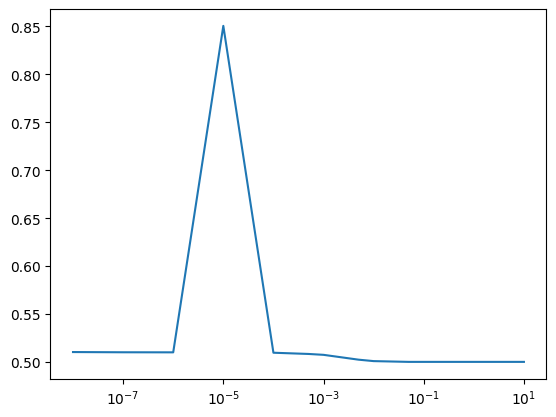

In [137]:
plt.plot(x,y)
plt.xscale("log")

In [295]:
DPfalse_res_acc = {}
DPfalse_res_rec = {}
DPfalse_res_pre = {}

for best_am in best_ams:
    a_model = Net_attack(h_neurons=64, do=0, input_size=100)
    a_model = ams[best_am]
    a_model.input_size = 200  
    
    a_params = dict(tms_params)

    for key in tms:
        if 'DPFalse' not in key:
            continue
        print(key)
        rand_seed = int(key[key.find('rs')+2:key.find('_lr')])
        x_target_train, y_target_train, x_target_test, y_target_test = data_shuffle(rand_seed, X_raw, y_raw)
        model = algo.LogisticRegression_DPSGD()
        model.n_classes = n_classes
        model.theta = tms[key]
        model.train_acc = model.evaluate(x_target_train, y_target_train, acc=True)
        model.test_acc = model.evaluate(x_target_test, y_target_test, acc=True)

        attack_acc, attack_pre, attack_rec = mi_attack_test(model, a_model, x_target_train, y_target_train, x_target_test, y_target_test)
        a_params[key]['attack_acc'] = attack_acc
        a_params[key]['attack_pre'] = attack_pre
        a_params[key]['attack_rec'] = attack_rec
        print(a_params[key])

    splits = {}
    for key in a_params:
        temp = key[key.find('_lr'):]
        if temp in splits:

            splits[temp]['attack_acc'].append(a_params[key]['attack_acc'])
            splits[temp]['attack_pre'].append(a_params[key]['attack_pre'])
            splits[temp]['attack_rec'].append(a_params[key]['attack_rec'])
        else:

            splits[temp] = {}
            splits[temp]['attack_acc'] = [a_params[key]['attack_acc']]
            splits[temp]['attack_pre'] = [a_params[key]['attack_pre']]
            splits[temp]['attack_rec'] = [a_params[key]['attack_rec']]

    mean_res = {}
    for key in splits:
        mean_res[key] = {}
        for metric in splits[key]:   
            mean_res[key] [metric] = (np.mean(splits[key][metric]), np.std(splits[key][metric]))

    lr = 'lr0.001'
    it = 'iter100' 
    reg = 'reg1e-05'
    DP = 'DPFalse'
    show = f'{lr}_{it}' #f'{lr}_{it}_{reg}_{DP}'
    show1 = f'_{DP}'
    l2_res = {}
    l2_res_rec = {}
    l2_res_pre = {}
    for key in mean_res:
        if show in key and show1 in key:
            l2 = float(key[key.find('_reg')+4:key.find('_DPFalse')])
            l2_res[l2] = mean_res[key]['attack_acc']
            l2_res_rec[l2] = mean_res[key]['attack_rec']
            l2_res_pre[l2] = mean_res[key]['attack_pre']

    x = list(l2_res.keys())
    x.sort()
    DPfalse_res_acc[best_am] = [l2_res[i][0] for i in x]
    DPfalse_res_rec[best_am] = [l2_res_rec[i][0] for i in x]
    DPfalse_res_pre[best_am] = [l2_res_pre[i][0] for i in x]


rs13_lr0.001_iter100_reg0.005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 82.6 %
The accuracy of the model : 53.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8257, 'test_acc': 0.535, 'attack_acc': 0.6595, 'attack_pre': 0.695657507360157, 'attack_rec': 0.5671}
rs24_lr0.001_iter100_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 55.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.9999, 'test_acc': 0.5521, 'attack_acc': 0.6564, 'attack_pre': 0.5936751317680882, 'attack_rec': 0.9912}
rs13_lr0.001_iter100_reg0.001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.4 %
The accuracy of the model : 56.00000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8644, 'test_acc': 0.5601, 'attack_acc': 0.6853, 'attack_pre': 0.66720808518318, 'attack_rec': 0.7394}
rs13_lr0.001_iter100_reg1e-07_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.2 %
The accuracy of the model : 56.3 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-07, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8725, 'test_acc': 0.5629, 'attack_acc': 0.6864, 'attack_pre': 0.6560093739537998, 'attack_rec': 0.7838}
rs42_lr0.001_iter100_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 54.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.9999, 'test_acc': 0.5402, 'attack_acc': 0.66275, 'attack_pre': 0.5979536563346374, 'attack_rec': 0.9935}
rs13_lr0.001_iter100_reg0.05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 39.800000000000004 %
The accuracy of the model : 28.499999999999996 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.05, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.3979, 'test_acc': 0.2854, 'attack_acc': 0.50095, 'attack_pre': 0.6666666666666666, 'attack_rec': 0.0038}
rs1_lr0.001_iter100_reg1e-08_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.6 %
The accuracy of the model : 55.7 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-08, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8657, 'test_acc': 0.5574, 'attack_acc': 0.694, 'attack_pre': 0.663547462485247, 'attack_rec': 0.7871}
rs13_lr0.001_iter100_reg0.01_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 76.6 %
The accuracy of the model : 50.1 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.01, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.7656, 'test_acc': 0.5015, 'attack_acc': 0.5973, 'attack_pre': 0.7142228093350946, 'attack_rec': 0.3244}
rs3_lr0.001_iter1_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 19.400000000000002 %
The accuracy of the model : 14.799999999999999 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 1, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.1935, 'test_acc': 0.1476, 'attack_acc': 0.50075, 'attack_pre': 0.7142857142857143, 'attack_rec': 0.0025}
rs1_lr0.001_iter100_reg0.01_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 78.2 %
The accuracy of the model : 50.3 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.01, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.7816, 'test_acc': 0.5028, 'attack_acc': 0.6095, 'attack_pre': 0.7359913793103449, 'attack_rec': 0.3415}
rs42_lr0.001_iter200_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 52.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 1.0, 'test_acc': 0.5256, 'attack_acc': 0.66215, 'attack_pre': 0.5983860202657606, 'attack_rec': 0.9862}
rs42_lr0.001_iter100_reg10_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.9000000000000004 %
The accuracy of the model : 2.1999999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 10, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.0293, 'test_acc': 0.0225, 'attack_acc': 0.5001, 'attack_pre': 0.625, 'attack_rec': 0.0005}
rs1_lr0.001_iter100_reg0.05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 38.9 %
The accuracy of the model : 27.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.05, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.3894, 'test_acc': 0.276, 'attack_acc': 0.50105, 'attack_pre': 0.6363636363636364, 'attack_rec': 0.0049}
rs1_lr0.001_iter100_reg10_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.4 %
The accuracy of the model : 2.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 10, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.024, 'test_acc': 0.0238, 'attack_acc': 0.50025, 'attack_pre': 0.6923076923076923, 'attack_rec': 0.0009}
rs1_lr0.001_iter100_reg1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 4.3 %
The accuracy of the model : 4.1000000000000005 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.0426, 'test_acc': 0.0411, 'attack_acc': 0.50025, 'attack_pre': 0.6923076923076923, 'attack_rec': 0.0009}
rs1_lr0.001_iter200_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 53.400000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 1.0, 'test_acc': 0.5344, 'attack_acc': 0.6616, 'attack_pre': 0.5980463535978643, 'attack_rec': 0.9857}
rs42_lr0.001_iter100_reg0.05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 39.4 %
The accuracy of the model : 27.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.05, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.3943, 'test_acc': 0.2762, 'attack_acc': 0.5011, 'attack_pre': 0.6571428571428571, 'attack_rec': 0.0046}
rs13_lr0.001_iter100_reg0.1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 21.3 %
The accuracy of the model : 17.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.2128, 'test_acc': 0.1736, 'attack_acc': 0.50025, 'attack_pre': 0.5609756097560976, 'attack_rec': 0.0023}
rs3_lr0.001_iter100_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 54.800000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.9999, 'test_acc': 0.5477, 'attack_acc': 0.65785, 'attack_pre': 0.5947194719471948, 'attack_rec': 0.9911}
rs13_lr0.001_iter1_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 21.5 %
The accuracy of the model : 17.9 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 1, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.2147, 'test_acc': 0.179, 'attack_acc': 0.5004, 'attack_pre': 0.5909090909090909, 'attack_rec': 0.0026}
rs42_lr0.001_iter100_reg0.01_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 77.5 %
The accuracy of the model : 49.8 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.01, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.7754, 'test_acc': 0.4985, 'attack_acc': 0.6096, 'attack_pre': 0.7346895074946467, 'attack_rec': 0.3431}
rs13_lr0.001_iter100_reg1e-06_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.0 %
The accuracy of the model : 56.10000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8698, 'test_acc': 0.5609, 'attack_acc': 0.68715, 'attack_pre': 0.6570445581941764, 'attack_rec': 0.783}
rs1_lr0.001_iter100_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 54.800000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.9997, 'test_acc': 0.5478, 'attack_acc': 0.66205, 'attack_pre': 0.5975323502858862, 'attack_rec': 0.9928}
rs42_lr0.001_iter100_reg0.0001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.5 %
The accuracy of the model : 55.400000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8748, 'test_acc': 0.5545, 'attack_acc': 0.6925, 'attack_pre': 0.6610609103078983, 'attack_rec': 0.7901}
rs13_lr0.001_iter100_reg0.0005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.5 %
The accuracy of the model : 56.00000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.865, 'test_acc': 0.5598, 'attack_acc': 0.68765, 'attack_pre': 0.6627634660421545, 'attack_rec': 0.7641}
rs1_lr0.001_iter100_reg0.1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 19.8 %
The accuracy of the model : 15.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.1984, 'test_acc': 0.1536, 'attack_acc': 0.50035, 'attack_pre': 0.6521739130434783, 'attack_rec': 0.0015}
rs1_lr0.001_iter1_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 22.1 %
The accuracy of the model : 17.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 1, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.2206, 'test_acc': 0.1741, 'attack_acc': 0.5003, 'attack_pre': 0.7142857142857143, 'attack_rec': 0.001}
rs42_lr0.001_iter100_reg0.0005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.9 %
The accuracy of the model : 54.800000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8688, 'test_acc': 0.5478, 'attack_acc': 0.6912, 'attack_pre': 0.6658570437196392, 'attack_rec': 0.7676}
rs13_lr0.001_iter100_reg0.0001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.9 %
The accuracy of the model : 56.00000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8693, 'test_acc': 0.5597, 'attack_acc': 0.68625, 'attack_pre': 0.6582009683173363, 'attack_rec': 0.7749}
rs42_lr0.001_iter100_reg1e-08_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.3 %
The accuracy of the model : 55.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-08, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8726, 'test_acc': 0.5517, 'attack_acc': 0.68955, 'attack_pre': 0.6584998745714524, 'attack_rec': 0.7875}
rs13_lr0.001_iter100_reg1e-08_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.0 %
The accuracy of the model : 55.800000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-08, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8699, 'test_acc': 0.5581, 'attack_acc': 0.6855, 'attack_pre': 0.6566722972972973, 'attack_rec': 0.7775}
rs1_lr0.001_iter100_reg0.005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 83.3 %
The accuracy of the model : 53.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8331, 'test_acc': 0.5349, 'attack_acc': 0.66745, 'attack_pre': 0.7055862492326581, 'attack_rec': 0.5747}
rs1_lr0.001_iter100_reg0.001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.1 %
The accuracy of the model : 55.400000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8612, 'test_acc': 0.5542, 'attack_acc': 0.69265, 'attack_pre': 0.6726718651967375, 'attack_rec': 0.7505}
rs42_lr0.001_iter100_reg1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.2 %
The accuracy of the model : 2.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.0325, 'test_acc': 0.0248, 'attack_acc': 0.5001, 'attack_pre': 0.625, 'attack_rec': 0.0005}
rs42_lr0.001_iter100_reg1e-06_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.4 %
The accuracy of the model : 55.00000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8736, 'test_acc': 0.5502, 'attack_acc': 0.69055, 'attack_pre': 0.6612780363944138, 'attack_rec': 0.7813}
rs1_lr0.001_iter100_reg1e-07_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.9 %
The accuracy of the model : 56.10000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-07, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8691, 'test_acc': 0.5614, 'attack_acc': 0.69185, 'attack_pre': 0.6607995976866985, 'attack_rec': 0.7884}
rs24_lr0.001_iter1_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 19.900000000000002 %
The accuracy of the model : 16.400000000000002 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 1, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.1989, 'test_acc': 0.1644, 'attack_acc': 0.50015, 'attack_pre': 0.6666666666666666, 'attack_rec': 0.0006}
rs13_lr0.001_iter100_reg1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.6999999999999997 %
The accuracy of the model : 3.3000000000000003 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.037, 'test_acc': 0.0332, 'attack_acc': 0.4999, 'attack_pre': 0.42857142857142855, 'attack_rec': 0.0006}
rs1_lr0.001_iter100_reg0.0001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.0 %
The accuracy of the model : 56.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8696, 'test_acc': 0.5615, 'attack_acc': 0.6954, 'attack_pre': 0.665285061749281, 'attack_rec': 0.7865}
rs42_lr0.001_iter1_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 19.8 %
The accuracy of the model : 15.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 1, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.1981, 'test_acc': 0.1539, 'attack_acc': 0.5004, 'attack_pre': 0.6333333333333333, 'attack_rec': 0.0019}
rs42_lr0.001_iter100_reg0.001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.6 %
The accuracy of the model : 54.900000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8658, 'test_acc': 0.5489, 'attack_acc': 0.6905, 'attack_pre': 0.670515574650913, 'attack_rec': 0.7491}
rs1_lr0.001_iter100_reg1e-06_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.0 %
The accuracy of the model : 56.39999999999999 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8699, 'test_acc': 0.5636, 'attack_acc': 0.6927, 'attack_pre': 0.6620689655172414, 'attack_rec': 0.7872}
rs13_lr0.001_iter100_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 55.400000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.9998, 'test_acc': 0.5536, 'attack_acc': 0.65865, 'attack_pre': 0.5952109464082098, 'attack_rec': 0.9918}
rs42_lr0.001_iter100_reg1e-07_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.4 %
The accuracy of the model : 54.900000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-07, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8737, 'test_acc': 0.5488, 'attack_acc': 0.6917, 'attack_pre': 0.6615267947421638, 'attack_rec': 0.7851}
rs1_lr0.001_iter100_reg0.0005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.6 %
The accuracy of the model : 56.00000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8662, 'test_acc': 0.5597, 'attack_acc': 0.69215, 'attack_pre': 0.6654611211573237, 'attack_rec': 0.7728}
rs42_lr0.001_iter100_reg0.005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 82.69999999999999 %
The accuracy of the model : 52.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8271, 'test_acc': 0.5255, 'attack_acc': 0.6695, 'attack_pre': 0.7085383858267716, 'attack_rec': 0.5759}
rs42_lr0.001_iter100_reg0.1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 21.8 %
The accuracy of the model : 16.900000000000002 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.2185, 'test_acc': 0.1688, 'attack_acc': 0.5001, 'attack_pre': 0.625, 'attack_rec': 0.0005}
rs13_lr0.001_iter100_reg10_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.5 %
The accuracy of the model : 2.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 10, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.0253, 'test_acc': 0.0242, 'attack_acc': 0.4999, 'attack_pre': 0.42857142857142855, 'attack_rec': 0.0006}
rs13_lr0.001_iter200_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 54.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 1.0, 'test_acc': 0.5396, 'attack_acc': 0.65985, 'attack_pre': 0.5970965194678977, 'attack_rec': 0.983}
rs13_lr0.001_iter100_reg0.005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 82.6 %
The accuracy of the model : 53.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8257, 'test_acc': 0.535, 'attack_acc': 0.6542, 'attack_pre': 0.6857831325301205, 'attack_rec': 0.5692}
rs24_lr0.001_iter100_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 55.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.9999, 'test_acc': 0.5521, 'attack_acc': 0.66145, 'attack_pre': 0.597042736070205, 'attack_rec': 0.9933}
rs13_lr0.001_iter100_reg0.001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.4 %
The accuracy of the model : 56.00000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8644, 'test_acc': 0.5601, 'attack_acc': 0.6833, 'attack_pre': 0.6623848334514528, 'attack_rec': 0.7477}
rs13_lr0.001_iter100_reg1e-07_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.2 %
The accuracy of the model : 56.3 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-07, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8725, 'test_acc': 0.5629, 'attack_acc': 0.6864, 'attack_pre': 0.6555407209612817, 'attack_rec': 0.7856}
rs42_lr0.001_iter100_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 54.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.9999, 'test_acc': 0.5402, 'attack_acc': 0.66385, 'attack_pre': 0.5987821788147344, 'attack_rec': 0.9932}
rs13_lr0.001_iter100_reg0.05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 39.800000000000004 %
The accuracy of the model : 28.499999999999996 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.05, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.3979, 'test_acc': 0.2854, 'attack_acc': 0.501, 'attack_pre': 0.6724137931034483, 'attack_rec': 0.0039}
rs1_lr0.001_iter100_reg1e-08_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.6 %
The accuracy of the model : 55.7 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-08, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8657, 'test_acc': 0.5574, 'attack_acc': 0.68945, 'attack_pre': 0.6593757886767057, 'attack_rec': 0.7838}
rs13_lr0.001_iter100_reg0.01_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 76.6 %
The accuracy of the model : 50.1 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.01, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.7656, 'test_acc': 0.5015, 'attack_acc': 0.5991, 'attack_pre': 0.7082807902480034, 'attack_rec': 0.337}
rs3_lr0.001_iter1_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 19.400000000000002 %
The accuracy of the model : 14.799999999999999 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 1, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.1935, 'test_acc': 0.1476, 'attack_acc': 0.5005, 'attack_pre': 0.6923076923076923, 'attack_rec': 0.0018}
rs1_lr0.001_iter100_reg0.01_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 78.2 %
The accuracy of the model : 50.3 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.01, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.7816, 'test_acc': 0.5028, 'attack_acc': 0.60715, 'attack_pre': 0.7312756313403842, 'attack_rec': 0.3388}
rs42_lr0.001_iter200_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 52.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 1.0, 'test_acc': 0.5256, 'attack_acc': 0.6656, 'attack_pre': 0.6004610531424411, 'attack_rec': 0.9898}
rs42_lr0.001_iter100_reg10_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.9000000000000004 %
The accuracy of the model : 2.1999999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 10, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.0293, 'test_acc': 0.0225, 'attack_acc': 0.5001, 'attack_pre': 0.625, 'attack_rec': 0.0005}
rs1_lr0.001_iter100_reg0.05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 38.9 %
The accuracy of the model : 27.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.05, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.3894, 'test_acc': 0.276, 'attack_acc': 0.50095, 'attack_pre': 0.6172839506172839, 'attack_rec': 0.005}
rs1_lr0.001_iter100_reg10_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.4 %
The accuracy of the model : 2.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 10, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.024, 'test_acc': 0.0238, 'attack_acc': 0.50025, 'attack_pre': 0.6923076923076923, 'attack_rec': 0.0009}
rs1_lr0.001_iter100_reg1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 4.3 %
The accuracy of the model : 4.1000000000000005 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.0426, 'test_acc': 0.0411, 'attack_acc': 0.50025, 'attack_pre': 0.6923076923076923, 'attack_rec': 0.0009}
rs1_lr0.001_iter200_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 53.400000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 1.0, 'test_acc': 0.5344, 'attack_acc': 0.66675, 'attack_pre': 0.60153443341655, 'attack_rec': 0.9879}
rs42_lr0.001_iter100_reg0.05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 39.4 %
The accuracy of the model : 27.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.05, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.3943, 'test_acc': 0.2762, 'attack_acc': 0.5011, 'attack_pre': 0.6410256410256411, 'attack_rec': 0.005}
rs13_lr0.001_iter100_reg0.1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 21.3 %
The accuracy of the model : 17.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.2128, 'test_acc': 0.1736, 'attack_acc': 0.50025, 'attack_pre': 0.5609756097560976, 'attack_rec': 0.0023}
rs3_lr0.001_iter100_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 54.800000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.9999, 'test_acc': 0.5477, 'attack_acc': 0.6649, 'attack_pre': 0.5996133864926906, 'attack_rec': 0.9926}
rs13_lr0.001_iter1_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 21.5 %
The accuracy of the model : 17.9 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 1, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.2147, 'test_acc': 0.179, 'attack_acc': 0.50035, 'attack_pre': 0.5813953488372093, 'attack_rec': 0.0025}
rs42_lr0.001_iter100_reg0.01_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 77.5 %
The accuracy of the model : 49.8 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.01, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.7754, 'test_acc': 0.4985, 'attack_acc': 0.61205, 'attack_pre': 0.7332916926920675, 'attack_rec': 0.3522}
rs13_lr0.001_iter100_reg1e-06_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.0 %
The accuracy of the model : 56.10000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8698, 'test_acc': 0.5609, 'attack_acc': 0.6871, 'attack_pre': 0.6558127914723517, 'attack_rec': 0.7875}
rs1_lr0.001_iter100_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 54.800000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.9997, 'test_acc': 0.5478, 'attack_acc': 0.66475, 'attack_pre': 0.5996130358546466, 'attack_rec': 0.9917}
rs42_lr0.001_iter100_reg0.0001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.5 %
The accuracy of the model : 55.400000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8748, 'test_acc': 0.5545, 'attack_acc': 0.6914, 'attack_pre': 0.6603821015585721, 'attack_rec': 0.7881}
rs13_lr0.001_iter100_reg0.0005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.5 %
The accuracy of the model : 56.00000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.865, 'test_acc': 0.5598, 'attack_acc': 0.6861, 'attack_pre': 0.6602928509905254, 'attack_rec': 0.7666}
rs1_lr0.001_iter100_reg0.1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 19.8 %
The accuracy of the model : 15.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.1984, 'test_acc': 0.1536, 'attack_acc': 0.5004, 'attack_pre': 0.6538461538461539, 'attack_rec': 0.0017}
rs1_lr0.001_iter1_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 22.1 %
The accuracy of the model : 17.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 1, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.2206, 'test_acc': 0.1741, 'attack_acc': 0.5003, 'attack_pre': 0.6875, 'attack_rec': 0.0011}
rs42_lr0.001_iter100_reg0.0005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.9 %
The accuracy of the model : 54.800000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8688, 'test_acc': 0.5478, 'attack_acc': 0.6921, 'attack_pre': 0.6652330982281094, 'attack_rec': 0.7734}
rs13_lr0.001_iter100_reg0.0001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.9 %
The accuracy of the model : 56.00000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8693, 'test_acc': 0.5597, 'attack_acc': 0.6851, 'attack_pre': 0.6549472626820693, 'attack_rec': 0.7824}
rs42_lr0.001_iter100_reg1e-08_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.3 %
The accuracy of the model : 55.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-08, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8726, 'test_acc': 0.5517, 'attack_acc': 0.69075, 'attack_pre': 0.6584960531782301, 'attack_rec': 0.7925}
rs13_lr0.001_iter100_reg1e-08_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.0 %
The accuracy of the model : 55.800000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-08, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8699, 'test_acc': 0.5581, 'attack_acc': 0.685, 'attack_pre': 0.655045256453235, 'attack_rec': 0.7816}
rs1_lr0.001_iter100_reg0.005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 83.3 %
The accuracy of the model : 53.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8331, 'test_acc': 0.5349, 'attack_acc': 0.66405, 'attack_pre': 0.7004765978247587, 'attack_rec': 0.5732}
rs1_lr0.001_iter100_reg0.001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.1 %
The accuracy of the model : 55.400000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8612, 'test_acc': 0.5542, 'attack_acc': 0.68935, 'attack_pre': 0.6687461010605116, 'attack_rec': 0.7504}
rs42_lr0.001_iter100_reg1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.2 %
The accuracy of the model : 2.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.0325, 'test_acc': 0.0248, 'attack_acc': 0.5001, 'attack_pre': 0.625, 'attack_rec': 0.0005}
rs42_lr0.001_iter100_reg1e-06_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.4 %
The accuracy of the model : 55.00000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8736, 'test_acc': 0.5502, 'attack_acc': 0.69185, 'attack_pre': 0.6603962879357913, 'attack_rec': 0.7899}
rs1_lr0.001_iter100_reg1e-07_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.9 %
The accuracy of the model : 56.10000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-07, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8691, 'test_acc': 0.5614, 'attack_acc': 0.68815, 'attack_pre': 0.6579367077982037, 'attack_rec': 0.7838}
rs24_lr0.001_iter1_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 19.900000000000002 %
The accuracy of the model : 16.400000000000002 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 1, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.1989, 'test_acc': 0.1644, 'attack_acc': 0.5001, 'attack_pre': 0.6, 'attack_rec': 0.0006}
rs13_lr0.001_iter100_reg1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.6999999999999997 %
The accuracy of the model : 3.3000000000000003 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.037, 'test_acc': 0.0332, 'attack_acc': 0.4999, 'attack_pre': 0.42857142857142855, 'attack_rec': 0.0006}
rs1_lr0.001_iter100_reg0.0001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.0 %
The accuracy of the model : 56.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8696, 'test_acc': 0.5615, 'attack_acc': 0.6906, 'attack_pre': 0.6609525418003716, 'attack_rec': 0.7827}
rs42_lr0.001_iter1_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 19.8 %
The accuracy of the model : 15.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 1, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.1981, 'test_acc': 0.1539, 'attack_acc': 0.5004, 'attack_pre': 0.6111111111111112, 'attack_rec': 0.0022}
rs42_lr0.001_iter100_reg0.001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.6 %
The accuracy of the model : 54.900000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8658, 'test_acc': 0.5489, 'attack_acc': 0.69235, 'attack_pre': 0.6708411048938627, 'attack_rec': 0.7553}
rs1_lr0.001_iter100_reg1e-06_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.0 %
The accuracy of the model : 56.39999999999999 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8699, 'test_acc': 0.5636, 'attack_acc': 0.68885, 'attack_pre': 0.6577035490605428, 'attack_rec': 0.7876}
rs13_lr0.001_iter100_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 55.400000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.9998, 'test_acc': 0.5536, 'attack_acc': 0.6618, 'attack_pre': 0.5973994702624609, 'attack_rec': 0.9924}
rs42_lr0.001_iter100_reg1e-07_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.4 %
The accuracy of the model : 54.900000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-07, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8737, 'test_acc': 0.5488, 'attack_acc': 0.6889, 'attack_pre': 0.6571024617431803, 'attack_rec': 0.7901}
rs1_lr0.001_iter100_reg0.0005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.6 %
The accuracy of the model : 56.00000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8662, 'test_acc': 0.5597, 'attack_acc': 0.6895, 'attack_pre': 0.661938130234148, 'attack_rec': 0.7746}
rs42_lr0.001_iter100_reg0.005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 82.69999999999999 %
The accuracy of the model : 52.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8271, 'test_acc': 0.5255, 'attack_acc': 0.66985, 'attack_pre': 0.7052567975830816, 'attack_rec': 0.5836}
rs42_lr0.001_iter100_reg0.1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 21.8 %
The accuracy of the model : 16.900000000000002 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.2185, 'test_acc': 0.1688, 'attack_acc': 0.5001, 'attack_pre': 0.625, 'attack_rec': 0.0005}
rs13_lr0.001_iter100_reg10_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.5 %
The accuracy of the model : 2.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 10, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.0253, 'test_acc': 0.0242, 'attack_acc': 0.4999, 'attack_pre': 0.42857142857142855, 'attack_rec': 0.0006}
rs13_lr0.001_iter200_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 54.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 1.0, 'test_acc': 0.5396, 'attack_acc': 0.66525, 'attack_pre': 0.600449820679594, 'attack_rec': 0.9878}
rs13_lr0.001_iter100_reg0.005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 82.6 %
The accuracy of the model : 53.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8257, 'test_acc': 0.535, 'attack_acc': 0.65595, 'attack_pre': 0.6926973928086, 'attack_rec': 0.5606}
rs24_lr0.001_iter100_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 55.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.9999, 'test_acc': 0.5521, 'attack_acc': 0.6531, 'attack_pre': 0.5905917159763313, 'attack_rec': 0.9981}
rs13_lr0.001_iter100_reg0.001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.4 %
The accuracy of the model : 56.00000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8644, 'test_acc': 0.5601, 'attack_acc': 0.68235, 'attack_pre': 0.6635279347143754, 'attack_rec': 0.7399}
rs13_lr0.001_iter100_reg1e-07_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.2 %
The accuracy of the model : 56.3 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-07, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8725, 'test_acc': 0.5629, 'attack_acc': 0.68595, 'attack_pre': 0.6568271906890445, 'attack_rec': 0.7788}
rs42_lr0.001_iter100_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 54.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.9999, 'test_acc': 0.5402, 'attack_acc': 0.65275, 'attack_pre': 0.5904649096831507, 'attack_rec': 0.997}
rs13_lr0.001_iter100_reg0.05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 39.800000000000004 %
The accuracy of the model : 28.499999999999996 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.05, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.3979, 'test_acc': 0.2854, 'attack_acc': 0.50095, 'attack_pre': 0.6862745098039216, 'attack_rec': 0.0035}
rs1_lr0.001_iter100_reg1e-08_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.6 %
The accuracy of the model : 55.7 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-08, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8657, 'test_acc': 0.5574, 'attack_acc': 0.68985, 'attack_pre': 0.6579845219272697, 'attack_rec': 0.7907}
rs13_lr0.001_iter100_reg0.01_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 76.6 %
The accuracy of the model : 50.1 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.01, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.7656, 'test_acc': 0.5015, 'attack_acc': 0.59485, 'attack_pre': 0.7124300111982083, 'attack_rec': 0.3181}
rs3_lr0.001_iter1_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 19.400000000000002 %
The accuracy of the model : 14.799999999999999 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 1, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.1935, 'test_acc': 0.1476, 'attack_acc': 0.5007, 'attack_pre': 0.7058823529411765, 'attack_rec': 0.0024}
rs1_lr0.001_iter100_reg0.01_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 78.2 %
The accuracy of the model : 50.3 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.01, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.7816, 'test_acc': 0.5028, 'attack_acc': 0.6055, 'attack_pre': 0.7272727272727273, 'attack_rec': 0.3376}
rs42_lr0.001_iter200_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 52.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 1.0, 'test_acc': 0.5256, 'attack_acc': 0.65445, 'attack_pre': 0.5918634390055314, 'attack_rec': 0.9951}
rs42_lr0.001_iter100_reg10_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.9000000000000004 %
The accuracy of the model : 2.1999999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 10, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.0293, 'test_acc': 0.0225, 'attack_acc': 0.5001, 'attack_pre': 0.625, 'attack_rec': 0.0005}
rs1_lr0.001_iter100_reg0.05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 38.9 %
The accuracy of the model : 27.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.05, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.3894, 'test_acc': 0.276, 'attack_acc': 0.5008, 'attack_pre': 0.6212121212121212, 'attack_rec': 0.0041}
rs1_lr0.001_iter100_reg10_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.4 %
The accuracy of the model : 2.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 10, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.024, 'test_acc': 0.0238, 'attack_acc': 0.50025, 'attack_pre': 0.6923076923076923, 'attack_rec': 0.0009}
rs1_lr0.001_iter100_reg1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 4.3 %
The accuracy of the model : 4.1000000000000005 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.0426, 'test_acc': 0.0411, 'attack_acc': 0.50025, 'attack_pre': 0.6923076923076923, 'attack_rec': 0.0009}
rs1_lr0.001_iter200_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 53.400000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 1.0, 'test_acc': 0.5344, 'attack_acc': 0.652, 'attack_pre': 0.5900900900900901, 'attack_rec': 0.9956}
rs42_lr0.001_iter100_reg0.05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 39.4 %
The accuracy of the model : 27.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.05, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.3943, 'test_acc': 0.2762, 'attack_acc': 0.5008, 'attack_pre': 0.6379310344827587, 'attack_rec': 0.0037}
rs13_lr0.001_iter100_reg0.1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 21.3 %
The accuracy of the model : 17.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.2128, 'test_acc': 0.1736, 'attack_acc': 0.5002, 'attack_pre': 0.5526315789473685, 'attack_rec': 0.0021}
rs3_lr0.001_iter100_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 54.800000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.9999, 'test_acc': 0.5477, 'attack_acc': 0.6517, 'attack_pre': 0.5897102306327617, 'attack_rec': 0.9972}
rs13_lr0.001_iter1_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 21.5 %
The accuracy of the model : 17.9 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 1, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.2147, 'test_acc': 0.179, 'attack_acc': 0.5003, 'attack_pre': 0.5714285714285714, 'attack_rec': 0.0024}
rs42_lr0.001_iter100_reg0.01_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 77.5 %
The accuracy of the model : 49.8 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.01, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.7754, 'test_acc': 0.4985, 'attack_acc': 0.6109, 'attack_pre': 0.7377787307032591, 'attack_rec': 0.3441}
rs13_lr0.001_iter100_reg1e-06_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.0 %
The accuracy of the model : 56.10000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8698, 'test_acc': 0.5609, 'attack_acc': 0.68595, 'attack_pre': 0.6558022622538752, 'attack_rec': 0.7827}
rs1_lr0.001_iter100_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 54.800000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.9997, 'test_acc': 0.5478, 'attack_acc': 0.6496, 'attack_pre': 0.5883012631330421, 'attack_rec': 0.9967}
rs42_lr0.001_iter100_reg0.0001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.5 %
The accuracy of the model : 55.400000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8748, 'test_acc': 0.5545, 'attack_acc': 0.6915, 'attack_pre': 0.6584740152267461, 'attack_rec': 0.7957}
rs13_lr0.001_iter100_reg0.0005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.5 %
The accuracy of the model : 56.00000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.865, 'test_acc': 0.5598, 'attack_acc': 0.6877, 'attack_pre': 0.6620898100172712, 'attack_rec': 0.7667}
rs1_lr0.001_iter100_reg0.1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 19.8 %
The accuracy of the model : 15.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.1984, 'test_acc': 0.1536, 'attack_acc': 0.5002, 'attack_pre': 0.6428571428571429, 'attack_rec': 0.0009}
rs1_lr0.001_iter1_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 22.1 %
The accuracy of the model : 17.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 1, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.2206, 'test_acc': 0.1741, 'attack_acc': 0.50025, 'attack_pre': 0.6666666666666666, 'attack_rec': 0.001}
rs42_lr0.001_iter100_reg0.0005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.9 %
The accuracy of the model : 54.800000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8688, 'test_acc': 0.5478, 'attack_acc': 0.69165, 'attack_pre': 0.6644076520545595, 'attack_rec': 0.7745}
rs13_lr0.001_iter100_reg0.0001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.9 %
The accuracy of the model : 56.00000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8693, 'test_acc': 0.5597, 'attack_acc': 0.68585, 'attack_pre': 0.6568486792134357, 'attack_rec': 0.7783}
rs42_lr0.001_iter100_reg1e-08_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.3 %
The accuracy of the model : 55.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-08, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8726, 'test_acc': 0.5517, 'attack_acc': 0.6908, 'attack_pre': 0.6578947368421053, 'attack_rec': 0.795}
rs13_lr0.001_iter100_reg1e-08_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.0 %
The accuracy of the model : 55.800000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-08, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8699, 'test_acc': 0.5581, 'attack_acc': 0.68365, 'attack_pre': 0.6547047426501559, 'attack_rec': 0.7772}
rs1_lr0.001_iter100_reg0.005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 83.3 %
The accuracy of the model : 53.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8331, 'test_acc': 0.5349, 'attack_acc': 0.6636, 'attack_pre': 0.6995121951219512, 'attack_rec': 0.5736}
rs1_lr0.001_iter100_reg0.001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.1 %
The accuracy of the model : 55.400000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8612, 'test_acc': 0.5542, 'attack_acc': 0.6876, 'attack_pre': 0.6652863436123349, 'attack_rec': 0.7551}
rs42_lr0.001_iter100_reg1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.2 %
The accuracy of the model : 2.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.0325, 'test_acc': 0.0248, 'attack_acc': 0.5001, 'attack_pre': 0.625, 'attack_rec': 0.0005}
rs42_lr0.001_iter100_reg1e-06_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.4 %
The accuracy of the model : 55.00000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8736, 'test_acc': 0.5502, 'attack_acc': 0.6915, 'attack_pre': 0.6590003321155762, 'attack_rec': 0.7937}
rs1_lr0.001_iter100_reg1e-07_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.9 %
The accuracy of the model : 56.10000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-07, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8691, 'test_acc': 0.5614, 'attack_acc': 0.68945, 'attack_pre': 0.6572851805728518, 'attack_rec': 0.7917}
rs24_lr0.001_iter1_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 19.900000000000002 %
The accuracy of the model : 16.400000000000002 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 1, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.1989, 'test_acc': 0.1644, 'attack_acc': 0.50015, 'attack_pre': 0.6666666666666666, 'attack_rec': 0.0006}
rs13_lr0.001_iter100_reg1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.6999999999999997 %
The accuracy of the model : 3.3000000000000003 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.037, 'test_acc': 0.0332, 'attack_acc': 0.4999, 'attack_pre': 0.42857142857142855, 'attack_rec': 0.0006}
rs1_lr0.001_iter100_reg0.0001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.0 %
The accuracy of the model : 56.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8696, 'test_acc': 0.5615, 'attack_acc': 0.6881, 'attack_pre': 0.6574058577405858, 'attack_rec': 0.7856}
rs42_lr0.001_iter1_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 19.8 %
The accuracy of the model : 15.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 1, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.1981, 'test_acc': 0.1539, 'attack_acc': 0.50025, 'attack_pre': 0.6, 'attack_rec': 0.0015}
rs42_lr0.001_iter100_reg0.001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.6 %
The accuracy of the model : 54.900000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8658, 'test_acc': 0.5489, 'attack_acc': 0.69065, 'attack_pre': 0.6682255360451778, 'attack_rec': 0.7573}
rs1_lr0.001_iter100_reg1e-06_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.0 %
The accuracy of the model : 56.39999999999999 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8699, 'test_acc': 0.5636, 'attack_acc': 0.68875, 'attack_pre': 0.6571999666860998, 'attack_rec': 0.7891}
rs13_lr0.001_iter100_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 55.400000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.9998, 'test_acc': 0.5536, 'attack_acc': 0.65205, 'attack_pre': 0.5899757382093616, 'attack_rec': 0.997}
rs42_lr0.001_iter100_reg1e-07_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.4 %
The accuracy of the model : 54.900000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-07, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8737, 'test_acc': 0.5488, 'attack_acc': 0.691, 'attack_pre': 0.6584273390842734, 'attack_rec': 0.7938}
rs1_lr0.001_iter100_reg0.0005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.6 %
The accuracy of the model : 56.00000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8662, 'test_acc': 0.5597, 'attack_acc': 0.6868, 'attack_pre': 0.6584124830393487, 'attack_rec': 0.7764}
rs42_lr0.001_iter100_reg0.005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 82.69999999999999 %
The accuracy of the model : 52.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8271, 'test_acc': 0.5255, 'attack_acc': 0.6688, 'attack_pre': 0.7064074345805821, 'attack_rec': 0.5777}
rs42_lr0.001_iter100_reg0.1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 21.8 %
The accuracy of the model : 16.900000000000002 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.2185, 'test_acc': 0.1688, 'attack_acc': 0.5001, 'attack_pre': 0.625, 'attack_rec': 0.0005}
rs13_lr0.001_iter100_reg10_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.5 %
The accuracy of the model : 2.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 10, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.0253, 'test_acc': 0.0242, 'attack_acc': 0.4999, 'attack_pre': 0.42857142857142855, 'attack_rec': 0.0006}
rs13_lr0.001_iter200_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 54.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 1.0, 'test_acc': 0.5396, 'attack_acc': 0.6552, 'attack_pre': 0.5922930542340628, 'attack_rec': 0.996}
rs13_lr0.001_iter100_reg0.005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 82.6 %
The accuracy of the model : 53.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8257, 'test_acc': 0.535, 'attack_acc': 0.6268, 'attack_pre': 0.6636973922024271, 'attack_rec': 0.5141}
rs24_lr0.001_iter100_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 55.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.9999, 'test_acc': 0.5521, 'attack_acc': 0.65745, 'attack_pre': 0.5962114268255423, 'attack_rec': 0.9757}
rs13_lr0.001_iter100_reg0.001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.4 %
The accuracy of the model : 56.00000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8644, 'test_acc': 0.5601, 'attack_acc': 0.6526, 'attack_pre': 0.6480690859693382, 'attack_rec': 0.6679}
rs13_lr0.001_iter100_reg1e-07_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.2 %
The accuracy of the model : 56.3 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-07, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8725, 'test_acc': 0.5629, 'attack_acc': 0.6574, 'attack_pre': 0.642520825787758, 'attack_rec': 0.7096}
rs42_lr0.001_iter100_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 54.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.9999, 'test_acc': 0.5402, 'attack_acc': 0.6574, 'attack_pre': 0.5957420924574209, 'attack_rec': 0.9794}
rs13_lr0.001_iter100_reg0.05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 39.800000000000004 %
The accuracy of the model : 28.499999999999996 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.05, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.3979, 'test_acc': 0.2854, 'attack_acc': 0.5009, 'attack_pre': 0.5188284518828452, 'attack_rec': 0.0248}
rs1_lr0.001_iter100_reg1e-08_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.6 %
The accuracy of the model : 55.7 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-08, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8657, 'test_acc': 0.5574, 'attack_acc': 0.66175, 'attack_pre': 0.6471390885108705, 'attack_rec': 0.7114}
rs13_lr0.001_iter100_reg0.01_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 76.6 %
The accuracy of the model : 50.1 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.01, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.7656, 'test_acc': 0.5015, 'attack_acc': 0.5857, 'attack_pre': 0.6739748274462039, 'attack_rec': 0.332}
rs3_lr0.001_iter1_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 19.400000000000002 %
The accuracy of the model : 14.799999999999999 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 1, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.1935, 'test_acc': 0.1476, 'attack_acc': 0.49975, 'attack_pre': 0.4940898345153664, 'attack_rec': 0.0209}
rs1_lr0.001_iter100_reg0.01_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 78.2 %
The accuracy of the model : 50.3 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.01, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.7816, 'test_acc': 0.5028, 'attack_acc': 0.5899, 'attack_pre': 0.6892631578947368, 'attack_rec': 0.3274}
rs42_lr0.001_iter200_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 52.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 1.0, 'test_acc': 0.5256, 'attack_acc': 0.6559, 'attack_pre': 0.59515380859375, 'attack_rec': 0.9751}
rs42_lr0.001_iter100_reg10_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.9000000000000004 %
The accuracy of the model : 2.1999999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 10, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.0293, 'test_acc': 0.0225, 'attack_acc': 0.49895, 'attack_pre': 0.4600760456273764, 'attack_rec': 0.0121}
rs1_lr0.001_iter100_reg0.05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 38.9 %
The accuracy of the model : 27.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.05, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.3894, 'test_acc': 0.276, 'attack_acc': 0.50145, 'attack_pre': 0.5302713987473904, 'attack_rec': 0.0254}
rs1_lr0.001_iter100_reg10_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.4 %
The accuracy of the model : 2.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 10, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.024, 'test_acc': 0.0238, 'attack_acc': 0.4999, 'attack_pre': 0.4959349593495935, 'attack_rec': 0.0122}
rs1_lr0.001_iter100_reg1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 4.3 %
The accuracy of the model : 4.1000000000000005 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.0426, 'test_acc': 0.0411, 'attack_acc': 0.50065, 'attack_pre': 0.5234657039711191, 'attack_rec': 0.0145}
rs1_lr0.001_iter200_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 53.400000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 1.0, 'test_acc': 0.5344, 'attack_acc': 0.6555, 'attack_pre': 0.5953285924472781, 'attack_rec': 0.9711}
rs42_lr0.001_iter100_reg0.05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 39.4 %
The accuracy of the model : 27.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.05, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.3943, 'test_acc': 0.2762, 'attack_acc': 0.4992, 'attack_pre': 0.4831932773109244, 'attack_rec': 0.023}
rs13_lr0.001_iter100_reg0.1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 21.3 %
The accuracy of the model : 17.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.2128, 'test_acc': 0.1736, 'attack_acc': 0.5006, 'attack_pre': 0.5128205128205128, 'attack_rec': 0.024}
rs3_lr0.001_iter100_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 54.800000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.9999, 'test_acc': 0.5477, 'attack_acc': 0.65865, 'attack_pre': 0.59675550405562, 'attack_rec': 0.9785}
rs13_lr0.001_iter1_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 21.5 %
The accuracy of the model : 17.9 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 1, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.2147, 'test_acc': 0.179, 'attack_acc': 0.50065, 'attack_pre': 0.5131313131313131, 'attack_rec': 0.0254}
rs42_lr0.001_iter100_reg0.01_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 77.5 %
The accuracy of the model : 49.8 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.01, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.7754, 'test_acc': 0.4985, 'attack_acc': 0.5915, 'attack_pre': 0.6860512403416023, 'attack_rec': 0.3374}
rs13_lr0.001_iter100_reg1e-06_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.0 %
The accuracy of the model : 56.10000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8698, 'test_acc': 0.5609, 'attack_acc': 0.6559, 'attack_pre': 0.6407293735331288, 'attack_rec': 0.7098}
rs1_lr0.001_iter100_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 54.800000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.9997, 'test_acc': 0.5478, 'attack_acc': 0.6589, 'attack_pre': 0.5972222222222222, 'attack_rec': 0.9761}
rs42_lr0.001_iter100_reg0.0001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.5 %
The accuracy of the model : 55.400000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8748, 'test_acc': 0.5545, 'attack_acc': 0.6666, 'attack_pre': 0.6509878557186877, 'attack_rec': 0.7183}
rs13_lr0.001_iter100_reg0.0005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.5 %
The accuracy of the model : 56.00000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.865, 'test_acc': 0.5598, 'attack_acc': 0.6565, 'attack_pre': 0.6459071415252657, 'attack_rec': 0.6928}
rs1_lr0.001_iter100_reg0.1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 19.8 %
The accuracy of the model : 15.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.1984, 'test_acc': 0.1536, 'attack_acc': 0.50065, 'attack_pre': 0.5138004246284501, 'attack_rec': 0.0242}
rs1_lr0.001_iter1_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 22.1 %
The accuracy of the model : 17.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 1, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.2206, 'test_acc': 0.1741, 'attack_acc': 0.5011, 'attack_pre': 0.5258215962441315, 'attack_rec': 0.0224}
rs42_lr0.001_iter100_reg0.0005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.9 %
The accuracy of the model : 54.800000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8688, 'test_acc': 0.5478, 'attack_acc': 0.663, 'attack_pre': 0.6504522798597009, 'attack_rec': 0.7047}
rs13_lr0.001_iter100_reg0.0001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.9 %
The accuracy of the model : 56.00000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8693, 'test_acc': 0.5597, 'attack_acc': 0.65535, 'attack_pre': 0.6419888492825153, 'attack_rec': 0.7024}
rs42_lr0.001_iter100_reg1e-08_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.3 %
The accuracy of the model : 55.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-08, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8726, 'test_acc': 0.5517, 'attack_acc': 0.66325, 'attack_pre': 0.6463731731372725, 'attack_rec': 0.7209}
rs13_lr0.001_iter100_reg1e-08_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.0 %
The accuracy of the model : 55.800000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-08, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8699, 'test_acc': 0.5581, 'attack_acc': 0.65655, 'attack_pre': 0.6417383431416931, 'attack_rec': 0.7088}
rs1_lr0.001_iter100_reg0.005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 83.3 %
The accuracy of the model : 53.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8331, 'test_acc': 0.5349, 'attack_acc': 0.6319, 'attack_pre': 0.6742404227212682, 'attack_rec': 0.5104}
rs1_lr0.001_iter100_reg0.001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.1 %
The accuracy of the model : 55.400000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8612, 'test_acc': 0.5542, 'attack_acc': 0.6569, 'attack_pre': 0.6512434933487565, 'attack_rec': 0.6756}
rs42_lr0.001_iter100_reg1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.2 %
The accuracy of the model : 2.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.0325, 'test_acc': 0.0248, 'attack_acc': 0.4988, 'attack_pre': 0.46153846153846156, 'attack_rec': 0.0144}
rs42_lr0.001_iter100_reg1e-06_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.4 %
The accuracy of the model : 55.00000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8736, 'test_acc': 0.5502, 'attack_acc': 0.66305, 'attack_pre': 0.6467464674646747, 'attack_rec': 0.7186}
rs1_lr0.001_iter100_reg1e-07_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.9 %
The accuracy of the model : 56.10000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-07, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8691, 'test_acc': 0.5614, 'attack_acc': 0.6584, 'attack_pre': 0.6449487554904831, 'attack_rec': 0.7048}
rs24_lr0.001_iter1_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 19.900000000000002 %
The accuracy of the model : 16.400000000000002 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 1, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.1989, 'test_acc': 0.1644, 'attack_acc': 0.5016, 'attack_pre': 0.5349344978165939, 'attack_rec': 0.0245}
rs13_lr0.001_iter100_reg1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.6999999999999997 %
The accuracy of the model : 3.3000000000000003 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.037, 'test_acc': 0.0332, 'attack_acc': 0.4996, 'attack_pre': 0.4870967741935484, 'attack_rec': 0.0151}
rs1_lr0.001_iter100_reg0.0001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.0 %
The accuracy of the model : 56.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8696, 'test_acc': 0.5615, 'attack_acc': 0.66175, 'attack_pre': 0.6474879183003556, 'attack_rec': 0.7101}
rs42_lr0.001_iter1_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 19.8 %
The accuracy of the model : 15.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 1, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.1981, 'test_acc': 0.1539, 'attack_acc': 0.49785, 'attack_pre': 0.4553014553014553, 'attack_rec': 0.0219}
rs42_lr0.001_iter100_reg0.001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.6 %
The accuracy of the model : 54.900000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8658, 'test_acc': 0.5489, 'attack_acc': 0.663, 'attack_pre': 0.6560405896994065, 'attack_rec': 0.6853}
rs1_lr0.001_iter100_reg1e-06_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.0 %
The accuracy of the model : 56.39999999999999 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8699, 'test_acc': 0.5636, 'attack_acc': 0.6618, 'attack_pre': 0.6475200583515682, 'attack_rec': 0.7102}
rs13_lr0.001_iter100_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 55.400000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.9998, 'test_acc': 0.5536, 'attack_acc': 0.65325, 'attack_pre': 0.593019726858877, 'attack_rec': 0.977}
rs42_lr0.001_iter100_reg1e-07_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.4 %
The accuracy of the model : 54.900000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-07, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8737, 'test_acc': 0.5488, 'attack_acc': 0.66565, 'attack_pre': 0.6477830314925507, 'attack_rec': 0.7261}
rs1_lr0.001_iter100_reg0.0005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.6 %
The accuracy of the model : 56.00000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8662, 'test_acc': 0.5597, 'attack_acc': 0.6602, 'attack_pre': 0.6497196261682243, 'attack_rec': 0.6952}
rs42_lr0.001_iter100_reg0.005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 82.69999999999999 %
The accuracy of the model : 52.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8271, 'test_acc': 0.5255, 'attack_acc': 0.63525, 'attack_pre': 0.6718333121585567, 'attack_rec': 0.5288}
rs42_lr0.001_iter100_reg0.1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 21.8 %
The accuracy of the model : 16.900000000000002 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.2185, 'test_acc': 0.1688, 'attack_acc': 0.49885, 'attack_pre': 0.47117794486215536, 'attack_rec': 0.0188}
rs13_lr0.001_iter100_reg10_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.5 %
The accuracy of the model : 2.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 10, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.0253, 'test_acc': 0.0242, 'attack_acc': 0.50015, 'attack_pre': 0.5063291139240507, 'attack_rec': 0.012}
rs13_lr0.001_iter200_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 54.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 1.0, 'test_acc': 0.5396, 'attack_acc': 0.6529, 'attack_pre': 0.5933797483815806, 'attack_rec': 0.9716}
rs13_lr0.001_iter100_reg0.005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 82.6 %
The accuracy of the model : 53.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8257, 'test_acc': 0.535, 'attack_acc': 0.64855, 'attack_pre': 0.7035768123886529, 'attack_rec': 0.5134}
rs24_lr0.001_iter100_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 55.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.9999, 'test_acc': 0.5521, 'attack_acc': 0.65345, 'attack_pre': 0.5906968496956085, 'attack_rec': 0.9994}
rs13_lr0.001_iter100_reg0.001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.4 %
The accuracy of the model : 56.00000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8644, 'test_acc': 0.5601, 'attack_acc': 0.6825, 'attack_pre': 0.6761583011583011, 'attack_rec': 0.7005}
rs13_lr0.001_iter100_reg1e-07_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.2 %
The accuracy of the model : 56.3 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-07, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8725, 'test_acc': 0.5629, 'attack_acc': 0.68625, 'attack_pre': 0.6683844137058133, 'attack_rec': 0.7393}
rs42_lr0.001_iter100_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 54.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.9999, 'test_acc': 0.5402, 'attack_acc': 0.6576, 'attack_pre': 0.5936089332382989, 'attack_rec': 0.9994}
rs13_lr0.001_iter100_reg0.05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 39.800000000000004 %
The accuracy of the model : 28.499999999999996 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.05, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.3979, 'test_acc': 0.2854, 'attack_acc': 0.50145, 'attack_pre': 0.6028368794326241, 'attack_rec': 0.0085}
rs1_lr0.001_iter100_reg1e-08_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.6 %
The accuracy of the model : 55.7 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-08, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8657, 'test_acc': 0.5574, 'attack_acc': 0.69285, 'attack_pre': 0.6729131175468483, 'attack_rec': 0.7505}
rs13_lr0.001_iter100_reg0.01_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 76.6 %
The accuracy of the model : 50.1 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.01, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.7656, 'test_acc': 0.5015, 'attack_acc': 0.58765, 'attack_pre': 0.7192894671003253, 'attack_rec': 0.2875}
rs3_lr0.001_iter1_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 19.400000000000002 %
The accuracy of the model : 14.799999999999999 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 1, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.1935, 'test_acc': 0.1476, 'attack_acc': 0.5001, 'attack_pre': 0.5108695652173914, 'attack_rec': 0.0047}
rs1_lr0.001_iter100_reg0.01_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 78.2 %
The accuracy of the model : 50.3 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.01, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.7816, 'test_acc': 0.5028, 'attack_acc': 0.59255, 'attack_pre': 0.7282367447595561, 'attack_rec': 0.2953}
rs42_lr0.001_iter200_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 52.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 1.0, 'test_acc': 0.5256, 'attack_acc': 0.65345, 'attack_pre': 0.5906861296613676, 'attack_rec': 0.9995}
rs42_lr0.001_iter100_reg10_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.9000000000000004 %
The accuracy of the model : 2.1999999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 10, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.0293, 'test_acc': 0.0225, 'attack_acc': 0.4998, 'attack_pre': 0.49363057324840764, 'attack_rec': 0.0155}
rs1_lr0.001_iter100_reg0.05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 38.9 %
The accuracy of the model : 27.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.05, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.3894, 'test_acc': 0.276, 'attack_acc': 0.5008, 'attack_pre': 0.5571428571428572, 'attack_rec': 0.0078}
rs1_lr0.001_iter100_reg10_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.4 %
The accuracy of the model : 2.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 10, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.024, 'test_acc': 0.0238, 'attack_acc': 0.5009, 'attack_pre': 0.5279503105590062, 'attack_rec': 0.017}
rs1_lr0.001_iter100_reg1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 4.3 %
The accuracy of the model : 4.1000000000000005 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.0426, 'test_acc': 0.0411, 'attack_acc': 0.501, 'attack_pre': 0.5581395348837209, 'attack_rec': 0.0096}
rs1_lr0.001_iter200_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 53.400000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 1.0, 'test_acc': 0.5344, 'attack_acc': 0.6508, 'attack_pre': 0.5888836496522457, 'attack_rec': 0.9991}
rs42_lr0.001_iter100_reg0.05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 39.4 %
The accuracy of the model : 27.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.05, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.3943, 'test_acc': 0.2762, 'attack_acc': 0.5014, 'attack_pre': 0.5921052631578947, 'attack_rec': 0.009}
rs13_lr0.001_iter100_reg0.1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 21.3 %
The accuracy of the model : 17.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.2128, 'test_acc': 0.1736, 'attack_acc': 0.5004, 'attack_pre': 0.5338983050847458, 'attack_rec': 0.0063}
rs3_lr0.001_iter100_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 54.800000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.9999, 'test_acc': 0.5477, 'attack_acc': 0.654, 'attack_pre': 0.5911566236533681, 'attack_rec': 0.9987}
rs13_lr0.001_iter1_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 21.5 %
The accuracy of the model : 17.9 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 1, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.2147, 'test_acc': 0.179, 'attack_acc': 0.5004, 'attack_pre': 0.5333333333333333, 'attack_rec': 0.0064}
rs42_lr0.001_iter100_reg0.01_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 77.5 %
The accuracy of the model : 49.8 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.01, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.7754, 'test_acc': 0.4985, 'attack_acc': 0.59615, 'attack_pre': 0.7311853811012262, 'attack_rec': 0.3041}
rs13_lr0.001_iter100_reg1e-06_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.0 %
The accuracy of the model : 56.10000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8698, 'test_acc': 0.5609, 'attack_acc': 0.6855, 'attack_pre': 0.668667030369158, 'attack_rec': 0.7354}
rs1_lr0.001_iter100_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 54.800000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.9997, 'test_acc': 0.5478, 'attack_acc': 0.6538, 'attack_pre': 0.5909951485031357, 'attack_rec': 0.9989}
rs42_lr0.001_iter100_reg0.0001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.5 %
The accuracy of the model : 55.400000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8748, 'test_acc': 0.5545, 'attack_acc': 0.69615, 'attack_pre': 0.6768232218516181, 'attack_rec': 0.7508}
rs13_lr0.001_iter100_reg0.0005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.5 %
The accuracy of the model : 56.00000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.865, 'test_acc': 0.5598, 'attack_acc': 0.6837, 'attack_pre': 0.6732691944916054, 'attack_rec': 0.7138}
rs1_lr0.001_iter100_reg0.1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 19.8 %
The accuracy of the model : 15.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.1984, 'test_acc': 0.1536, 'attack_acc': 0.5004, 'attack_pre': 0.5444444444444444, 'attack_rec': 0.0049}
rs1_lr0.001_iter1_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 22.1 %
The accuracy of the model : 17.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 1, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.2206, 'test_acc': 0.1741, 'attack_acc': 0.5004, 'attack_pre': 0.5476190476190477, 'attack_rec': 0.0046}
rs42_lr0.001_iter100_reg0.0005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.9 %
The accuracy of the model : 54.800000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8688, 'test_acc': 0.5478, 'attack_acc': 0.69075, 'attack_pre': 0.6787890149029899, 'attack_rec': 0.7242}
rs13_lr0.001_iter100_reg0.0001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.9 %
The accuracy of the model : 56.00000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8693, 'test_acc': 0.5597, 'attack_acc': 0.6837, 'attack_pre': 0.6674261757200146, 'attack_rec': 0.7323}
rs42_lr0.001_iter100_reg1e-08_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.3 %
The accuracy of the model : 55.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-08, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8726, 'test_acc': 0.5517, 'attack_acc': 0.6929, 'attack_pre': 0.6726328977984607, 'attack_rec': 0.7516}
rs13_lr0.001_iter100_reg1e-08_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.0 %
The accuracy of the model : 55.800000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-08, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8699, 'test_acc': 0.5581, 'attack_acc': 0.6837, 'attack_pre': 0.6675177822360022, 'attack_rec': 0.732}
rs1_lr0.001_iter100_reg0.005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 83.3 %
The accuracy of the model : 53.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8331, 'test_acc': 0.5349, 'attack_acc': 0.655, 'attack_pre': 0.7099701977783799, 'attack_rec': 0.5241}
rs1_lr0.001_iter100_reg0.001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.1 %
The accuracy of the model : 55.400000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8612, 'test_acc': 0.5542, 'attack_acc': 0.6899, 'attack_pre': 0.6832657788071801, 'attack_rec': 0.708}
rs42_lr0.001_iter100_reg1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.2 %
The accuracy of the model : 2.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.0325, 'test_acc': 0.0248, 'attack_acc': 0.50035, 'attack_pre': 0.5251798561151079, 'attack_rec': 0.0073}
rs42_lr0.001_iter100_reg1e-06_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.4 %
The accuracy of the model : 55.00000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8736, 'test_acc': 0.5502, 'attack_acc': 0.69275, 'attack_pre': 0.6733831069533147, 'attack_rec': 0.7486}
rs1_lr0.001_iter100_reg1e-07_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.9 %
The accuracy of the model : 56.10000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-07, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8691, 'test_acc': 0.5614, 'attack_acc': 0.6916, 'attack_pre': 0.6702808389619623, 'attack_rec': 0.7542}
rs24_lr0.001_iter1_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 19.900000000000002 %
The accuracy of the model : 16.400000000000002 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 1, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.1989, 'test_acc': 0.1644, 'attack_acc': 0.4998, 'attack_pre': 0.47368421052631576, 'attack_rec': 0.0036}
rs13_lr0.001_iter100_reg1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.6999999999999997 %
The accuracy of the model : 3.3000000000000003 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.037, 'test_acc': 0.0332, 'attack_acc': 0.50055, 'attack_pre': 0.5374149659863946, 'attack_rec': 0.0079}
rs1_lr0.001_iter100_reg0.0001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.0 %
The accuracy of the model : 56.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8696, 'test_acc': 0.5615, 'attack_acc': 0.69235, 'attack_pre': 0.6744987752880341, 'attack_rec': 0.7435}
rs42_lr0.001_iter1_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 19.8 %
The accuracy of the model : 15.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 1, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.1981, 'test_acc': 0.1539, 'attack_acc': 0.5006, 'attack_pre': 0.5526315789473685, 'attack_rec': 0.0063}
rs42_lr0.001_iter100_reg0.001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.6 %
The accuracy of the model : 54.900000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8658, 'test_acc': 0.5489, 'attack_acc': 0.69125, 'attack_pre': 0.6846577194168195, 'attack_rec': 0.7091}
rs1_lr0.001_iter100_reg1e-06_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.0 %
The accuracy of the model : 56.39999999999999 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8699, 'test_acc': 0.5636, 'attack_acc': 0.6904, 'attack_pre': 0.6691542288557214, 'attack_rec': 0.7532}
rs13_lr0.001_iter100_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 55.400000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.9998, 'test_acc': 0.5536, 'attack_acc': 0.6544, 'attack_pre': 0.5913933941044157, 'attack_rec': 0.9991}
rs42_lr0.001_iter100_reg1e-07_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.4 %
The accuracy of the model : 54.900000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-07, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8737, 'test_acc': 0.5488, 'attack_acc': 0.6931, 'attack_pre': 0.6738386748289521, 'attack_rec': 0.7485}
rs1_lr0.001_iter100_reg0.0005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.6 %
The accuracy of the model : 56.00000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8662, 'test_acc': 0.5597, 'attack_acc': 0.69055, 'attack_pre': 0.6759951971922047, 'attack_rec': 0.7319}
rs42_lr0.001_iter100_reg0.005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 82.69999999999999 %
The accuracy of the model : 52.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8271, 'test_acc': 0.5255, 'attack_acc': 0.65795, 'attack_pre': 0.7131866648670536, 'attack_rec': 0.5284}
rs42_lr0.001_iter100_reg0.1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 21.8 %
The accuracy of the model : 16.900000000000002 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.2185, 'test_acc': 0.1688, 'attack_acc': 0.5005, 'attack_pre': 0.5531914893617021, 'attack_rec': 0.0052}
rs13_lr0.001_iter100_reg10_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.5 %
The accuracy of the model : 2.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 10, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.0253, 'test_acc': 0.0242, 'attack_acc': 0.50155, 'attack_pre': 0.5488958990536278, 'attack_rec': 0.0174}
rs13_lr0.001_iter200_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 54.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 1.0, 'test_acc': 0.5396, 'attack_acc': 0.6527, 'attack_pre': 0.5901736152119995, 'attack_rec': 0.9994}
rs13_lr0.001_iter100_reg0.005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 82.6 %
The accuracy of the model : 53.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8257, 'test_acc': 0.535, 'attack_acc': 0.6519, 'attack_pre': 0.6954451878538342, 'attack_rec': 0.5405}
rs24_lr0.001_iter100_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 55.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.9999, 'test_acc': 0.5521, 'attack_acc': 0.6711, 'attack_pre': 0.6052404969860992, 'attack_rec': 0.984}
rs13_lr0.001_iter100_reg0.001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.4 %
The accuracy of the model : 56.00000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8644, 'test_acc': 0.5601, 'attack_acc': 0.685, 'attack_pre': 0.6724459358687547, 'attack_rec': 0.7214}
rs13_lr0.001_iter100_reg1e-07_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.2 %
The accuracy of the model : 56.3 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-07, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8725, 'test_acc': 0.5629, 'attack_acc': 0.68695, 'attack_pre': 0.6632323408713874, 'attack_rec': 0.7596}
rs42_lr0.001_iter100_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 54.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.9999, 'test_acc': 0.5402, 'attack_acc': 0.67255, 'attack_pre': 0.6060215053763441, 'attack_rec': 0.9863}
rs13_lr0.001_iter100_reg0.05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 39.800000000000004 %
The accuracy of the model : 28.499999999999996 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.05, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.3979, 'test_acc': 0.2854, 'attack_acc': 0.50095, 'attack_pre': 0.6792452830188679, 'attack_rec': 0.0036}
rs1_lr0.001_iter100_reg1e-08_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.6 %
The accuracy of the model : 55.7 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-08, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8657, 'test_acc': 0.5574, 'attack_acc': 0.69225, 'attack_pre': 0.6675965478162322, 'attack_rec': 0.7658}
rs13_lr0.001_iter100_reg0.01_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 76.6 %
The accuracy of the model : 50.1 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.01, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.7656, 'test_acc': 0.5015, 'attack_acc': 0.59415, 'attack_pre': 0.7151016678090016, 'attack_rec': 0.313}
rs3_lr0.001_iter1_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 19.400000000000002 %
The accuracy of the model : 14.799999999999999 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 1, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.1935, 'test_acc': 0.1476, 'attack_acc': 0.50035, 'attack_pre': 0.6521739130434783, 'attack_rec': 0.0015}
rs1_lr0.001_iter100_reg0.01_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 78.2 %
The accuracy of the model : 50.3 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.01, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.7816, 'test_acc': 0.5028, 'attack_acc': 0.5993, 'attack_pre': 0.7340876944837341, 'attack_rec': 0.3114}
rs42_lr0.001_iter200_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 52.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 1.0, 'test_acc': 0.5256, 'attack_acc': 0.6748, 'attack_pre': 0.6084232725468304, 'attack_rec': 0.9809}
rs42_lr0.001_iter100_reg10_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.9000000000000004 %
The accuracy of the model : 2.1999999999999997 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 10, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.0293, 'test_acc': 0.0225, 'attack_acc': 0.5001, 'attack_pre': 0.625, 'attack_rec': 0.0005}
rs1_lr0.001_iter100_reg0.05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 38.9 %
The accuracy of the model : 27.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.05, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.3894, 'test_acc': 0.276, 'attack_acc': 0.5008, 'attack_pre': 0.6111111111111112, 'attack_rec': 0.0044}
rs1_lr0.001_iter100_reg10_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.4 %
The accuracy of the model : 2.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 10, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.024, 'test_acc': 0.0238, 'attack_acc': 0.50025, 'attack_pre': 0.6923076923076923, 'attack_rec': 0.0009}
rs1_lr0.001_iter100_reg1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 4.3 %
The accuracy of the model : 4.1000000000000005 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.0426, 'test_acc': 0.0411, 'attack_acc': 0.50025, 'attack_pre': 0.6923076923076923, 'attack_rec': 0.0009}
rs1_lr0.001_iter200_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 53.400000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 1.0, 'test_acc': 0.5344, 'attack_acc': 0.675, 'attack_pre': 0.6089663760896638, 'attack_rec': 0.978}
rs42_lr0.001_iter100_reg0.05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 39.4 %
The accuracy of the model : 27.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.05, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.3943, 'test_acc': 0.2762, 'attack_acc': 0.501, 'attack_pre': 0.6470588235294118, 'attack_rec': 0.0044}
rs13_lr0.001_iter100_reg0.1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 21.3 %
The accuracy of the model : 17.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.2128, 'test_acc': 0.1736, 'attack_acc': 0.50025, 'attack_pre': 0.5609756097560976, 'attack_rec': 0.0023}
rs3_lr0.001_iter100_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 54.800000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.9999, 'test_acc': 0.5477, 'attack_acc': 0.67335, 'attack_pre': 0.6068281259629014, 'attack_rec': 0.9847}
rs13_lr0.001_iter1_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 21.5 %
The accuracy of the model : 17.9 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 1, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.2147, 'test_acc': 0.179, 'attack_acc': 0.50035, 'attack_pre': 0.5813953488372093, 'attack_rec': 0.0025}
rs42_lr0.001_iter100_reg0.01_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 77.5 %
The accuracy of the model : 49.8 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.01, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.7754, 'test_acc': 0.4985, 'attack_acc': 0.60405, 'attack_pre': 0.7376113267869376, 'attack_rec': 0.323}
rs13_lr0.001_iter100_reg1e-06_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.0 %
The accuracy of the model : 56.10000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8698, 'test_acc': 0.5609, 'attack_acc': 0.6863, 'attack_pre': 0.6621409921671019, 'attack_rec': 0.7608}
rs1_lr0.001_iter100_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 54.800000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.9997, 'test_acc': 0.5478, 'attack_acc': 0.67405, 'attack_pre': 0.607537843682422, 'attack_rec': 0.9833}
rs42_lr0.001_iter100_reg0.0001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.5 %
The accuracy of the model : 55.400000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8748, 'test_acc': 0.5545, 'attack_acc': 0.69445, 'attack_pre': 0.6698995194408038, 'attack_rec': 0.7667}
rs13_lr0.001_iter100_reg0.0005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.5 %
The accuracy of the model : 56.00000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.865, 'test_acc': 0.5598, 'attack_acc': 0.68715, 'attack_pre': 0.6681642555485668, 'attack_rec': 0.7436}
rs1_lr0.001_iter100_reg0.1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 19.8 %
The accuracy of the model : 15.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.1984, 'test_acc': 0.1536, 'attack_acc': 0.50025, 'attack_pre': 0.6190476190476191, 'attack_rec': 0.0013}
rs1_lr0.001_iter1_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 22.1 %
The accuracy of the model : 17.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 1, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.2206, 'test_acc': 0.1741, 'attack_acc': 0.50025, 'attack_pre': 0.6666666666666666, 'attack_rec': 0.001}
rs42_lr0.001_iter100_reg0.0005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.9 %
The accuracy of the model : 54.800000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8688, 'test_acc': 0.5478, 'attack_acc': 0.69435, 'attack_pre': 0.6741643516444126, 'attack_rec': 0.7523}
rs13_lr0.001_iter100_reg0.0001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.9 %
The accuracy of the model : 56.00000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8693, 'test_acc': 0.5597, 'attack_acc': 0.68545, 'attack_pre': 0.6622058952156039, 'attack_rec': 0.7571}
rs42_lr0.001_iter100_reg1e-08_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.3 %
The accuracy of the model : 55.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-08, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8726, 'test_acc': 0.5517, 'attack_acc': 0.6941, 'attack_pre': 0.6680228531855956, 'attack_rec': 0.7717}
rs13_lr0.001_iter100_reg1e-08_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.0 %
The accuracy of the model : 55.800000000000004 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-08, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8699, 'test_acc': 0.5581, 'attack_acc': 0.6867, 'attack_pre': 0.6630852550663872, 'attack_rec': 0.7591}
rs1_lr0.001_iter100_reg0.005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 83.3 %
The accuracy of the model : 53.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8331, 'test_acc': 0.5349, 'attack_acc': 0.6602, 'attack_pre': 0.7087024491922876, 'attack_rec': 0.544}
rs1_lr0.001_iter100_reg0.001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.1 %
The accuracy of the model : 55.400000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8612, 'test_acc': 0.5542, 'attack_acc': 0.6897, 'attack_pre': 0.6757783543365455, 'attack_rec': 0.7293}
rs42_lr0.001_iter100_reg1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.2 %
The accuracy of the model : 2.5 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.0325, 'test_acc': 0.0248, 'attack_acc': 0.5001, 'attack_pre': 0.625, 'attack_rec': 0.0005}
rs42_lr0.001_iter100_reg1e-06_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.4 %
The accuracy of the model : 55.00000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8736, 'test_acc': 0.5502, 'attack_acc': 0.6943, 'attack_pre': 0.669133008356546, 'attack_rec': 0.7687}
rs1_lr0.001_iter100_reg1e-07_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.9 %
The accuracy of the model : 56.10000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-07, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8691, 'test_acc': 0.5614, 'attack_acc': 0.6925, 'attack_pre': 0.6679462571976967, 'attack_rec': 0.7656}
rs24_lr0.001_iter1_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 19.900000000000002 %
The accuracy of the model : 16.400000000000002 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 1, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.1989, 'test_acc': 0.1644, 'attack_acc': 0.5001, 'attack_pre': 0.6, 'attack_rec': 0.0006}
rs13_lr0.001_iter100_reg1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 3.6999999999999997 %
The accuracy of the model : 3.3000000000000003 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.037, 'test_acc': 0.0332, 'attack_acc': 0.4999, 'attack_pre': 0.42857142857142855, 'attack_rec': 0.0006}
rs1_lr0.001_iter100_reg0.0001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.0 %
The accuracy of the model : 56.2 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8696, 'test_acc': 0.5615, 'attack_acc': 0.6938, 'attack_pre': 0.6703886055917003, 'attack_rec': 0.7625}
rs42_lr0.001_iter1_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 19.8 %
The accuracy of the model : 15.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 1, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.1981, 'test_acc': 0.1539, 'attack_acc': 0.50035, 'attack_pre': 0.6, 'attack_rec': 0.0021}
rs42_lr0.001_iter100_reg0.001_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.6 %
The accuracy of the model : 54.900000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.001, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8658, 'test_acc': 0.5489, 'attack_acc': 0.69375, 'attack_pre': 0.6801822747140333, 'attack_rec': 0.7314}
rs1_lr0.001_iter100_reg1e-06_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.0 %
The accuracy of the model : 56.39999999999999 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-06, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8699, 'test_acc': 0.5636, 'attack_acc': 0.6913, 'attack_pre': 0.6660302030897414, 'attack_rec': 0.7674}
rs13_lr0.001_iter100_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 55.400000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.9998, 'test_acc': 0.5536, 'attack_acc': 0.67005, 'attack_pre': 0.6044340723453909, 'attack_rec': 0.9842}
rs42_lr0.001_iter100_reg1e-07_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 87.4 %
The accuracy of the model : 54.900000000000006 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 1e-07, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8737, 'test_acc': 0.5488, 'attack_acc': 0.69425, 'attack_pre': 0.6688102893890675, 'attack_rec': 0.7696}
rs1_lr0.001_iter100_reg0.0005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 86.6 %
The accuracy of the model : 56.00000000000001 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.0005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8662, 'test_acc': 0.5597, 'attack_acc': 0.6909, 'attack_pre': 0.6701122794510782, 'attack_rec': 0.752}
rs42_lr0.001_iter100_reg0.005_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 82.69999999999999 %
The accuracy of the model : 52.6 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.005, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.8271, 'test_acc': 0.5255, 'attack_acc': 0.6646, 'attack_pre': 0.7118404118404118, 'attack_rec': 0.5531}
rs42_lr0.001_iter100_reg0.1_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 21.8 %
The accuracy of the model : 16.900000000000002 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 0.1, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.2185, 'test_acc': 0.1688, 'attack_acc': 0.5001, 'attack_pre': 0.625, 'attack_rec': 0.0005}
rs13_lr0.001_iter100_reg10_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 2.5 %
The accuracy of the model : 2.4 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 100, 'lambda_': 10, 'tolerance': 1e-05, 'DP': False, 'L': 10, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 0.0253, 'test_acc': 0.0242, 'attack_acc': 0.4999, 'attack_pre': 0.42857142857142855, 'attack_rec': 0.0006}
rs13_lr0.001_iter200_reg1e-05_DPFalse_target_model


/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:100: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_train = np.array(y_train[:X_train_size])
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_28446/3854488598.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_target_test = np.array(y_train[X_train_size:X_train_size+X_test_size])


The accuracy of the model : 100.0 %
The accuracy of the model : 54.0 %
{'n_classes': 100, 'alpha': 0.001, 'max_iter': 200, 'lambda_': 1e-05, 'tolerance': 1e-05, 'DP': False, 'L': 1, 'C': 1, 'epsilon': 0, 'delta': 1e-05, 'train_acc': 1.0, 'test_acc': 0.5396, 'attack_acc': 0.67305, 'attack_pre': 0.6075045039448345, 'attack_rec': 0.9779}


In [298]:
print(show+''+show1)

lr0.001_iter100_DPFalse


In [300]:
d_acc = pd.DataFrame(DPfalse_res_acc)
d_acc['mean'] = d_acc.mean(axis=1)
d_acc['std'] = d_acc.std(axis=1)

d_rec = pd.DataFrame(DPfalse_res_rec)
d_rec['mean'] = d_rec.mean(axis=1)
d_rec['std'] = d_rec.std(axis=1)

d_pre = pd.DataFrame(DPfalse_res_pre)
d_pre['mean'] = d_pre.mean(axis=1)
d_pre['std'] = d_pre.std(axis=1)

In [305]:
d_acc.to_csv(f'figures/mia/noDP_{show}{show1}acc.csv')
d_pre.to_csv(f'figures/mia/noDP_{show}{show1}pre.csv')
d_rec.to_csv(f'figures/mia/noDP_{show}{show1}rec.csv')

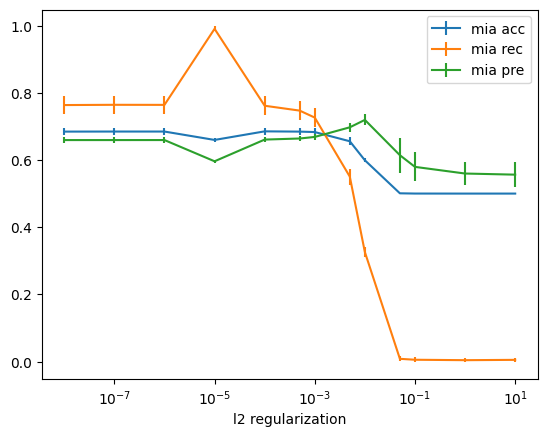

In [313]:
plt.errorbar(x, d_acc['mean'], d_acc['std'], label="mia acc")
plt.errorbar(x, d_rec['mean'], d_rec['std'], label="mia rec")
plt.errorbar(x, d_pre['mean'], d_pre['std'], label="mia pre")

plt.xscale("log")
plt.xlabel('l2 regularization')
plt.legend()
plt.savefig(f'figures/mia/noDP_{show}{show1}rec.png')


In [309]:
splits = {}
for key in a_params:
    temp = key[key.find('_lr'):]
    if temp in splits:

        splits[temp]['attack_acc'].append(a_params[key]['attack_acc'])
        splits[temp]['attack_pre'].append(a_params[key]['attack_pre'])
        splits[temp]['attack_rec'].append(a_params[key]['attack_rec'])
    else:

        splits[temp] = {}
        splits[temp]['attack_acc'] = [a_params[key]['attack_acc']]
        splits[temp]['attack_pre'] = [a_params[key]['attack_pre']]
        splits[temp]['attack_rec'] = [a_params[key]['attack_rec']]

mean_res = {}
for key in splits:
    mean_res[key] = {}
    for metric in splits[key]:   
        mean_res[key] [metric] = (np.mean(splits[key][metric]), np.std(splits[key][metric]))


rs13_lr0.001_iter100_reg0.005_DPFalse_target_model
rs42_lr0.001_iter100_reg0.005_DPFalse_target_model
rs1_lr0.001_iter100_reg0.01_DPFalse_target_model
rs1_lr0.001_iter100_reg10_DPFalse_target_model
rs42_lr0.001_iter100_reg0.0001_DPFalse_target_model
rs1_lr0.001_iter100_reg1e-07_DPFalse_target_model
rs42_lr0.001_iter100_reg0.0005_DPFalse_target_model
rs1_lr0.001_iter100_reg0.05_DPFalse_target_model
rs42_lr0.001_iter100_reg0.001_DPFalse_target_model
rs13_lr0.001_iter100_reg0.1_DPFalse_target_model
rs13_lr0.001_iter100_reg0.001_DPFalse_target_model
rs24_lr0.001_iter100_reg1e-05_DPFalse_target_model
rs42_lr0.001_iter100_reg1e-08_DPFalse_target_model
rs13_lr0.001_iter100_reg1e-08_DPFalse_target_model
rs42_lr0.001_iter100_reg0.01_DPFalse_target_model
rs1_lr0.001_iter100_reg1_DPFalse_target_model
rs42_lr0.001_iter100_reg0.05_DPFalse_target_model
rs1_lr0.001_iter100_reg0.005_DPFalse_target_model
rs1_lr0.001_iter100_reg1e-08_DPFalse_target_model
rs1_lr0.001_iter100_reg0.001_DPFalse_target_model

In [303]:
d_pre

,best_mi_models_attack_model_aneur64_ado0_alr0.001_alreg1e-05_aepoch500,best_mi_models_attack_model_aneur64_ado0_alr0.001_alreg1e-09_aepoch500,best_mi_models_attack_model_aneur64_ado0_alr0.001_alreg0_aepoch500,best_mi_models_attack_model_aneur64_ado0_alr0.001_alreg1e-06_aepoch200,best_mi_models_attack_model_aneur64_ado0_alr0.001_alreg0.0001_aepoch500,best_mi_models_attack_model_aneur64_ado0_alr0.001_alreg1e-06_aepoch500,mean,std
0,0.659573,0.657639,0.656861,0.645084,0.671021,0.666235,0.659402,0.008127
1,0.659445,0.656860,0.657513,0.645084,0.670835,0.666663,0.659400,0.008149
2,0.660131,0.657971,0.657334,0.644999,0.670401,0.665768,0.659434,0.007914
3,0.595818,0.598490,0.589809,0.595790,0.591570,0.606012,0.596248,0.005230
4,0.661516,0.658761,0.657576,0.646822,0.672916,0.667498,0.660848,0.008186
5,0.664694,0.662488,0.661637,0.648693,0.676018,0.670814,0.664057,0.008500
6,0.670132,0.667324,0.665680,0.651784,0.681361,0.676136,0.668736,0.009263
7,0.703261,0.697172,0.699539,0.669924,0.708911,0.705329,0.697356,0.012841
8,0.728301,0.724283,0.725827,0.683096,0.726237,0.728934,0.719446,0.016330
9,0.653391,0.643574,0.648473,0.510764,0.584028,0.645805,0.614339,0.051932


In [ ]:
DPfalse_res_acc = {}
DPfalse_res_rec = {}
DPfalse_res_pre = {}

for n_am, best_am in enumerate(best_ams):
    a_model = Net_attack(h_neurons=64, do=0, input_size=100)
    a_model = ams[best_am]
    a_model.input_size = 200  
    
    a_params = dict(tms_params)

    for key in tms:
        if 'DPFalse' not in key:
            continue
        print(key)
        rand_seed = int(key[key.find('rs')+2:key.find('_lr')])
        x_target_train, y_target_train, x_target_test, y_target_test = data_shuffle(rand_seed, X_raw, y_raw)
        model = algo.LogisticRegression_DPSGD()
        model.n_classes = n_classes
        model.theta = tms[key]
        model.train_acc = model.evaluate(x_target_train, y_target_train, acc=True)
        model.test_acc = model.evaluate(x_target_test, y_target_test, acc=True)

        attack_acc, attack_pre, attack_rec = mi_attack_test(model, a_model, x_target_train, y_target_train, x_target_test, y_target_test)
        a_params[key]['attack_acc'] = attack_acc
        a_params[key]['attack_pre'] = attack_pre
        a_params[key]['attack_rec'] = attack_rec
        print(a_params[key])

    splits = {}
    for key in a_params:
    #     if 'rs13' not in key:
    # #     if 'rs13' not in key and 'rs42' not in key and 'rs24' not in key:
    #         continue
        temp = key[key.find('_lr'):]
        if temp in splits:

            splits[temp]['attack_acc'].append(a_params[key]['attack_acc'])
            splits[temp]['attack_pre'].append(a_params[key]['attack_pre'])
            splits[temp]['attack_rec'].append(a_params[key]['attack_rec'])
        else:

            splits[temp] = {}
            splits[temp]['attack_acc'] = [a_params[key]['attack_acc']]
            splits[temp]['attack_pre'] = [a_params[key]['attack_pre']]
            splits[temp]['attack_rec'] = [a_params[key]['attack_rec']]

    mean_res = {}
    for key in splits:
        mean_res[key] = {}
        for metric in splits[key]:   
            mean_res[key] [metric] = (np.mean(splits[key][metric]), np.std(splits[key][metric]))

    lr = 'lr0.001'
    it = 'iter100' 
    reg = 'reg1e-05'
    DP = 'DPFalse'
    show = f'{lr}_{it}' #f'{lr}_{it}_{reg}_{DP}'
    show1 = f'_{DP}'
    l2_res = {}
    l2_res_rec = {}
    l2_res_pre = {}
    for key in mean_res:
        if show in key and show1 in key:
            l2 = float(key[key.find('_reg')+4:key.find('_DPFalse')])
            l2_res[l2] = mean_res[key]['attack_acc']
            l2_res_rec[l2] = mean_res[key]['attack_rec']
            l2_res_pre[l2] = mean_res[key]['attack_pre']

    x = list(l2_res.keys())
    x.sort()
    DPfalse_res_acc[best_am] = [l2_res[i][0] for i in x]
    DPfalse_res_rec[best_am] = [l2_res_rec[i][0] for i in x]
    DPfalse_res_pre[best_am] = [l2_res_pre[i][0] for i in x]
